In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import deeptime.markov as markov
from deeptime.plots import plot_implied_timescales
from deeptime.plots import plot_ck_test
from deeptime.util.validation import implied_timescales
import pyemma
import networkx as nx

import sys
import os

# Absolute path to your module's directory
module_path = os.path.abspath('/localscratch/zippoema/git/HPA/src/')
if module_path not in sys.path:
    sys.path.insert(0, module_path)

import hpa.util
import hpa.msm
import hpa.plots
plt.style.use('/localscratch/zippoema/md_plots/corr_plot.mplstyle')

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:160: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


In [391]:
path = '/localscratch/zippoema/project_ness/simulations/ness_1-ck1d_1-pp3/'
path_simple = '/localscratch/zippoema/project_ness/simulations/simple-ness_CAL3/'
path_an = '/localscratch/zippoema/project_ness/analysis/ness_1-ck1d_1-pp3/'
path_simple_an = '/localscratch/zippoema/project_ness/analysis/simple-ness_CAL3/'
path_old = '/media/zippoema/Elements/zippo_phd_data/project_hps_phospho_tdp43_natcomm/simple-ness/simulations/'
path_simple_pl= '/localscratch/zippoema/project_ness/plots/simple-ness_CAL3/'

In [3]:
def ck_test(states, lagtimes, reversible=False):

    counts = markov.TransitionCountEstimator(lagtime=1, count_mode='effective').fit_fetch(states-1)
    msm1 = markov.msm.BayesianMSM(n_samples=100, n_steps=20, reversible=reversible).fit_fetch(counts)
    tr_mat = msm1.gather_stats('transition_matrix').mean
    predicted_t = []
    estimated_t = []
    estimated_t_err = []
    
    for lagtime in lagtimes:
        counts = markov.TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(states-1)
        msm_tmp = markov.msm.BayesianMSM(n_samples=100, n_steps=20, reversible=reversible).fit_fetch(counts)
        tr_mat_tmp = msm_tmp.gather_stats('transition_matrix').mean
        err_tr_mat_tmp = msm_tmp.gather_stats('transition_matrix').std
        estimated_t.append(tr_mat_tmp)
        estimated_t_err.append(err_tr_mat_tmp)
        predicted_t.append(np.linalg.matrix_power(tr_mat,lagtime))
    
    return np.array(predicted_t), np.array(estimated_t), np.array(estimated_t_err)
    

# Create MSM discrete trajectory

### old HPS ser10 trajectory 4 states

In [15]:
d_old = np.loadtxt(path_old+f'sim_ser10/sim-ser10_mu-5_ck1d-rigid_tdp43_dist.txt')
d_old.shape


(195000, 154)

In [16]:
bound_bool_old = hpa.msm.boundtraj_with_dist_criterion(d_old, min_dist=3., max_dist=8, therm=0, end_time=None, save=None)
phospho_traj_old = np.loadtxt(path_old+f'sim_ser10/sim-ser10_mu-5_ck1d-rigid_tdp43_phosphotraj.txt').astype(bool)
phospho_traj_old.shape

(195000,)

In [46]:
states_old = hpa.msm.create_states_trajectory(bound_bool_old, phospho_traj_old, save=None)

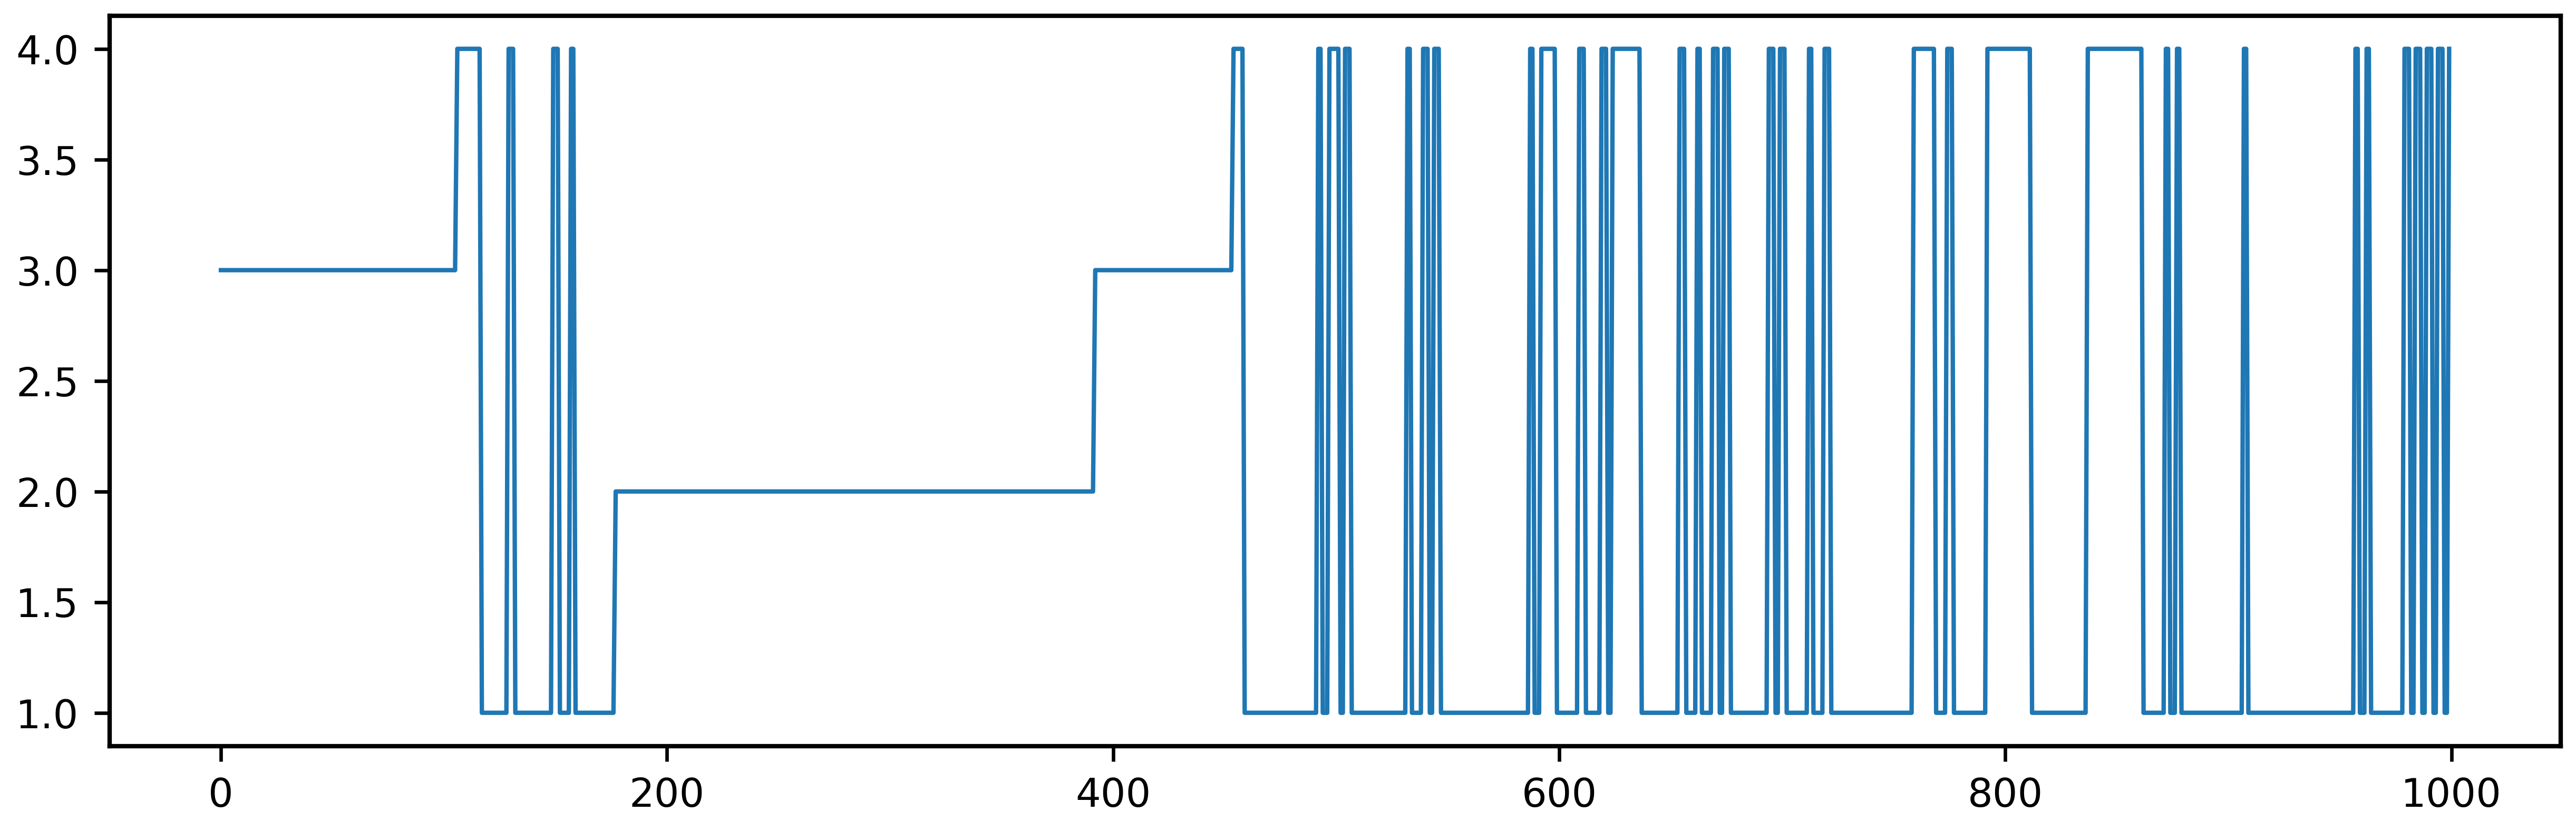

In [34]:
plt.figure(figsize=(10,3))
plt.plot(states_old[:1000], color='tab:blue')


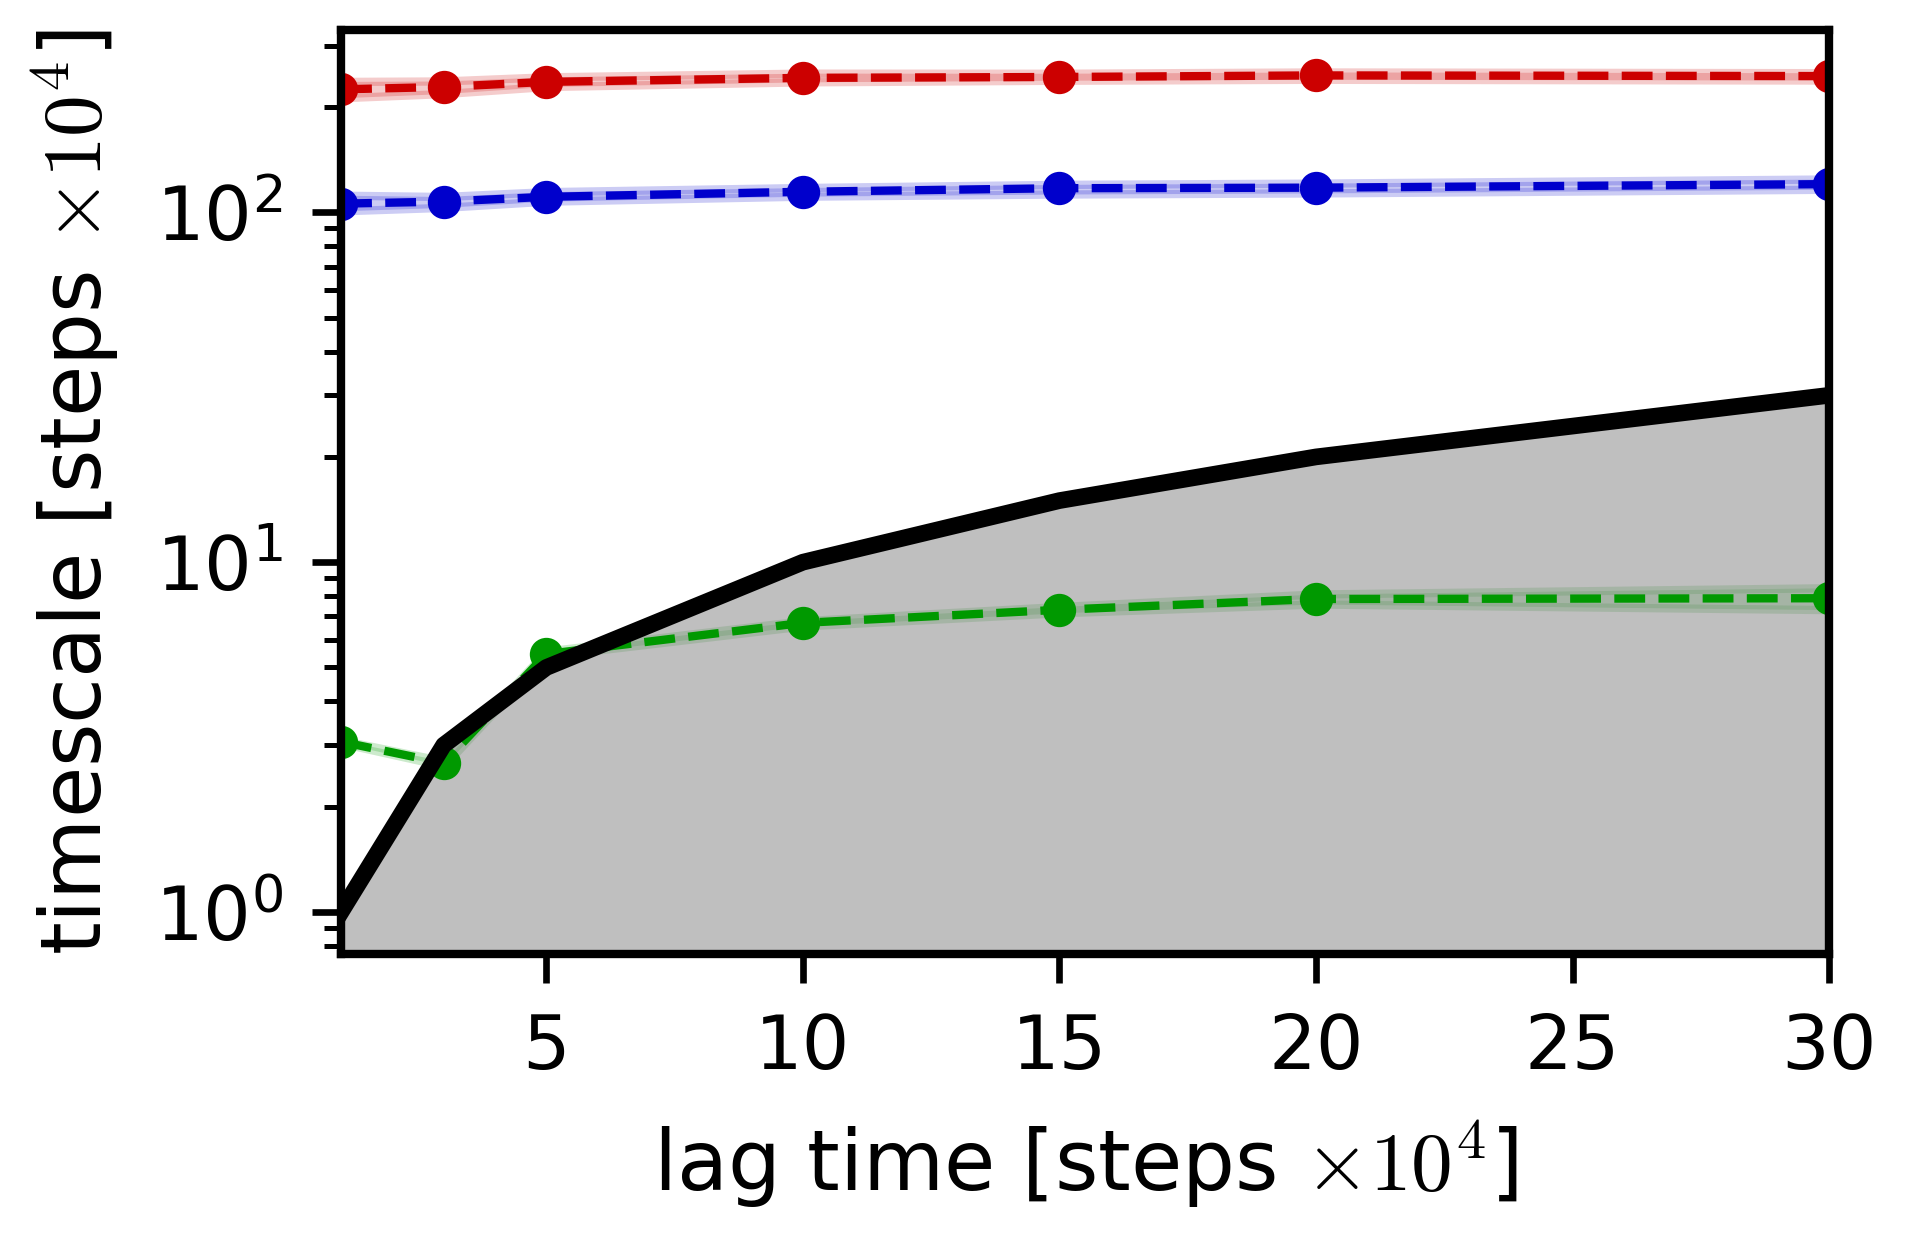

In [35]:
models = []
lagtimes = [1,3,5,10,15,20,30]
for lagtime in lagtimes:
    counts = markov.TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(states_old-1)
    models.append(markov.msm.BayesianMSM(n_samples=100, n_steps=20, reversible=False).fit_fetch(counts))

its_data = implied_timescales(models)

fig, ax = plt.subplots(1, 1, figsize=(3.2,2))

plot_implied_timescales(its_data, ax=ax, show_mle=False, sample_confidence=.68)
ax.set_yscale('log')
ax.set_xlabel(r'lag time [steps $\times 10^4$]')
ax.set_ylabel(r'timescale [steps $\times 10^4$]')
ax.set_xlim(1,30)
plt.savefig('/localscratch/zippoema/project_ness/plots/simple-ness_CAL3/its_ser19_dmu-5_hps-cp-r30_10k_VAMPnet.png', dpi=1200)

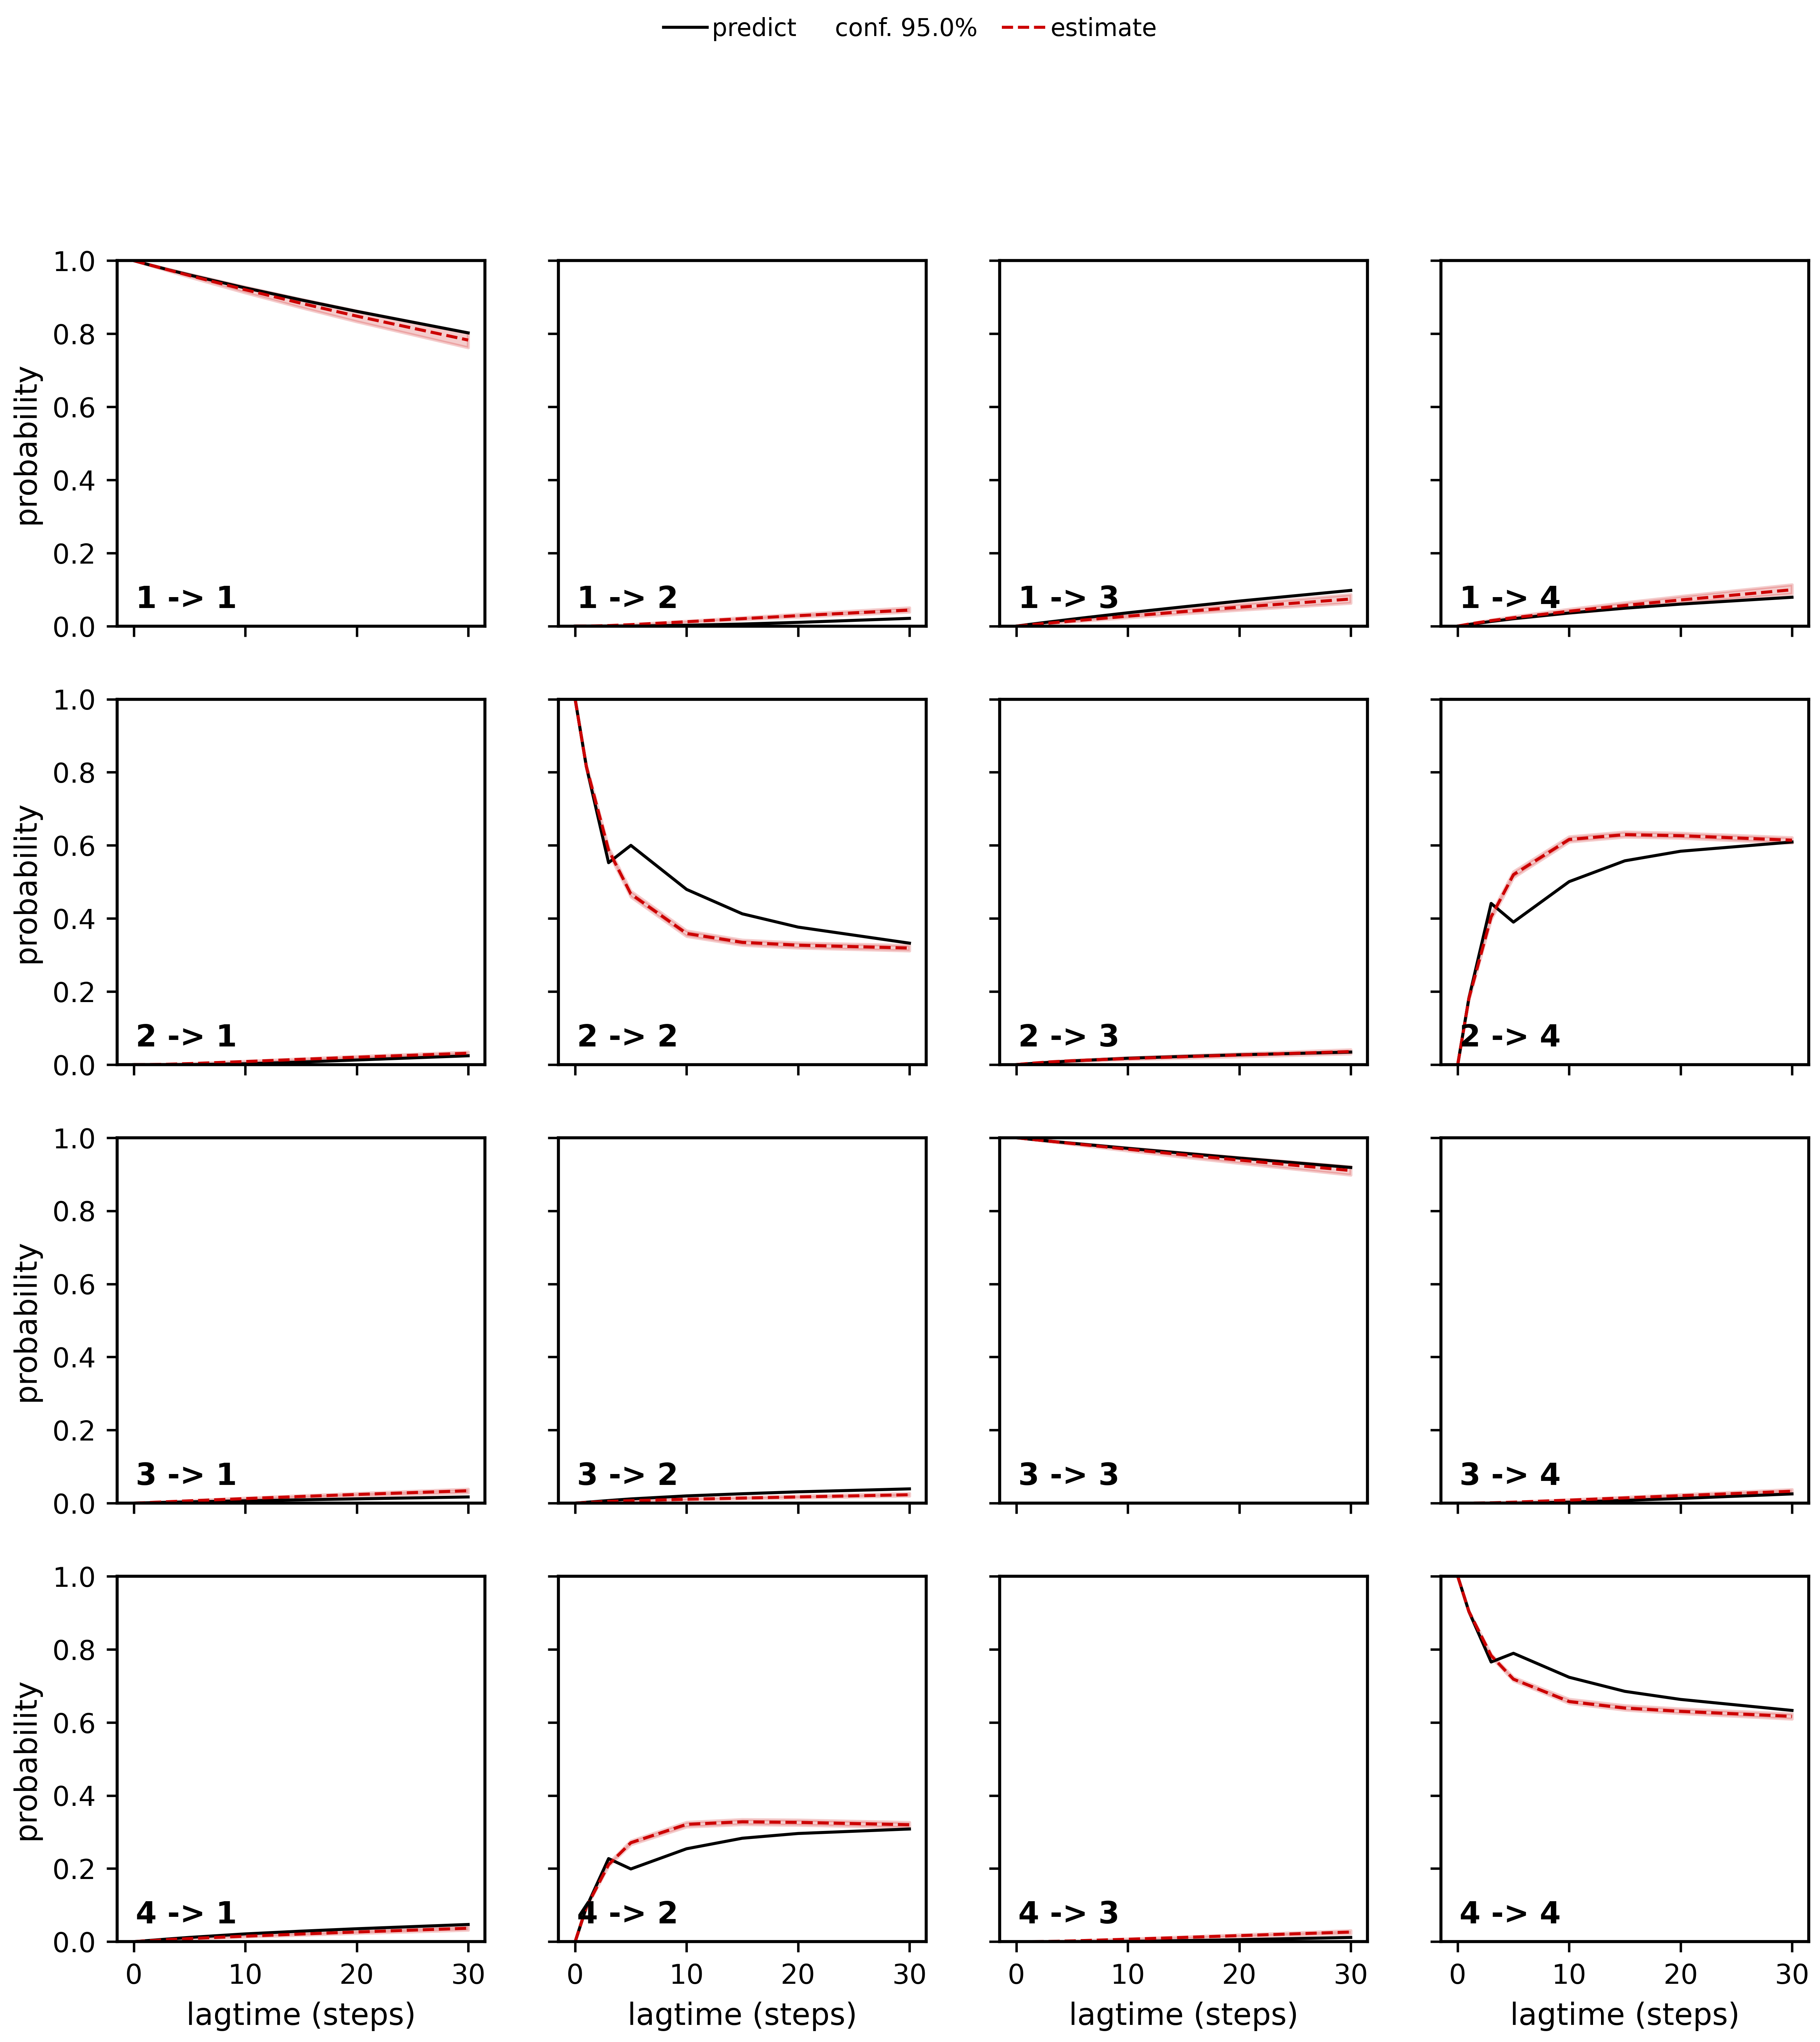

In [36]:
# model with lagtime 10
counts = markov.TransitionCountEstimator(lagtime=1, count_mode='effective').fit_fetch(states_old-1)
msm = markov.msm.BayesianMSM(n_samples=100, n_steps=20).fit_fetch(counts)
ck = msm.ck_test(models, 4)
plot_ck_test(ck)


In [37]:
pred_ck, est_ck, est_err_ck = ck_test(states_old, lagtimes, reversible=True)

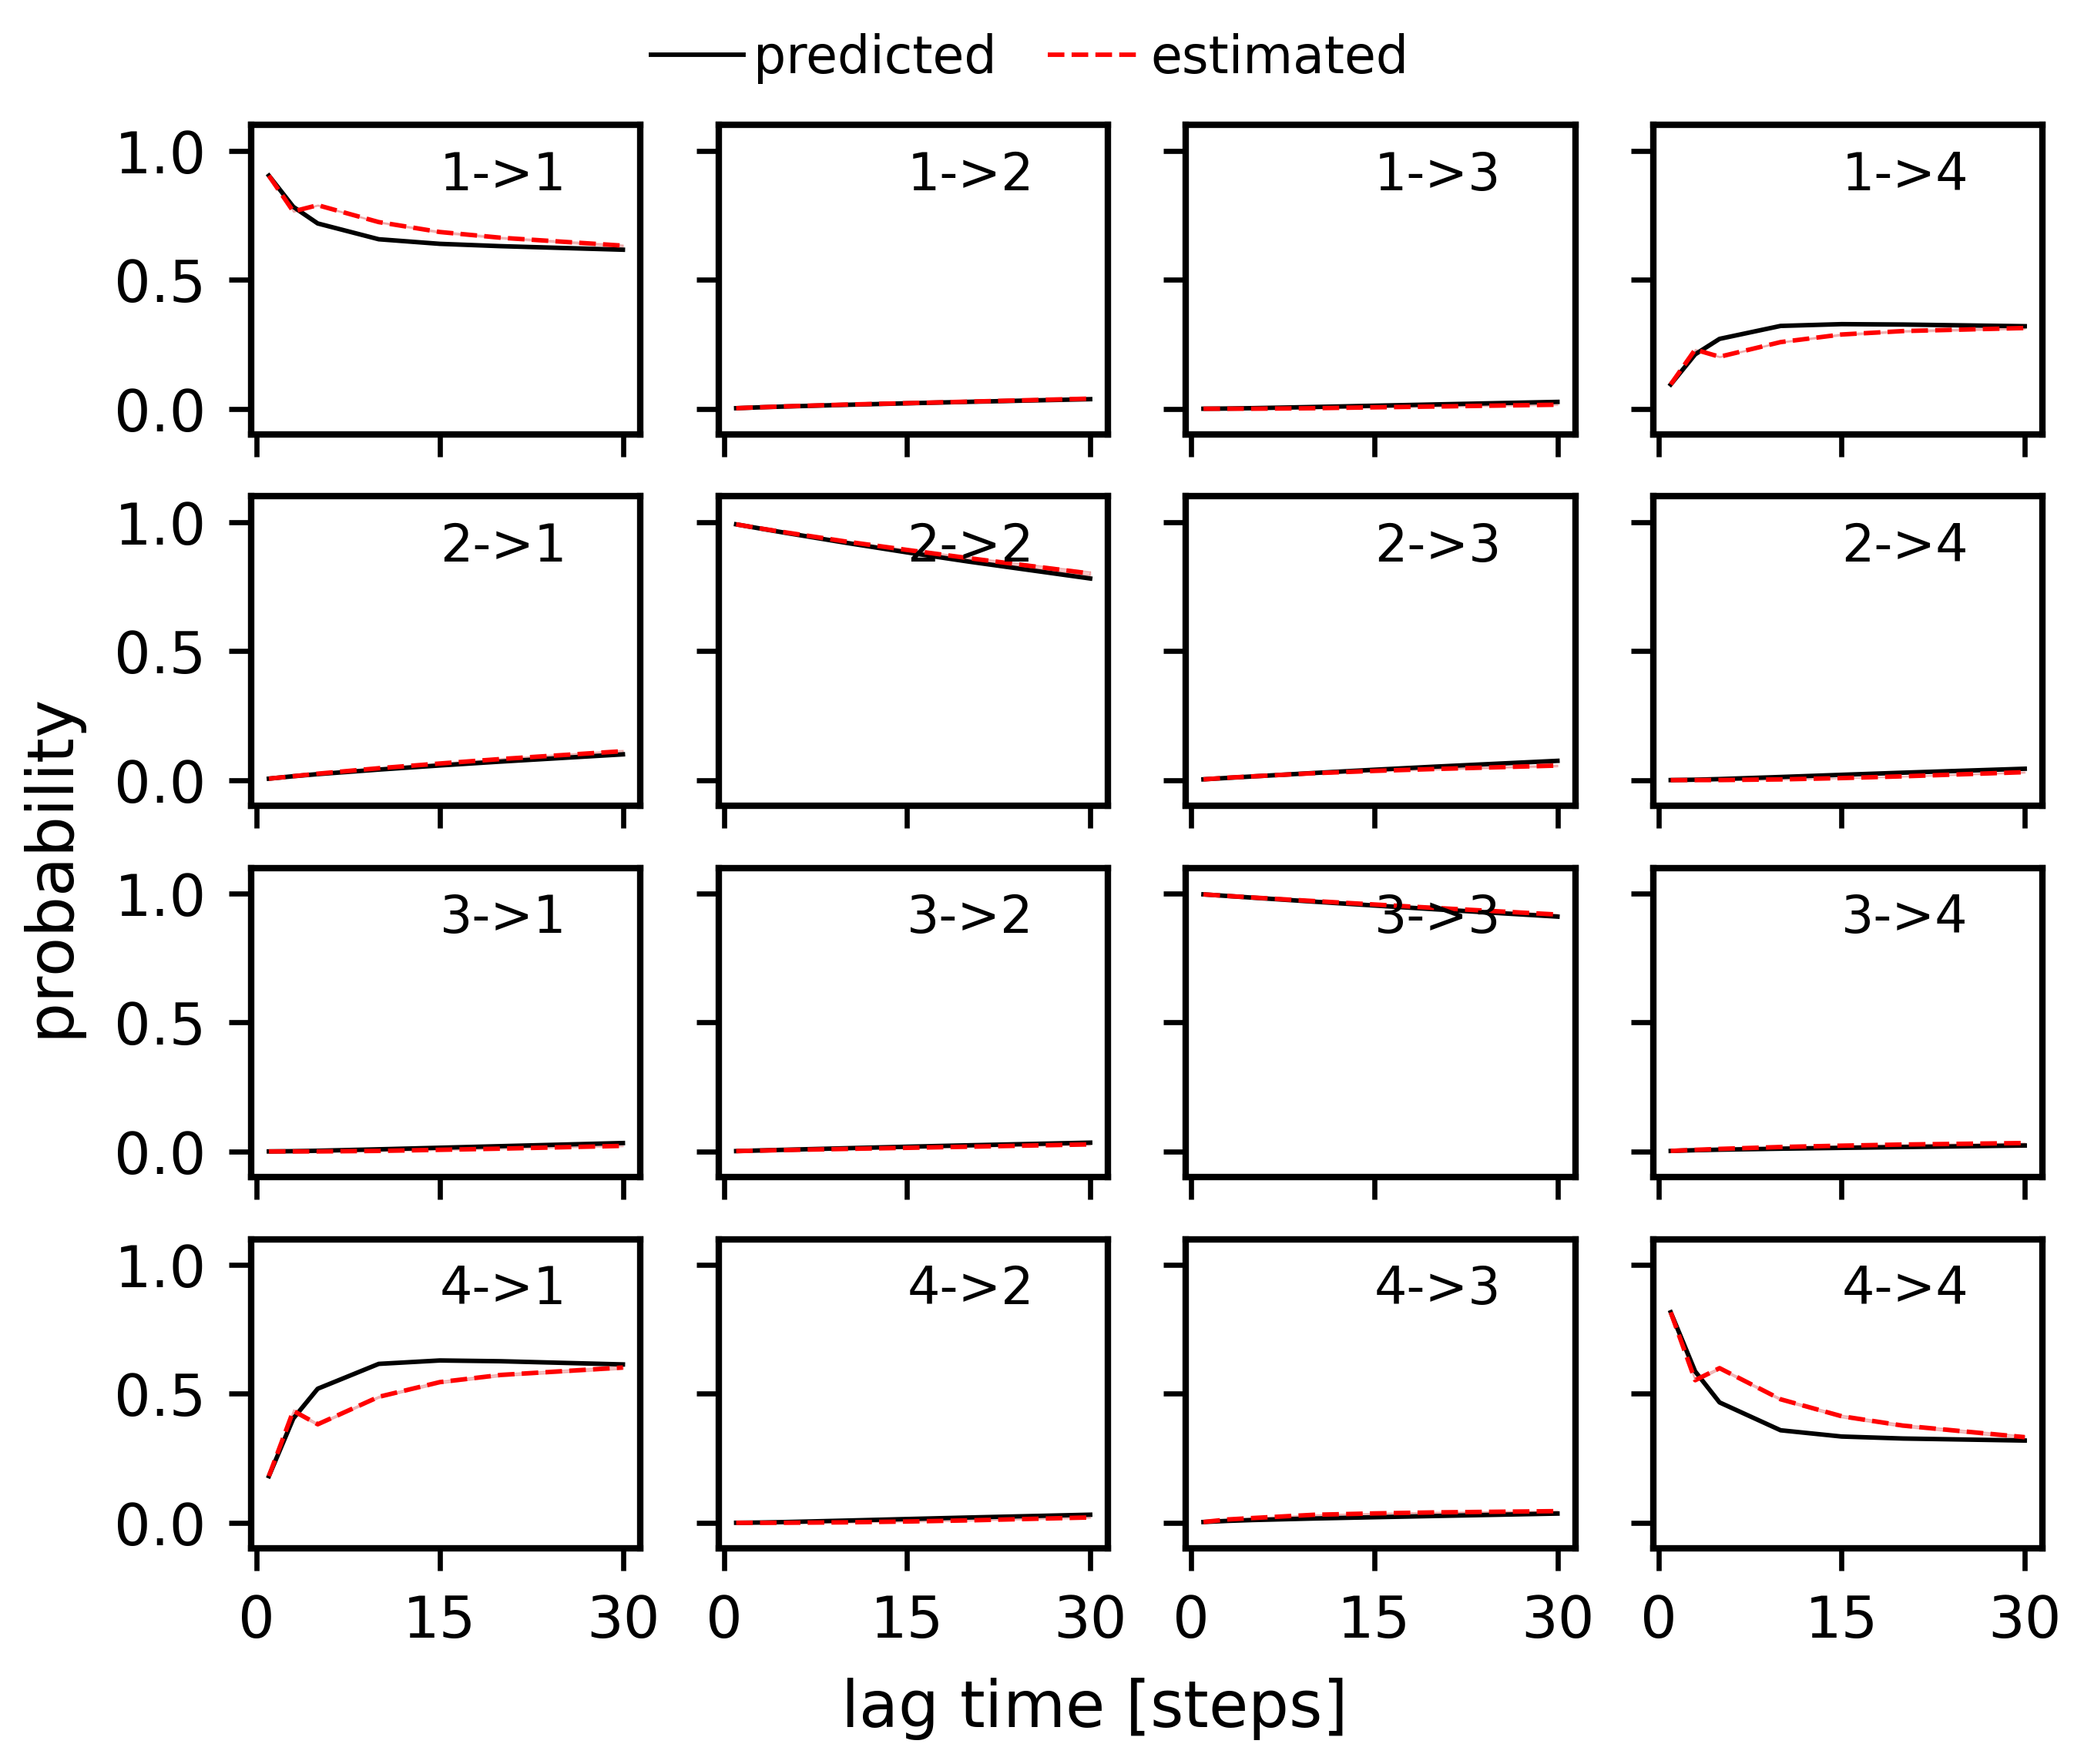

In [39]:
fig, ax = plt.subplots(4,4, figsize=(5,4), sharex=True, sharey=True)
type(ax)

plt.yticks([0.0,0.5,1.0],[0.0,0.5,1.0])
plt.xticks([0,15,30],[0,15,30])
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

for i in range(4):
    for j in range(4):
        ax[i,j].plot(lagtimes, pred_ck[:,i,j], 'k', linewidth=0.7, label='predicted')
        ax[i,j].plot(lagtimes, est_ck[:,i,j], '--r', linewidth=0.7, label='estimated')
        ax[i,j].fill_between(lagtimes, est_ck[:,i,j]-est_err_ck[:,i,j], est_ck[:,i,j]+est_err_ck[:,i,j], alpha=0.25, color='tab:red', linewidth=0.2)
        ax[i,j].set_ylim(-0.1,1.1)
        ax[i,j].text(15,0.85, f'{i+1}->{j+1}', fontsize=8)

        if i==3 and j==1:
            ax[i,j].set_xlabel(r'$\qquad \qquad \qquad$ lag time [steps]')
        if i==2 and j==0:
            ax[i,j].set_ylabel(r'$\qquad \qquad \quad$ probability')
            ax[i,j].legend(loc=(1.,3.5), ncols=2)
plt.savefig('/localscratch/zippoema/project_ness/plots/simple-ness_CAL3/ck-test_ser19_dmu-5_hps-cp-r30_10k_VAMPnet.png', dpi=1200)

In [47]:
dmus_old = [hpa.msm.dmu_estimate(states_old, lag=t, n_term=1000) for t in range(3,15)]
dmus_old

100%|███████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 8009.59it/s]


[4.733752757944939,
 4.7948569814862765,
 4.840371728291834,
 4.867658550996933,
 4.917542478009263,
 4.961320111117376,
 4.983057157634341,
 4.993486851608588,
 5.011839853724422,
 5.019825365060174,
 5.023801436748229,
 5.0498503403298285]

In [48]:
dmu_old = hpa.msm.dmu_estimate(states_old, lag=10, n_term=1000)
sigma_dmu_old = hpa.msm.bootstrap_dmu_estimate(states_old, lag=10, pow_bin=10, n_resample=30, n_term=1000)

100%|███████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 7944.21it/s]


In [49]:
dmu_old, sigma_dmu_old

(4.993486851608588, 0.6530896751044881)

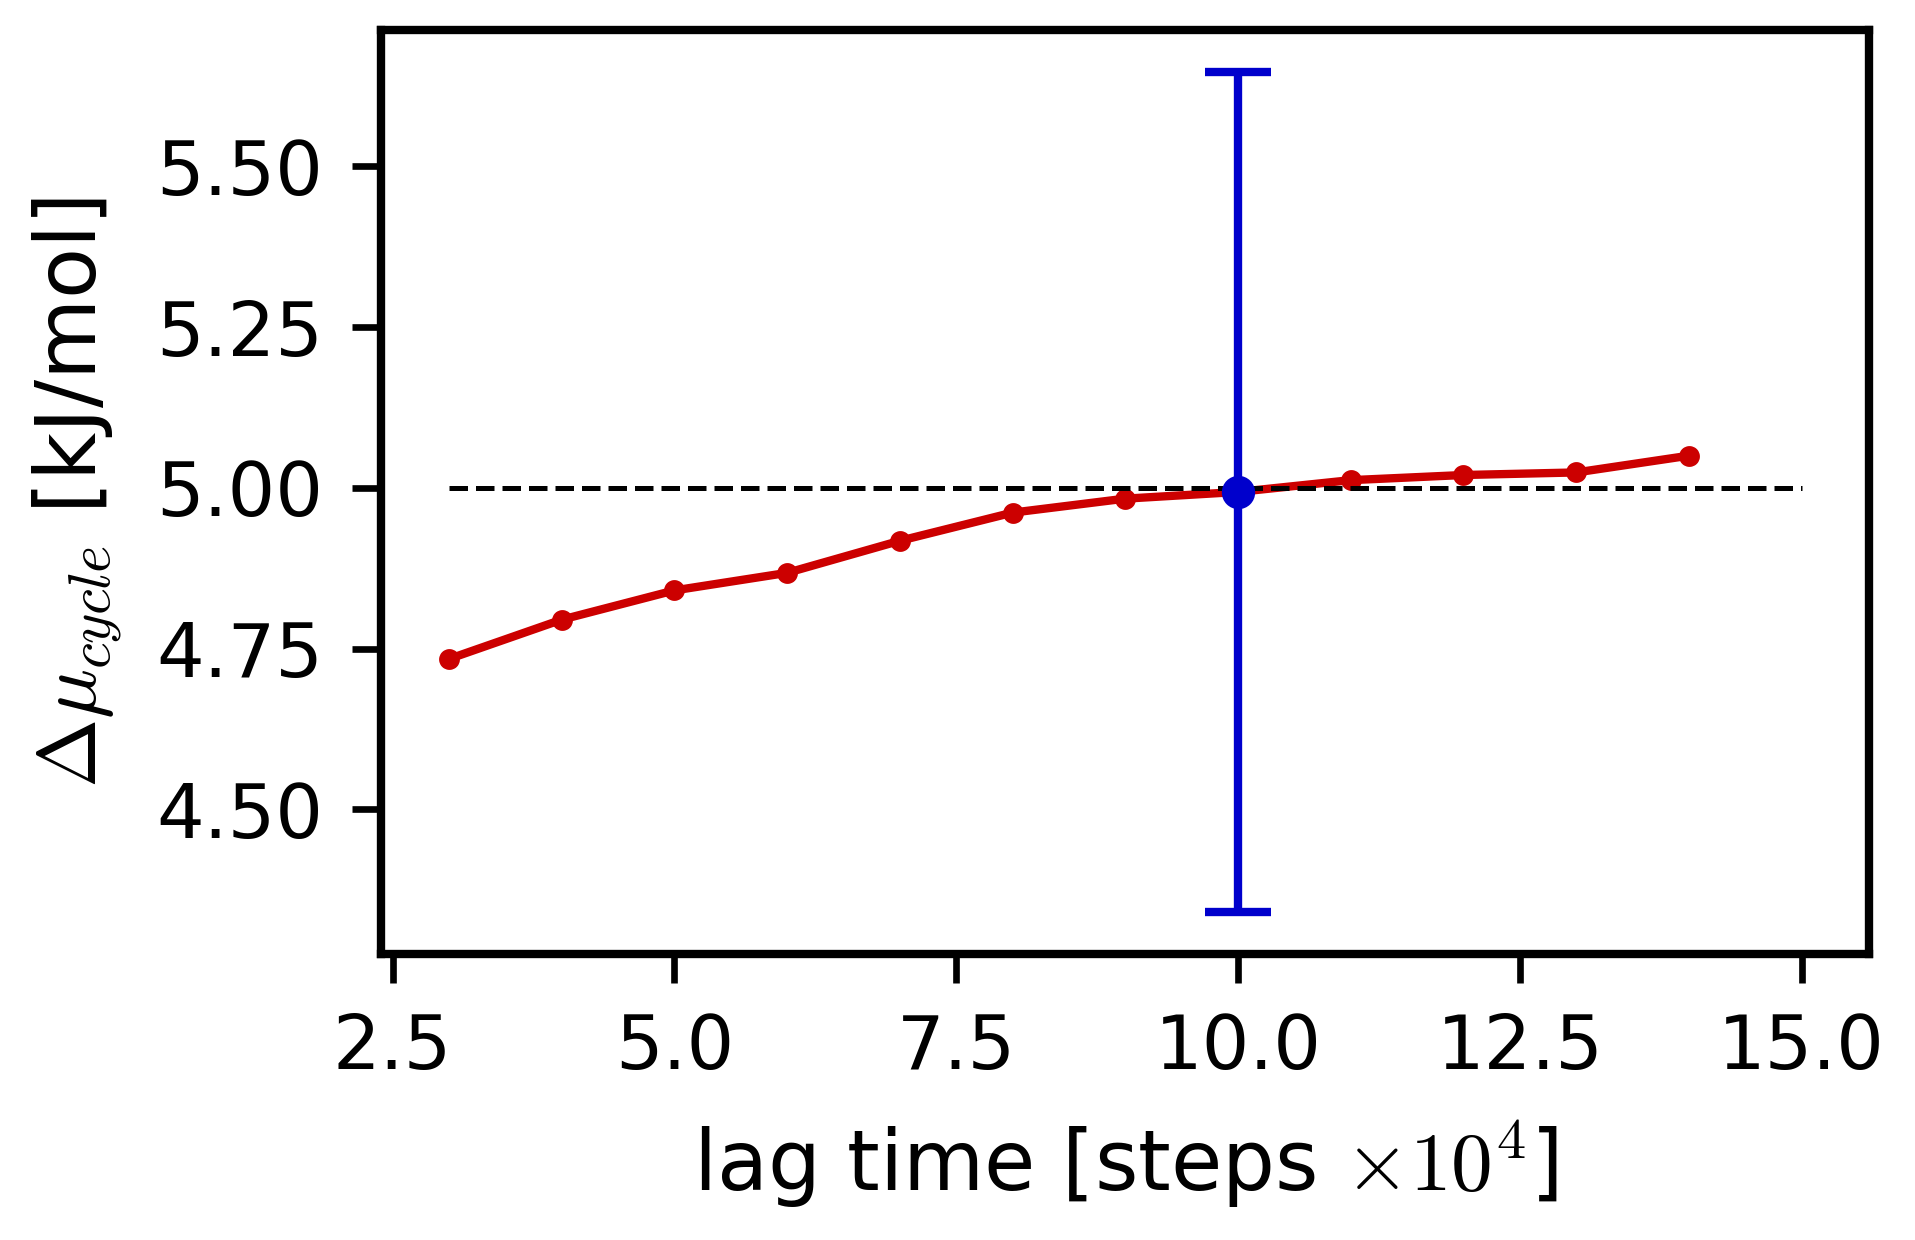

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(3.2,2))

ax.plot(range(3,15), dmus_old, '.-')
ax.errorbar([10],[dmu_old],[sigma_dmu_old], fmt='o', capsize=4)
ax.set_xlabel(r'lag time [steps $\times 10^4$]')
ax.set_ylabel(r'$\Delta \mu_{cycle}$ [kJ/mol]')
ax.plot([3,15],[5,5], '--k', lw=0.6)
#ax.set_ylim(15,42)
plt.savefig('/localscratch/zippoema/project_ness/plots/simple-ness_CAL3/dmu_ser19_dmu-5_hps-cp-r30_10k_VAMPnet.png', dpi=1200)

### CALVADOS3 8 states

In [123]:
s=1

In [124]:
d = np.loadtxt(path+f'sim_ser19_dmu-5_0_1-tdp43-2pser_1-ck1d-open_1-pp3/sim{s}_ser19_dmu-5_0_1-tdp43-2pser_com-ck1d-open_com-pp3_CAL3_dist.txt')
d.shape

(20000, 308)

In [125]:
bound_bool_ck1d = hpa.msm.boundtraj_with_dist_criterion(d[:,:154], min_dist=3., max_dist=8, therm=0, end_time=None)
bound_bool_pp3 = hpa.msm.boundtraj_with_dist_criterion(d[:,154:], min_dist=3., max_dist=8, therm=0, end_time=None)

np.savetxt(path_an+f'sim_ser19_dmu-5_0_1-tdp43-2pser_1-ck1d-open_1-pp3/sim{s}_ser19_dmu-5_0_1-tdp43-2pser_com-ck1d-open_com-pp3_CAL3_distboundtraj_ck1d.txt', bound_bool_ck1d)
np.savetxt(path_an+f'sim_ser19_dmu-5_0_1-tdp43-2pser_1-ck1d-open_1-pp3/sim{s}_ser19_dmu-5_0_1-tdp43-2pser_com-ck1d-open_com-pp3_CAL3_distboundtraj_pp3.txt', bound_bool_pp3)

In [126]:
phospho_bool = np.loadtxt(path_an+f'sim_ser19_dmu-5_0_1-tdp43-2pser_1-ck1d-open_1-pp3/sim{s}_ser19_dmu-5_0_1-tdp43-2pser_com-ck1d-open_com-pp3_CAL3_phosphotraj.txt').astype(bool)

In [127]:
bound_bool_ck1d.shape

(20000,)

In [128]:
states_ck1d = hpa.msm.create_states_trajectory(bound_bool_ck1d, phospho_bool, save=None)
states_pp3 = hpa.msm.create_states_trajectory(bound_bool_pp3, phospho_bool, save=None)
states = np.column_stack((states_ck1d,states_pp3))

In [129]:
states_num = hpa.msm.create_states_trajectory_2enzymes(bound_bool_ck1d,bound_bool_pp3,phospho_bool, 
                save=path_an+f'sim_ser19_dmu-5_0_1-tdp43-2pser_1-ck1d-open_1-pp3/sim{s}_ser19_dmu-5_0_1-tdp43-2pser_com-ck1d-open_com-pp3_CAL3_states.txt')

In [130]:
print([ (states[i], states_num[i]) for i in range(5638,5700) ])
print()
print(np.max(states_num), np.min(states_num))

[(array([4, 4]), 4), (array([3, 4]), 3), (array([3, 4]), 3), (array([3, 4]), 3), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([3, 4]), 3), (array([3, 4]), 3), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([3, 4]), 3), (array([3, 4]), 3), (array([3, 4]), 3), (array([3, 4]), 3), (array([3, 4]), 3), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([3, 4]), 3), (array([3, 4]), 3), (array([3, 4]), 3), (array([3, 4]), 3), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4), (array([4, 4]), 4),

### CALVADOS3 6 states

In [263]:
# Select NESS simulation

for s in range(1,11):
    c = np.loadtxt(path+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_contacts.txt')
    phospho_bool = hpa.msm.changes_to_phosphostate(c[(c[:, 2] != 0) & (c[:, 2] != 2)], step=50000, end_time=600000000, 
                                                   save=path_an+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_phosphotraj.txt')

In [336]:
d = np.loadtxt(path+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_dist.txt')
d.shape

(12000, 308)

In [337]:
bound_bool_ck1d = hpa.msm.boundtraj_with_dist_criterion(d[:,:154], min_dist=3., max_dist=8, therm=0, end_time=None)
bound_bool_pp3 = hpa.msm.boundtraj_with_dist_criterion(d[:,154:], min_dist=3., max_dist=8, therm=0, end_time=None)

np.savetxt(path_an+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_distboundtraj_ck1d.txt', bound_bool_ck1d)
np.savetxt(path_an+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_distboundtraj_pp3.txt', bound_bool_pp3)

In [406]:
s=10

In [407]:
phospho_bool = np.loadtxt(path_an+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_phosphotraj.txt').astype(bool)
bound_bool_ck1d = np.loadtxt(path_an+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_boundtraj_ck1d.txt').astype(bool)
bound_bool_pp3 = np.loadtxt(path_an+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_boundtraj_pp3.txt').astype(bool)

In [408]:
bound_bool_ck1d.shape

(12000,)

In [409]:
states_ck1d = hpa.msm.create_states_trajectory(bound_bool_ck1d, phospho_bool, save=None)
states_pp3 = hpa.msm.create_states_trajectory(bound_bool_pp3, phospho_bool, save=None)
states = np.column_stack((states_ck1d,states_pp3))

In [410]:
states_num = hpa.msm.create_states_trajectory_2enzymes(bound_bool_ck1d,bound_bool_pp3,phospho_bool, 
                save=path_an+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_states_VAMPnet.txt')


In [411]:
print([ (states[i], states_num[i]) for i in range(5638,5700) ])
print()
print(np.max(states_num), np.min(states_num))

[(array([2, 1]), 2), (array([2, 1]), 2), (array([2, 1]), 2), (array([2, 1]), 2), (array([2, 1]), 2), (array([2, 1]), 2), (array([1, 1]), 1), (array([2, 1]), 2), (array([1, 1]), 1), (array([1, 1]), 1), (array([1, 1]), 1), (array([1, 1]), 1), (array([1, 1]), 1), (array([1, 2]), 6), (array([1, 2]), 6), (array([1, 1]), 1), (array([1, 1]), 1), (array([1, 1]), 1), (array([1, 1]), 1), (array([2, 1]), 2), (array([2, 1]), 2), (array([1, 1]), 1), (array([1, 1]), 1), (array([2, 1]), 2), (array([1, 1]), 1), (array([1, 1]), 1), (array([2, 1]), 2), (array([2, 1]), 2), (array([2, 1]), 2), (array([1, 1]), 1), (array([1, 1]), 1), (array([1, 1]), 1), (array([1, 1]), 1), (array([1, 1]), 1), (array([2, 1]), 2), (array([2, 1]), 2), (array([2, 1]), 2), (array([1, 1]), 1), (array([1, 1]), 1), (array([1, 1]), 1), (array([1, 1]), 1), (array([1, 1]), 1), (array([1, 1]), 1), (array([1, 1]), 1), (array([1, 2]), 6), (array([1, 1]), 1), (array([1, 1]), 1), (array([1, 1]), 1), (array([1, 1]), 1), (array([1, 1]), 1),

### CALVADOS3 4 states

In [727]:
path_mc = '/localscratch/zippoema/working_dir/tests/test_MC_kinetic/sim_ser19_dmu-15_1-tdp43-5pser_1-ck1d-open_10k_MCkin/'


In [728]:
rdump = 5
rigid = 'rigid-'
dmu = 15


In [731]:
for s in range(1,11):
    c = np.loadtxt(path_mc+f'sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-ck1d-open_CAL3_10k_MCkin_changes.txt')
    phospho_bool = hpa.msm.changes_to_phosphostate(c, step=10000, end_time=1000000000, 
                                                   save=path_mc+f'sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-ck1d-open_CAL3_10k_MCkin_phosphotraj.txt')
#    c = np.loadtxt(path_simple+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k_changes.txt')
#    phospho_bool = hpa.msm.changes_to_phosphostate(c, step=5000, end_time=1000000000, 
#                                                   save=path_simple_an+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k_phosphotraj.txt')

In [779]:
d = np.loadtxt(path_mc+f'sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-ck1d-open_CAL3_10k_MCkin_dist.txt')
#d = np.loadtxt(path_simple+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k_dist.txt')
#d = np.append(d, np.loadtxt(path_simple+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k_10us_dist.txt'), axis=0 )
d.shape

(100000, 154)

In [832]:
rdump = 5
rigid = 'rigid-'
dmu = 15

s=10

In [833]:
#bound_bool_ck1d = hpa.msm.boundtraj_with_dist_criterion(d[:,:154], min_dist=3., max_dist=8, therm=0, end_time=None)
#np.savetxt(path_simple_an+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k_distboundtraj.txt', bound_bool_ck1d)
#np.savetxt(path_mc+f'sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-ck1d-open_CAL3_10k_MCkin_distboundtraj.txt', bound_bool_ck1d)
#bound_bool_ck1d = np.loadtxt(path_simple_an+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k_boundtraj.txt').astype(bool)
bound_bool_ck1d = np.loadtxt(path_mc+f'sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-ck1d-open_CAL3_10k_MCkin_boundtraj.txt').astype(bool)
bound_bool_ck1d[:10]

array([False, False, False, False, False, False, False, False, False,
       False])

In [834]:
phospho_bool = np.loadtxt(path_mc+f'sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-ck1d-open_CAL3_10k_MCkin_phosphotraj.txt').astype(bool)
#phospho_bool = np.loadtxt(path_simple_an+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k_phosphotraj.txt').astype(bool)
phospho_bool[:10]

array([False, False, False, False, False, False, False, False, False,
       False])

In [835]:
hpa.msm.create_states_trajectory(bound_bool_ck1d, phospho_bool, 
                                               save=path_mc+f'sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-ck1d-open_CAL3_10k_MCkin_VAMPnet_states.txt')
#                                               save=path_simple_an+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k_states.txt')
#                                               save=path_simple_an+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k_VAMPnet_states.txt')

states_ck1d = hpa.msm.create_states_trajectory(bound_bool_ck1d, phospho_bool)
states_ck1d[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Compute rates MSM

### CALVADOS3 4 states

In [836]:
rdump = 5
rigid = 'rigid-'
dmu = 15

#vampnet = ''
vampnet = '_VAMPnet'

In [837]:
states = np.array([], dtype=int)
for s in range(1,11):
    tmp = np.loadtxt(path_mc+f'sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-ck1d-open_CAL3_10k_MCkin_VAMPnet_states.txt').astype(int)
    #tmp = np.loadtxt(path_simple_an+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k{vampnet}_states.txt').astype(int)
    states = np.append(states, tmp)

print(np.max(states), np.min(states))
len(states)

4 1


1000000

In [838]:
np.sum(np.sum(np.array([states[:-1],states[1:]]).T==[3,1], axis=1)==2)

1

In [839]:
models = []
lagtimes = [1,2,3,4,5,7,10,15,20,40]
for lagtime in lagtimes:
    counts = markov.TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(states-1)
    models.append(markov.msm.BayesianMSM(n_samples=100, n_steps=20).fit_fetch(counts))

### Implied timescales

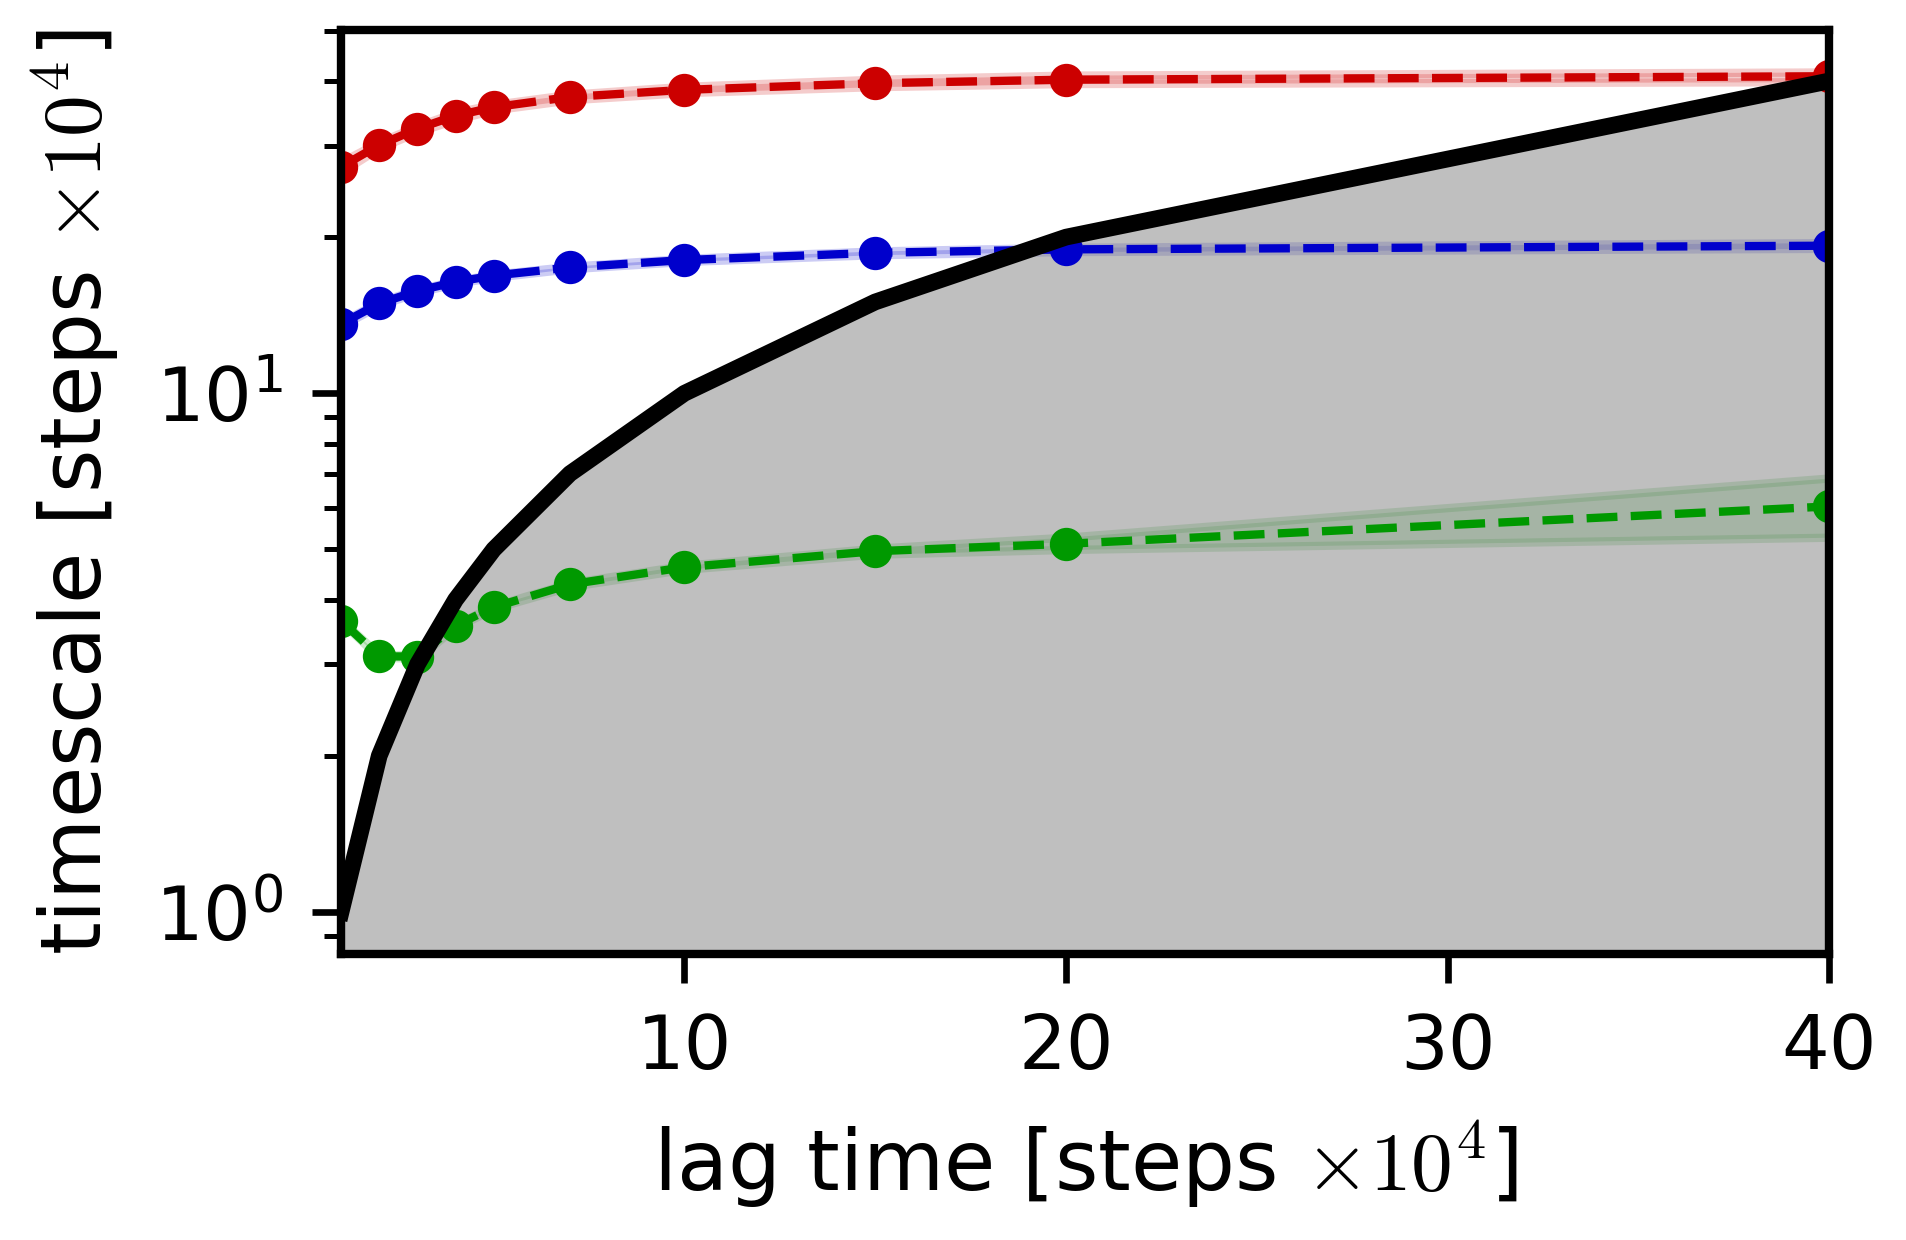

In [840]:
its_data = implied_timescales(models)

fig, ax = plt.subplots(1, 1, figsize=(3.2,2))

plot_implied_timescales(its_data, ax=ax, show_mle=False, sample_confidence=.68)
ax.set_yscale('log')
ax.set_xlabel(r'lag time [steps $\times 10^4$]')
ax.set_ylabel(r'timescale [steps $\times 10^4$]')
ax.set_xlim(lagtimes[0],lagtimes[-1])
#ax.set_ylim(15,42)

#plt.savefig(path_simple_pl+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/its_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k{vampnet}.png', dpi=1200)
plt.savefig(path_mc+f'its_ser19_dmu-{dmu}_1-tdp43-5pser_com-ck1d-open_CAL3_10k_MCkin{vampnet}.png', dpi=1200)


### Chapman-Kolmogorov test

In [841]:
# model with lagtime 10
pred_ck, est_ck, est_err_ck = ck_test(states, lagtimes, reversible=False)

In [842]:
counts = markov.TransitionCountEstimator(lagtime=10, count_mode='effective').fit_fetch(states-1)
msm = markov.msm.BayesianMSM(n_samples=100, n_steps=20).fit_fetch(counts)

tr_mat = msm.gather_stats('transition_matrix').mean
tr_mat

array([[0.79764706, 0.08778999, 0.00567851, 0.10888444],
       [0.31957204, 0.65695642, 0.00517531, 0.01829623],
       [0.06616002, 0.01656181, 0.76881369, 0.14846449],
       [0.65473432, 0.03022207, 0.07663366, 0.23840995]])

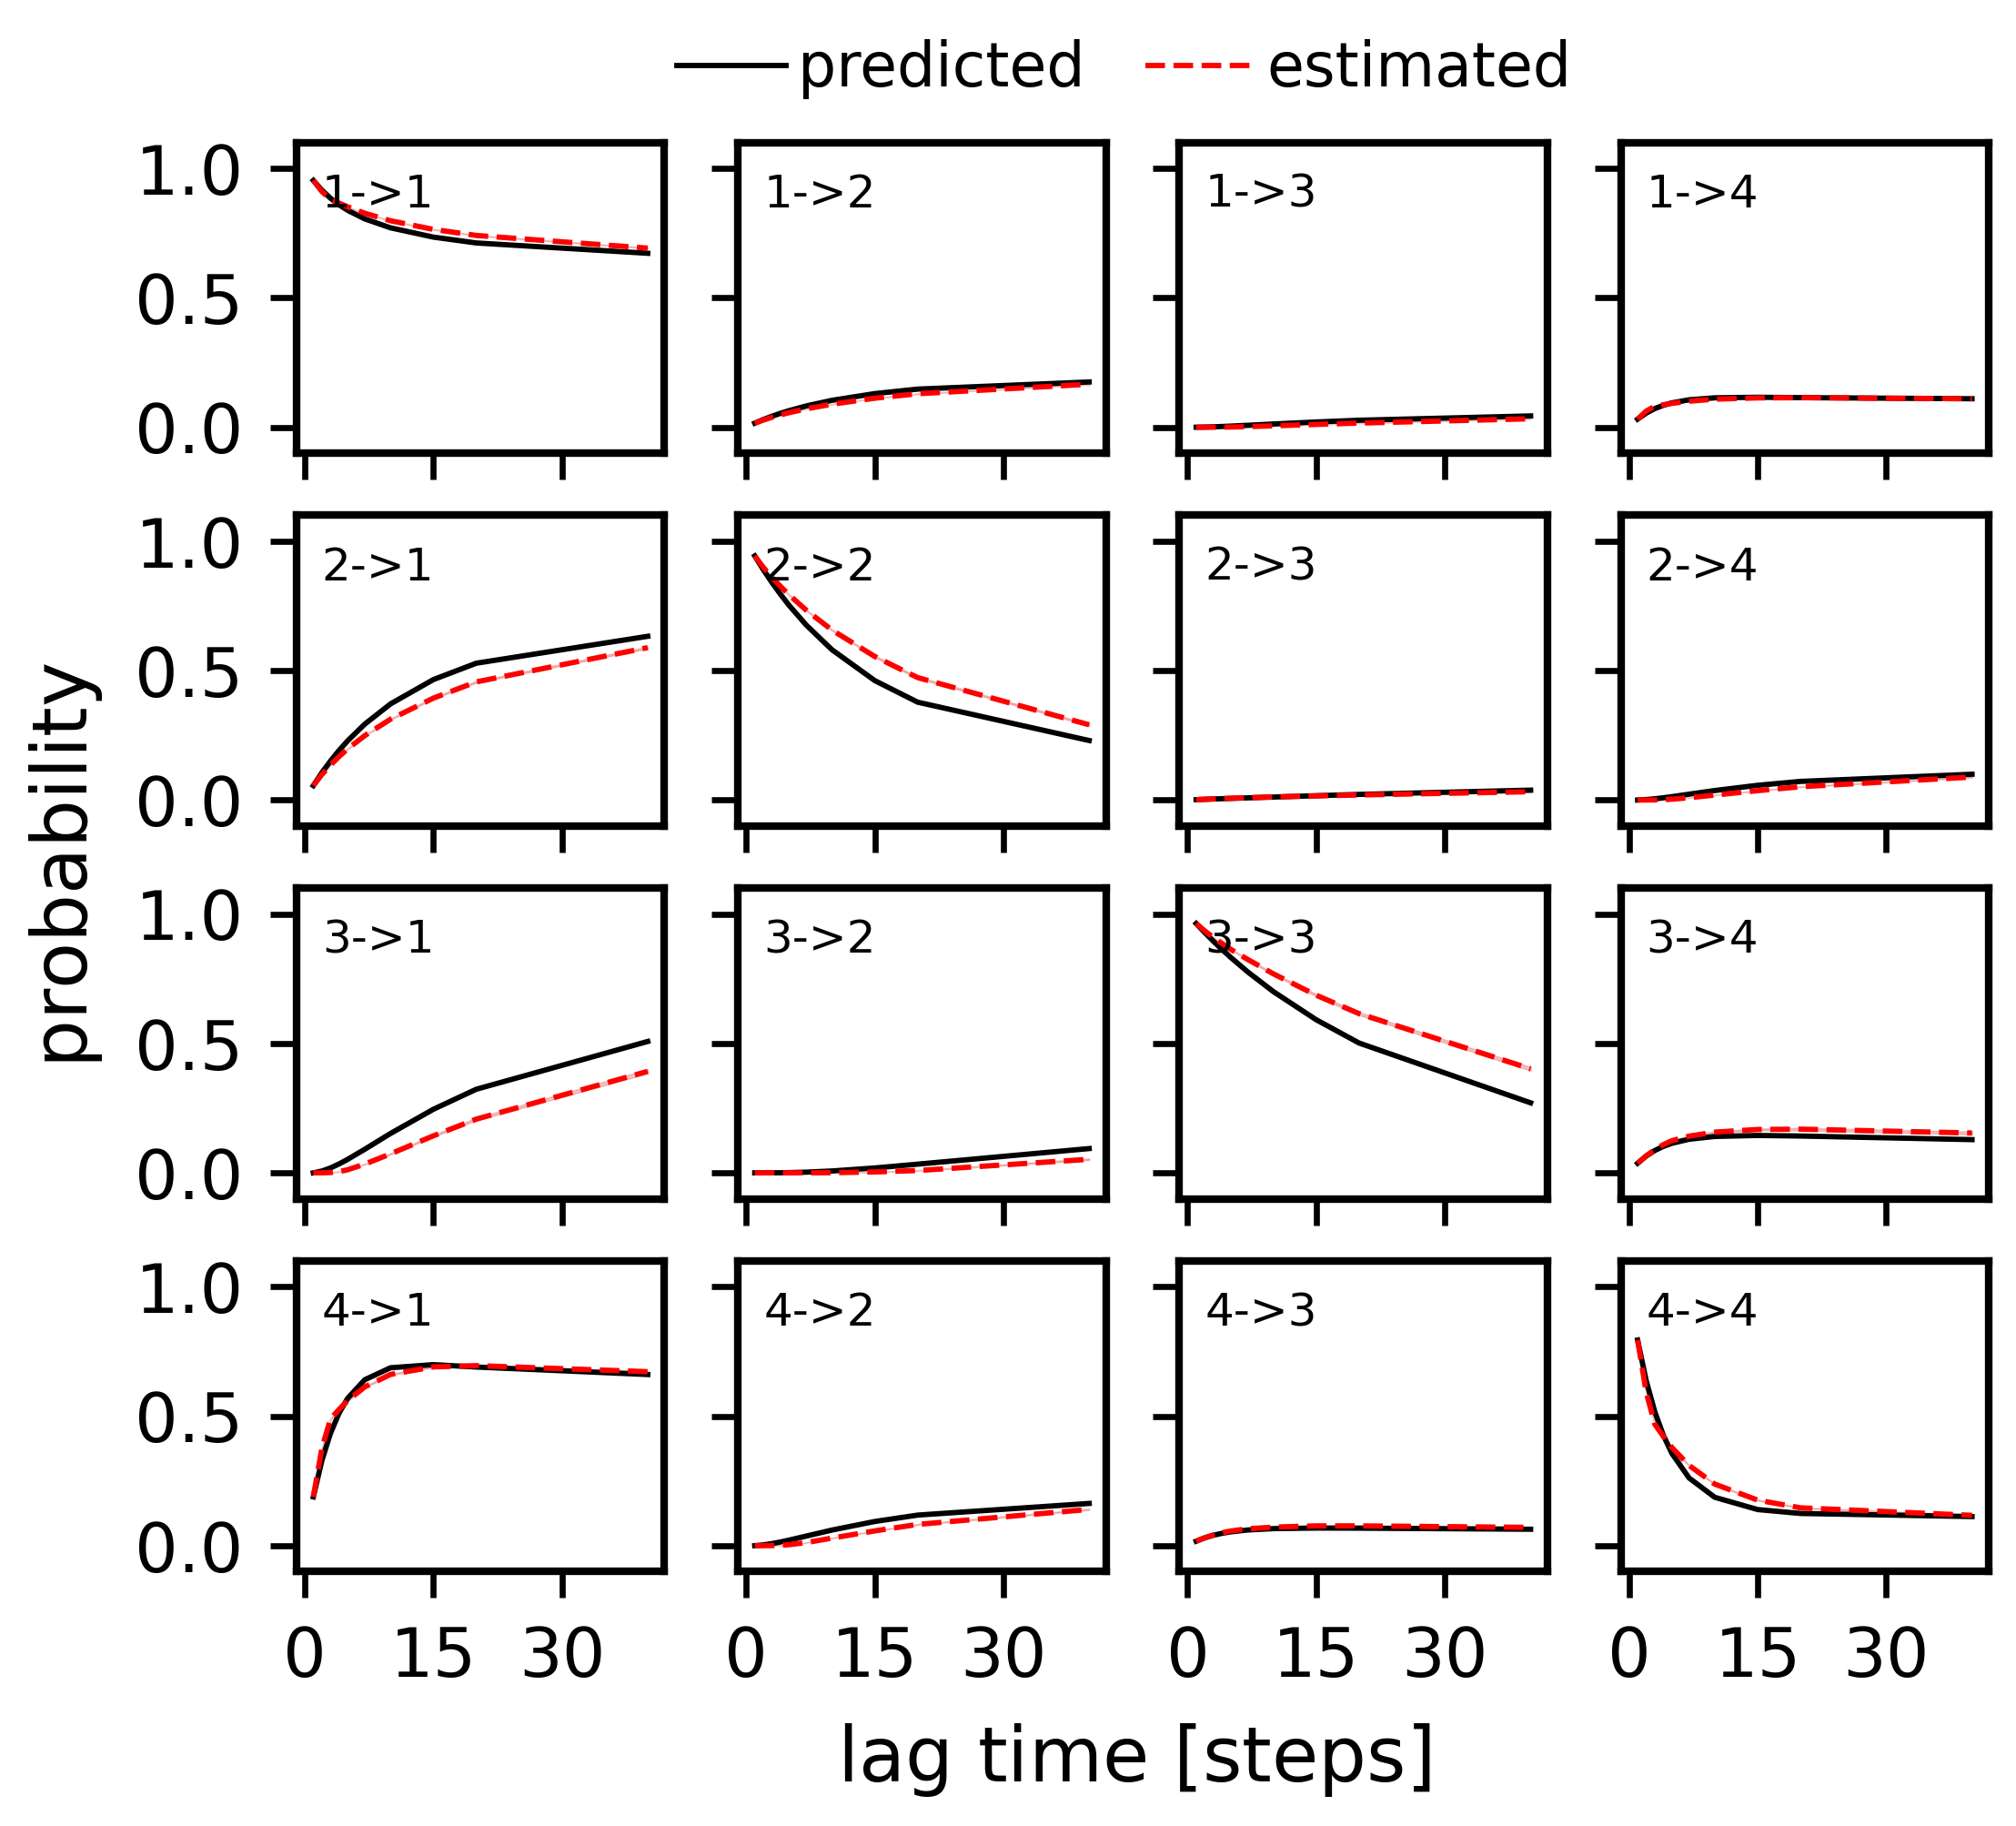

In [843]:
fig, ax = plt.subplots(4,4, figsize=(4,3.4), sharex=True, sharey=True)
type(ax)

plt.yticks([0.0,0.5,1.0],[0.0,0.5,1.0])
plt.xticks([0,15,30],[0,15,30])
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

for i in range(4):
    for j in range(4):
        ax[i,j].plot(lagtimes, pred_ck[:,i,j], 'k', linewidth=0.7, label='predicted')
        ax[i,j].plot(lagtimes, est_ck[:,i,j], '--r', linewidth=0.7, label='estimated')
        ax[i,j].fill_between(lagtimes, est_ck[:,i,j]-est_err_ck[:,i,j], est_ck[:,i,j]+est_err_ck[:,i,j], alpha=0.25, color='tab:red', linewidth=0.2)
        ax[i,j].set_ylim(-0.1,1.1)
        ax[i,j].text(2,0.85, f'{i+1}->{j+1}', fontsize=6)

        if i==3 and j==1:
            ax[i,j].set_xlabel(r'$\qquad \qquad \qquad$ lag time [steps]')
        if i==2 and j==0:
            ax[i,j].set_ylabel(r'$\qquad \qquad \quad$ probability')
            ax[i,j].legend(loc=(1.,3.5), ncols=2)

#plt.savefig(path_simple_pl+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/ck-test_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_{rdump}k{vampnet}.png', dpi=1200)
plt.savefig(path_mc+f'ck-test_ser19_dmu-{dmu}_1-tdp43-5pser_com-ck1d-open_CAL3_10k_MCkin{vampnet}.png', dpi=1200)


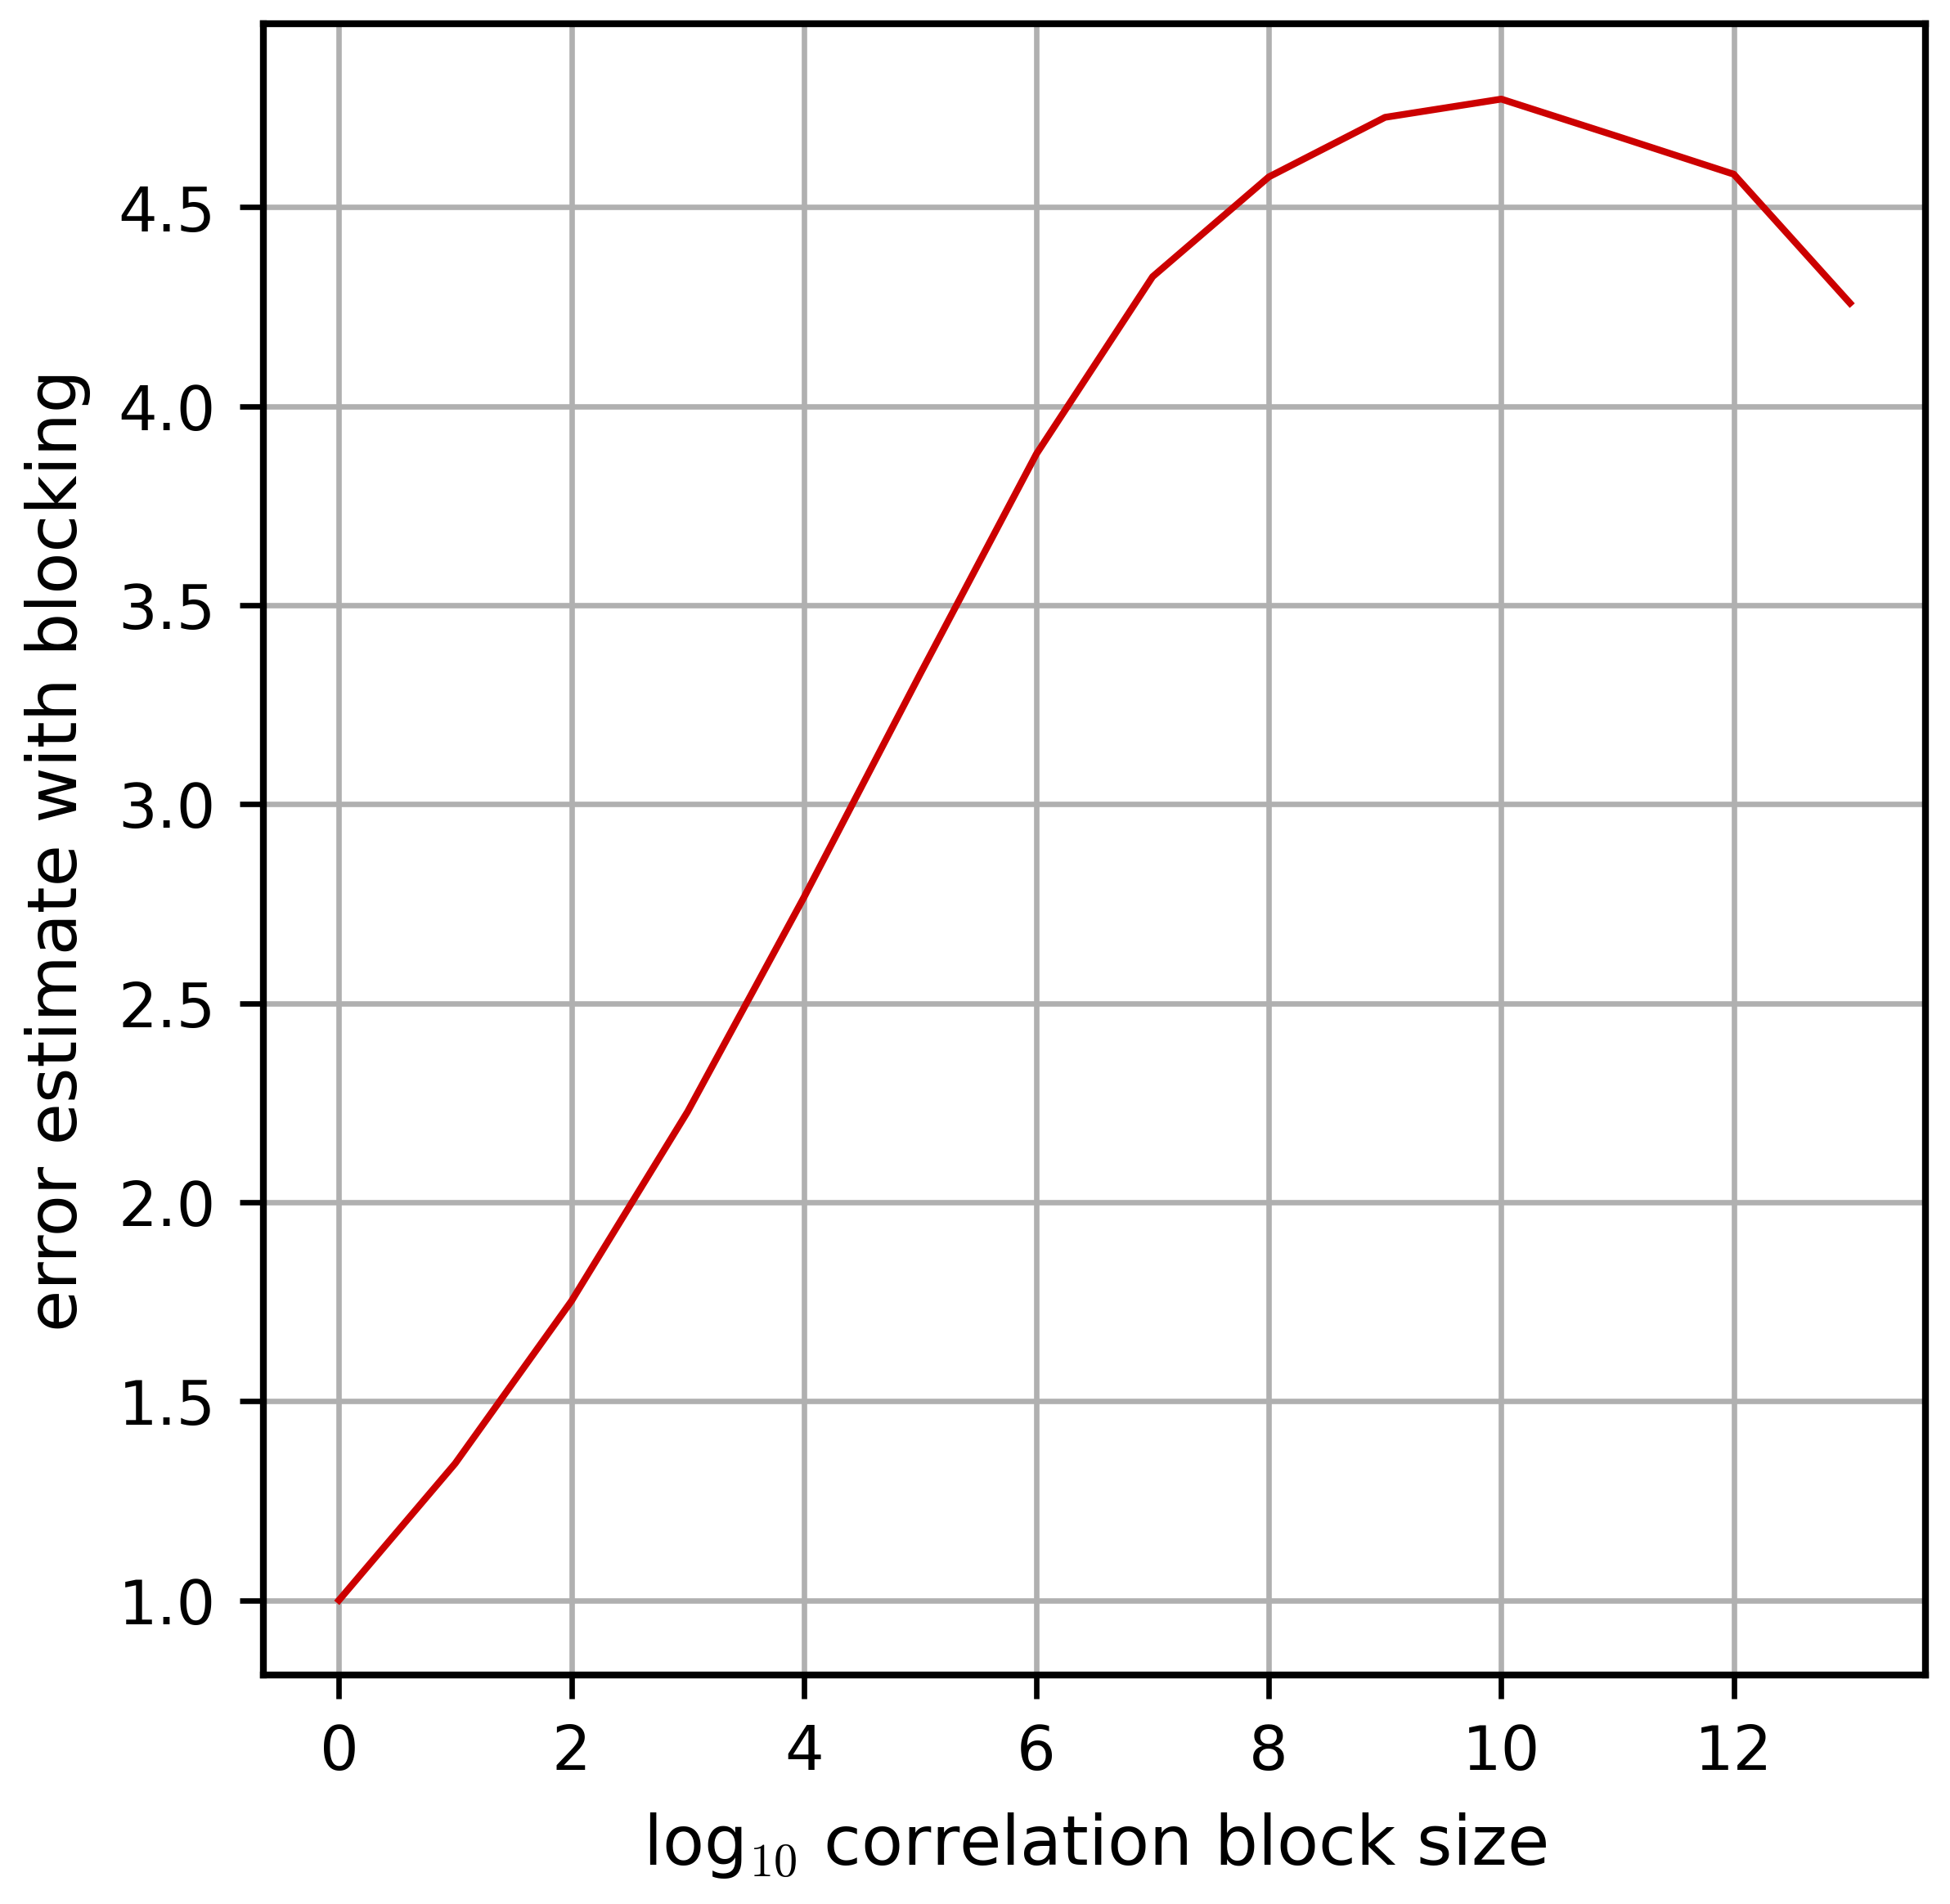

In [844]:
hpa.util.autocorr_bin(states, 14, 1000)


In [845]:
dmus = [hpa.msm.dmu_estimate(states, lag=t, n_term=1000) for t in range(3,15,1)]
dmus

100%|███████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 7712.24it/s]
/localscratch/zippoema/git/HPA/src/hpa/msm.py:235: RuntimeWarning: divide by zero encountered in scalar divide
  return kT*np.log(cycle/anti_cycle)
100%|███████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 7746.43it/s]


[inf,
 inf,
 inf,
 16.849224917371245,
 15.448813196589873,
 12.795384592200035,
 11.623642545963385,
 10.916168252525672,
 10.002808112457865,
 9.260669717732869,
 8.441425507588049,
 7.66515228059537]

In [846]:
dmu_lag = hpa.msm.dmu_estimate(states, lag=10, n_term=1000)
sigma_dmu = hpa.msm.bootstrap_dmu_estimate(states, lag=10, pow_bin=9, n_resample=30, n_term=1000)

100%|███████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 7771.84it/s]


In [847]:
dmu_lag, sigma_dmu

(10.916168252525672, 0.4424123299679525)

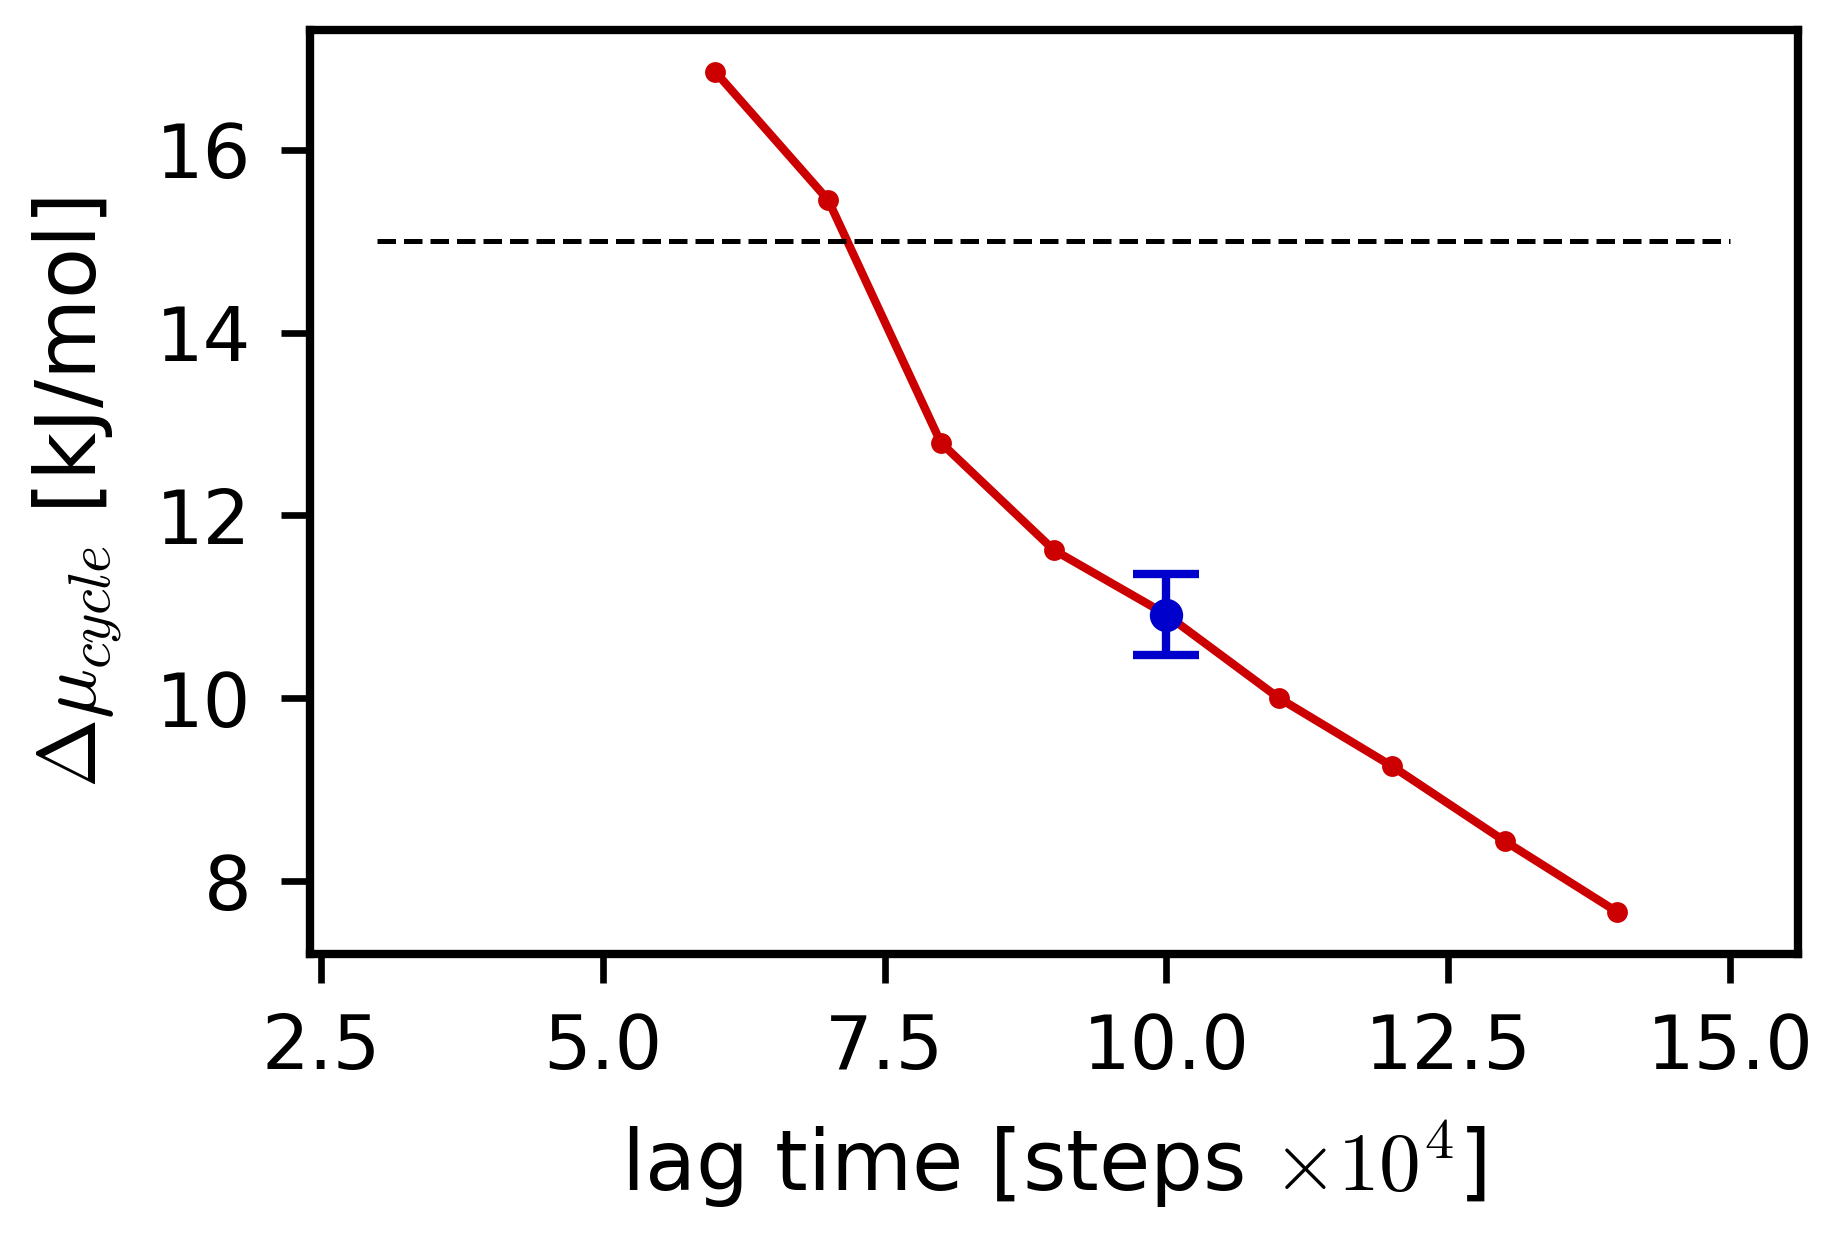

In [848]:
fig, ax = plt.subplots(1, 1, figsize=(3.2,2))

ax.plot(range(3,15,1), dmus, '.-')
ax.errorbar([10],[dmu_lag],[sigma_dmu], fmt='o', capsize=4)
ax.set_xlabel(r'lag time [steps $\times 10^4$]')
ax.set_ylabel(r'$\Delta \mu_{cycle}$ [kJ/mol]')
ax.plot([3,15],[dmu,dmu], '--k', lw=0.6)
#ax.set_ylim(15,42)

#plt.savefig(path_simple_pl+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/dmu_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_{rdump}k{vampnet}.png', dpi=1200)
plt.savefig(path_mc+f'dmu_ser19_dmu-{dmu}_1-tdp43-5pser_com-ck1d-open_CAL3_10k_MCkin{vampnet}.png', dpi=1200)


0.005175311373038802


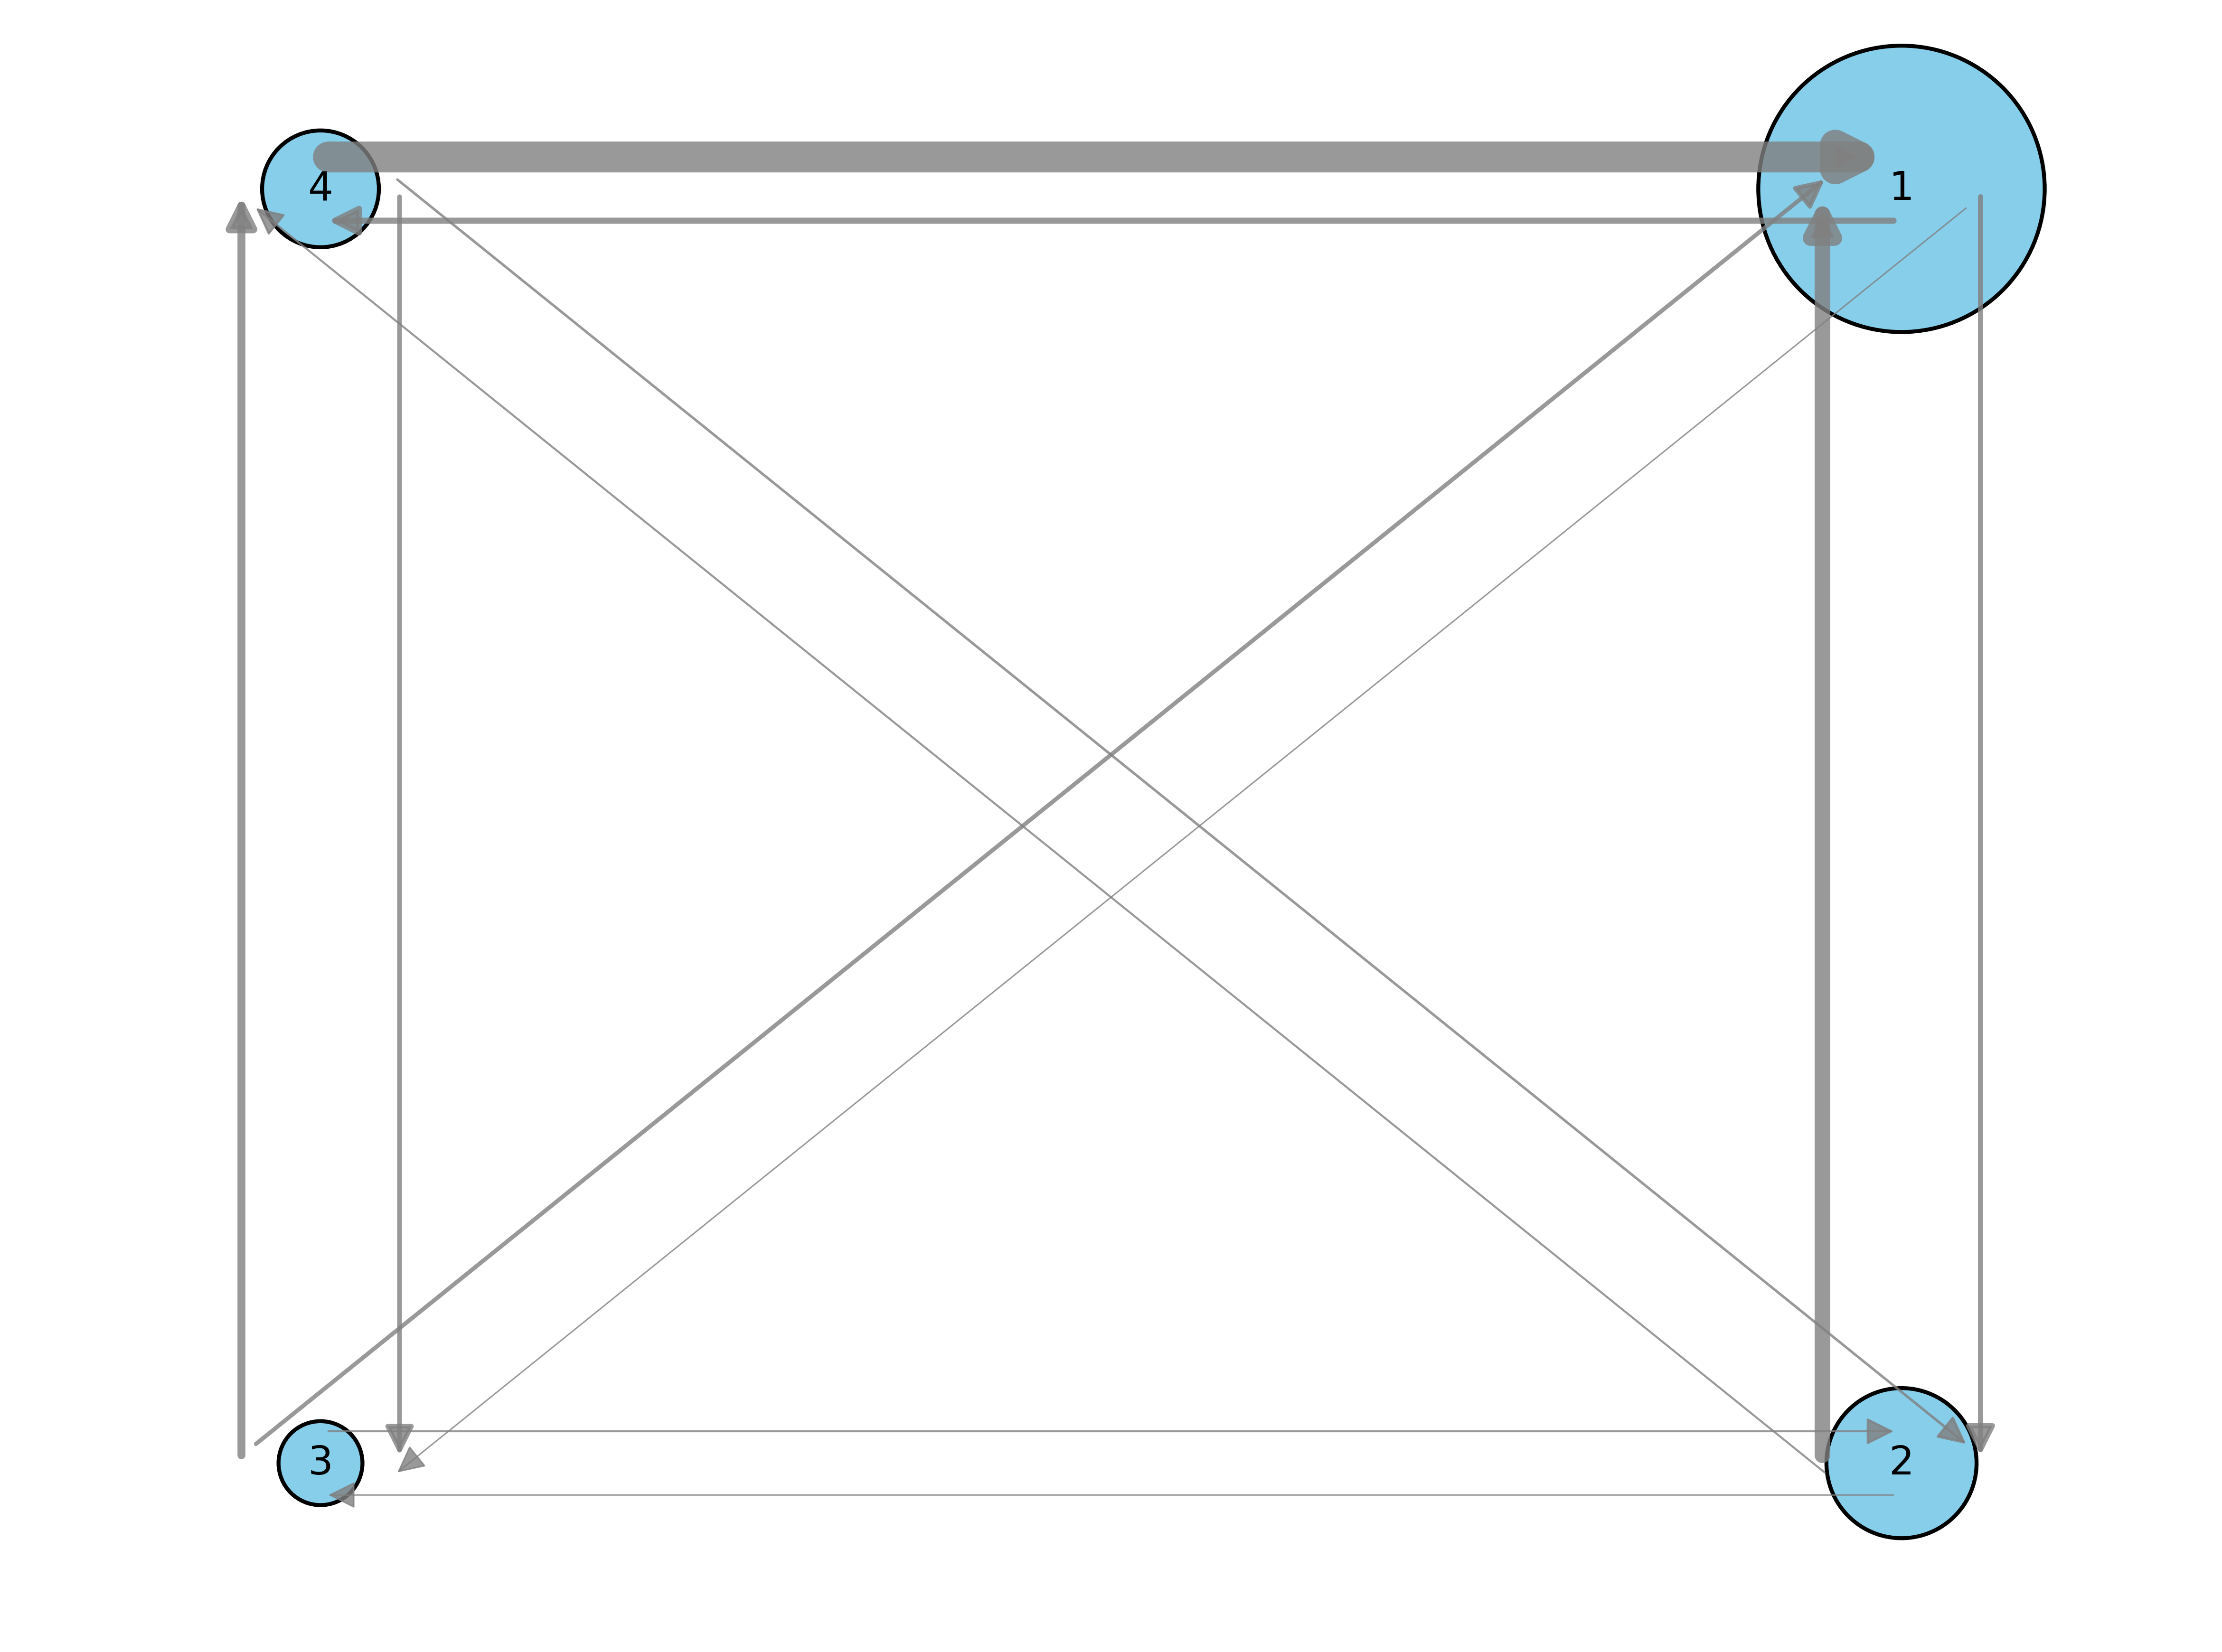

In [849]:
from matplotlib.patches import FancyArrowPatch


# Create a directed graph
G = nx.DiGraph()
st_distr = msm.gather_stats('stationary_distribution').mean

# Add nodes with size proportional to stationary distribution
for i in range(4):
    G.add_node(i, size=st_distr[i])

# Add edges (no self-loops) with weight proportional to transition probabilities
for i in range(4):
    for j in range(4):
        if i != j and tr_mat[i, j] > 1e-4:
            G.add_edge(i, j, weight=tr_mat[i, j])
print(G[1][2]['weight'])
# Start plot
fig, ax = plt.subplots(figsize=(8, 6))

# Position the nodes using spring layout
positions = np.array([(1,1),(1,-1),(0,-1),(0,1)])/100
pos = dict()
label_dict = dict()
for i in range(4):
    pos[i] = positions[i]
    label_dict[i] = f"{i+1}"

# Draw nodes with size scaled
node_sizes = [8000 * G.nodes[i]['size'] for i in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', edgecolors='k')
nx.draw_networkx_labels(G, pos, labels=label_dict , font_size=10, font_color='black')

# Normalize edge weights
weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(weights)

# Track already drawn pairs to offset one of the two directions
drawn_pairs = set()

def draw_straight_offset_edge(ax, src, dst, weight, offset_scale=0.0005, color='gray'):
    p1 = np.array(pos[src])
    p2 = np.array(pos[dst])
    vec = p2 - p1
    # Perpendicular unit vector
    perp = np.array([-vec[1], vec[0]])
    perp /= np.linalg.norm(perp)
    
    offset = offset_scale * perp

    # Offset positions
    p1_off = p1 + offset
    p2_off = p2 + offset

    # Draw straight arrow with offset
    arrow = FancyArrowPatch(
        p1_off, p2_off,
        arrowstyle='-|>',
        mutation_scale=15,
        lw=3 * weight,
        color=color,
        alpha=0.8,
        zorder=2
    )
    ax.add_patch(arrow)
    drawn_pairs.add((src, dst))
    
# Draw edges manually with curvature to avoid overlap
def draw_curved_edge(ax, pos, src, dst, weight, color='gray', rad=0.2, special=False):
    if special:
        # Special styling for edge 4 → 7
        rad = 0.5
        color = 'crimson'
    arrow = FancyArrowPatch(
        pos[src], pos[dst],
        connectionstyle=f"arc3,rad={rad}",
        arrowstyle='-|>',
        mutation_scale=15,
        lw=3 * weight,
        color=color,
        alpha=0.8,
        zorder=2
    )
    ax.add_patch(arrow)

# Draw edges
for u, v in G.edges():
    raw_weight = G[u][v]['weight']
    weight = 0.1 + 2.5 * (raw_weight / max_weight)  # Ensures visibility
#    if {u, v} == {3, 7}:  # Edge between 3 and 7 in either direction
#        rad = 0.3
#        draw_curved_edge(ax, pos, u, v, weight, rad=2.7*rad)
#    elif {u, v} == {1, 2} or {u, v} == {5, 6}:
#        rad = 0.3 
#        draw_curved_edge(ax, pos, u, v, weight, rad=rad)
#    else:
#        draw_straight_offset_edge(ax, u, v, weight)
    draw_straight_offset_edge(ax, u, v, weight)


# Final plot adjustments
plt.axis('off')
plt.tight_layout()

#plt.savefig(path_simple_pl+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/cycle_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_{rdump}k{vampnet}.png', dpi=1200)
plt.savefig(path_mc+f'cycle_ser19_dmu-{dmu}_1-tdp43-5pser_com-ck1d-open_CAL3_10k_MCkin{vampnet}.png', dpi=1200)


### CALVADOS3 3 states

In [227]:
rdump = 5
rigid = ''
dmu = 5

In [258]:
states = np.array([], dtype=int)
for s in range(1,11):
    #tmp = np.loadtxt(path_an+f'sim{s}_ser19_dmu-5_0_1-tdp43-2pser_com-ck1d-open_com-pp3_CAL3_states.txt').astype(int)
    #tmp = np.loadtxt(path_simple_an+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k_states.txt').astype(int)
    tmp = np.loadtxt(path_simple_an+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/sim{s}_ser19_dmu-{dmu}_1-tdp43-5pser_com-{rigid}ck1d-open_CAL3_{rdump}k_VAMPnet_states.txt').astype(int)
    states = np.append(states, tmp)

print(np.max(states), np.min(states))
len(states)

4 1


2000000

In [259]:
states[states==4] = 1
print(np.max(states), np.min(states))
len(states)

3 1


2000000

In [260]:
models = []
lagtimes = [1,2,3,4,5,10,15,20,30]
for lagtime in lagtimes:
    counts = markov.TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(states-1)
    models.append(markov.msm.BayesianMSM(n_samples=100, n_steps=20).fit_fetch(counts))

### Implied timescales

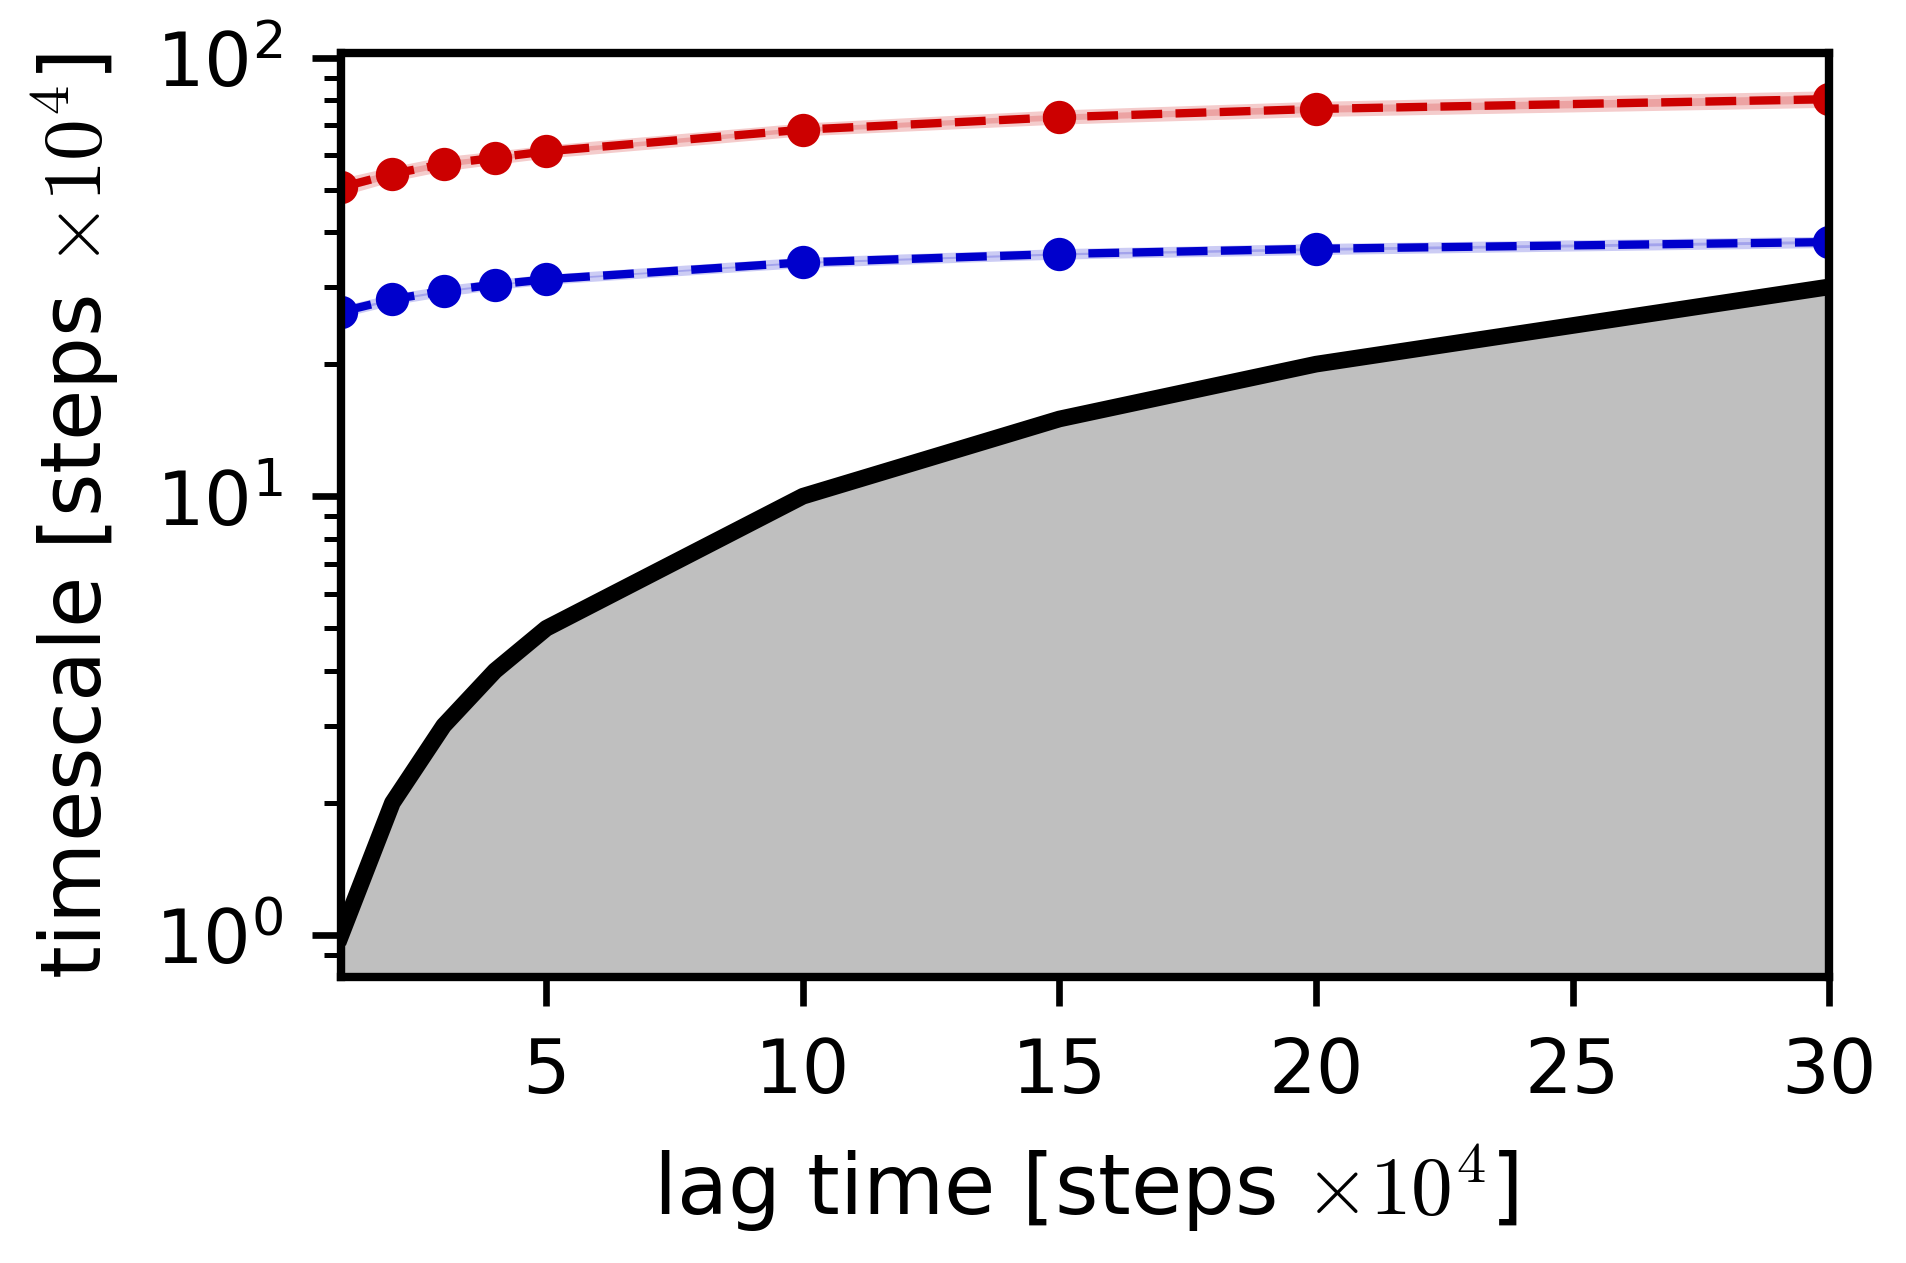

In [261]:
its_data = implied_timescales(models)

fig, ax = plt.subplots(1, 1, figsize=(3.2,2))

plot_implied_timescales(its_data, ax=ax, show_mle=False, sample_confidence=.68)
ax.set_yscale('log')
ax.set_xlabel(r'lag time [steps $\times 10^4$]')
ax.set_ylabel(r'timescale [steps $\times 10^4$]')
ax.set_xlim(lagtimes[0],lagtimes[-1])
#plt.savefig(path_simple_an+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/its_3states_ser19_dmu-{dmu_p}_1-tdp43-5pser_com-{rigid}ck1d-open_{rdump}k.png', dpi=1200)
plt.savefig(path_simple_an+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/its_3states_ser19_dmu-{dmu_p}_1-tdp43-5pser_com-{rigid}ck1d-open_{rdump}k_VAMPnet.png', dpi=1200)


### Chapman-Kolmogorov test

In [262]:
# model with lagtime 10
pred_ck, est_ck, est_err_ck = ck_test(states, lagtimes, reversible=False)

In [263]:
counts = markov.TransitionCountEstimator(lagtime=5, count_mode='effective').fit_fetch(states-1)
msm = markov.msm.BayesianMSM(n_samples=100, n_steps=20).fit_fetch(counts)

tr_mat = msm.gather_stats('transition_matrix').mean
tr_mat

array([[9.66411059e-01, 2.86464468e-02, 4.94249418e-03],
       [1.17088457e-01, 8.82701761e-01, 2.09781990e-04],
       [7.47657086e-02, 7.76451279e-04, 9.24457840e-01]])

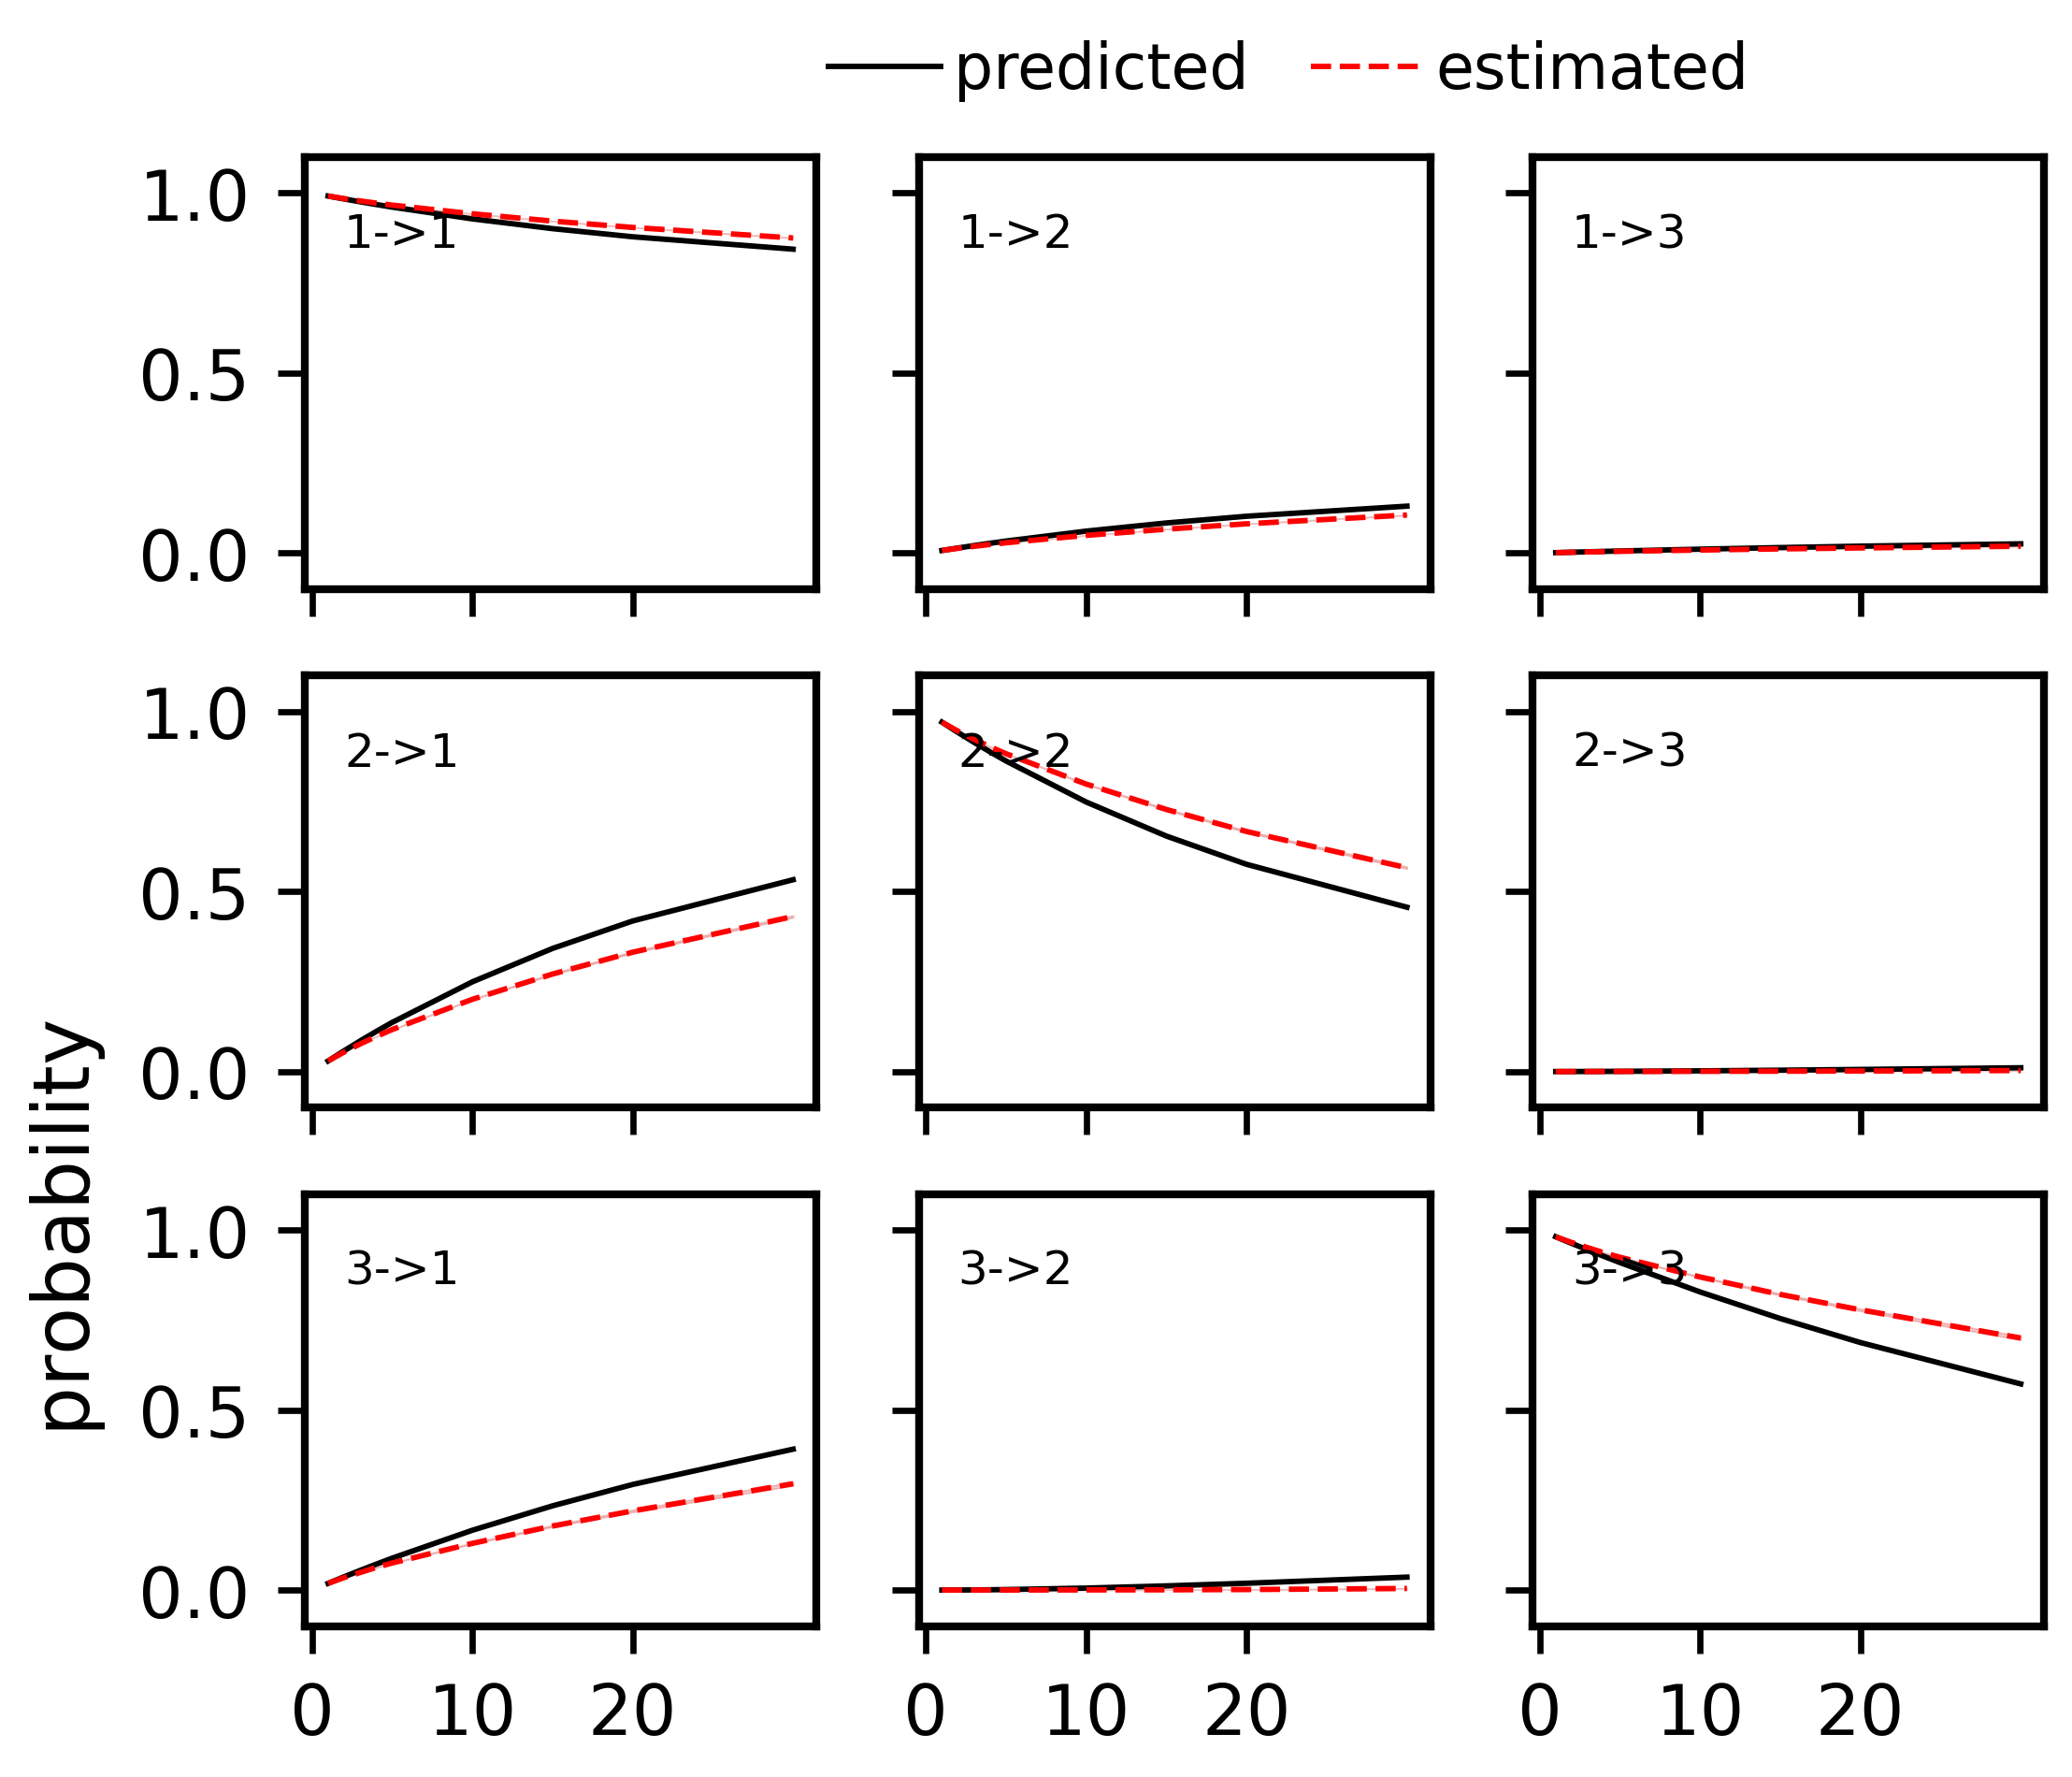

In [264]:
fig, ax = plt.subplots(3,3, figsize=(4,3.4), sharex=True, sharey=True)
type(ax)

plt.yticks([0.0,0.5,1.0],[0.0,0.5,1.0])
plt.xticks([0,10,20],[0,10,20])
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

for i in range(3):
    for j in range(3):
        ax[i,j].plot(lagtimes, pred_ck[:,i,j], 'k', linewidth=0.7, label='predicted')
        ax[i,j].plot(lagtimes, est_ck[:,i,j], '--r', linewidth=0.7, label='estimated')
        ax[i,j].fill_between(lagtimes, est_ck[:,i,j]-est_err_ck[:,i,j], est_ck[:,i,j]+est_err_ck[:,i,j], alpha=0.25, color='tab:red', linewidth=0.2)
        ax[i,j].set_ylim(-0.1,1.1)
        ax[i,j].text(2,0.85, f'{i+1}->{j+1}', fontsize=6)

        if i==3 and j==1:
            ax[i,j].set_xlabel(r'$\qquad \qquad \qquad$ lag time [steps]')
        if i==2 and j==0:
            ax[i,j].set_ylabel(r'$\qquad \qquad \quad$ probability')
            ax[i,j].legend(loc=(1.,3.5), ncols=2)

#plt.savefig(path_simple_an+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/ck-test_3states_ser19_dmu-{dmu_p}_1-tdp43-5pser_com-{rigid}ck1d-open_{rdump}k.png', dpi=1200)
plt.savefig(path_simple_an+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/ck-test_3states_ser19_dmu-{dmu_p}_1-tdp43-5pser_com-{rigid}ck1d-open_{rdump}k_VAMPnet.png', dpi=1200)


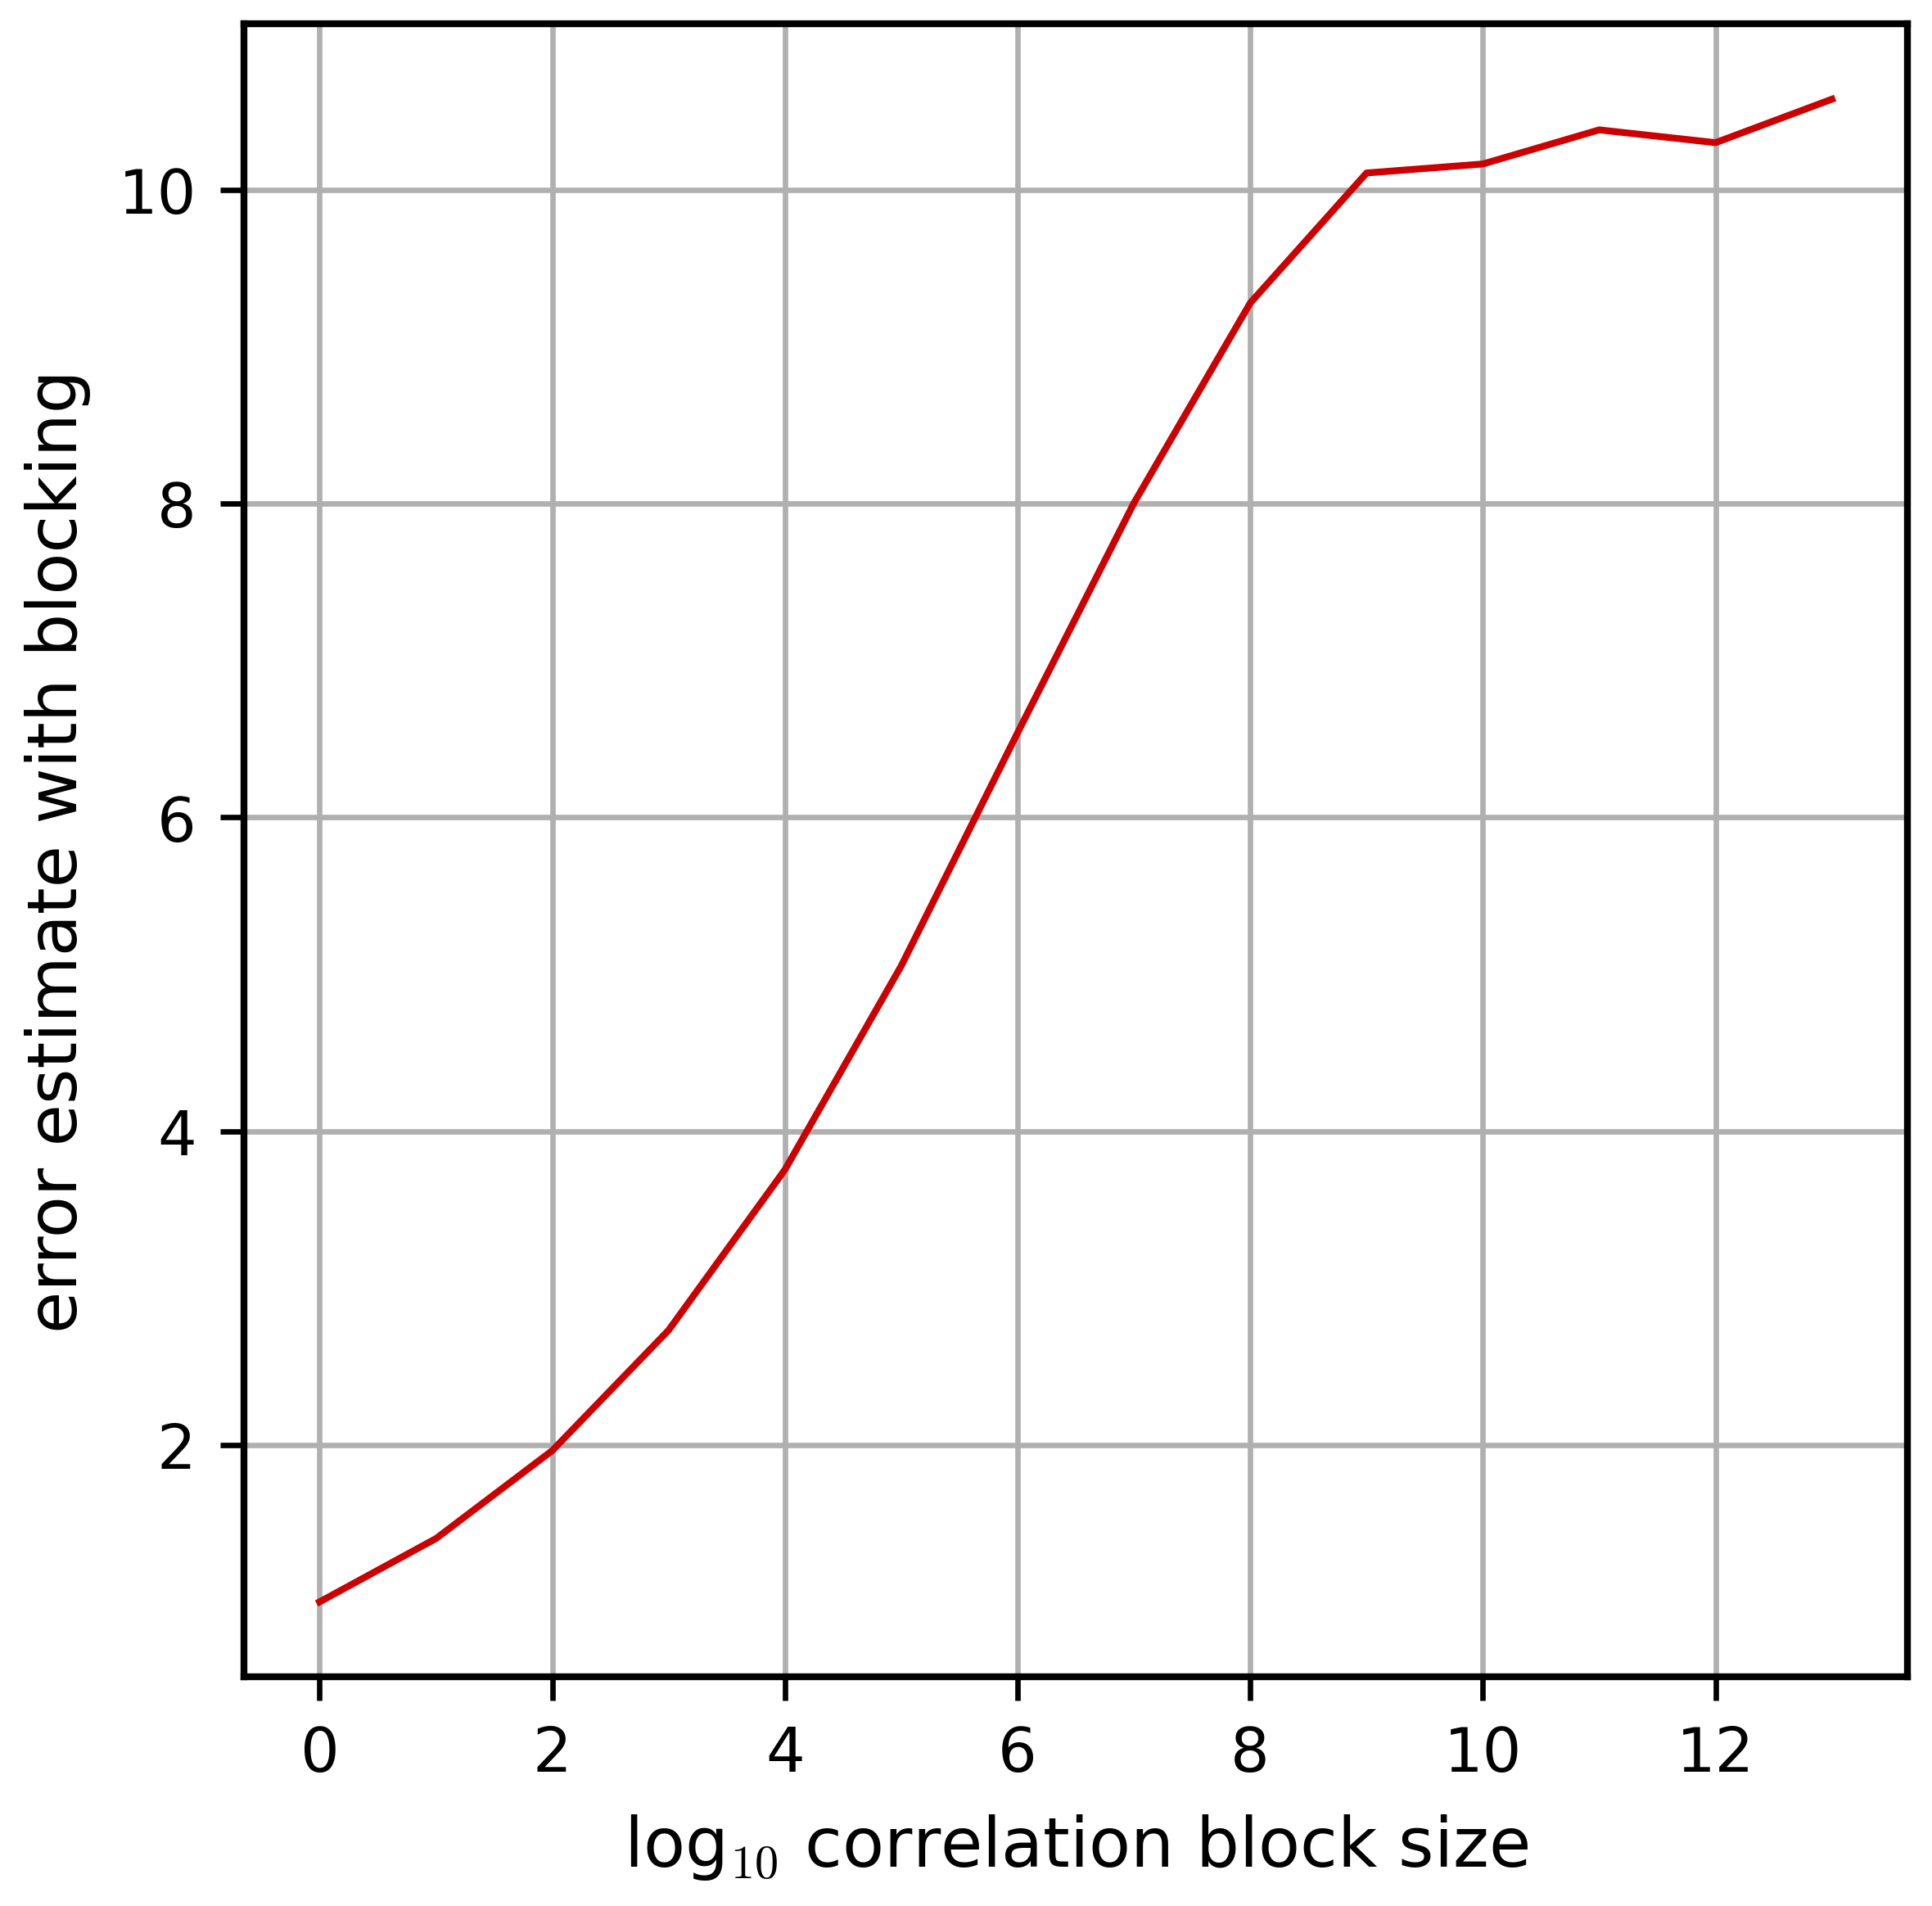

In [265]:
hpa.util.autocorr_bin(states, 14, 1000)


In [266]:
dmus = [hpa.msm.dmu_estimate(states, lag=t, n_term=1000) for t in range(1,15)]
dmus

100%|███████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 8487.23it/s]


[4.5080115485901775,
 4.511262595125706,
 4.513810657951517,
 4.472927456061432,
 4.431191109996369,
 4.321264783259535,
 4.383621421858902,
 4.3689844295198395,
 4.3026555347255435,
 4.2991873294722645,
 4.260442119323947,
 4.2211005827745565,
 4.152150809891614,
 4.094383800138996]

In [267]:
dmu_lag = hpa.msm.dmu_estimate(states, lag=10, n_term=1000)
sigma_dmu = hpa.msm.bootstrap_dmu_estimate(states, lag=10, pow_bin=10, n_resample=30, n_term=1000)

100%|███████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 8398.18it/s]


In [268]:
dmu_lag, sigma_dmu

(4.2991873294722645, 0.8144306688202181)

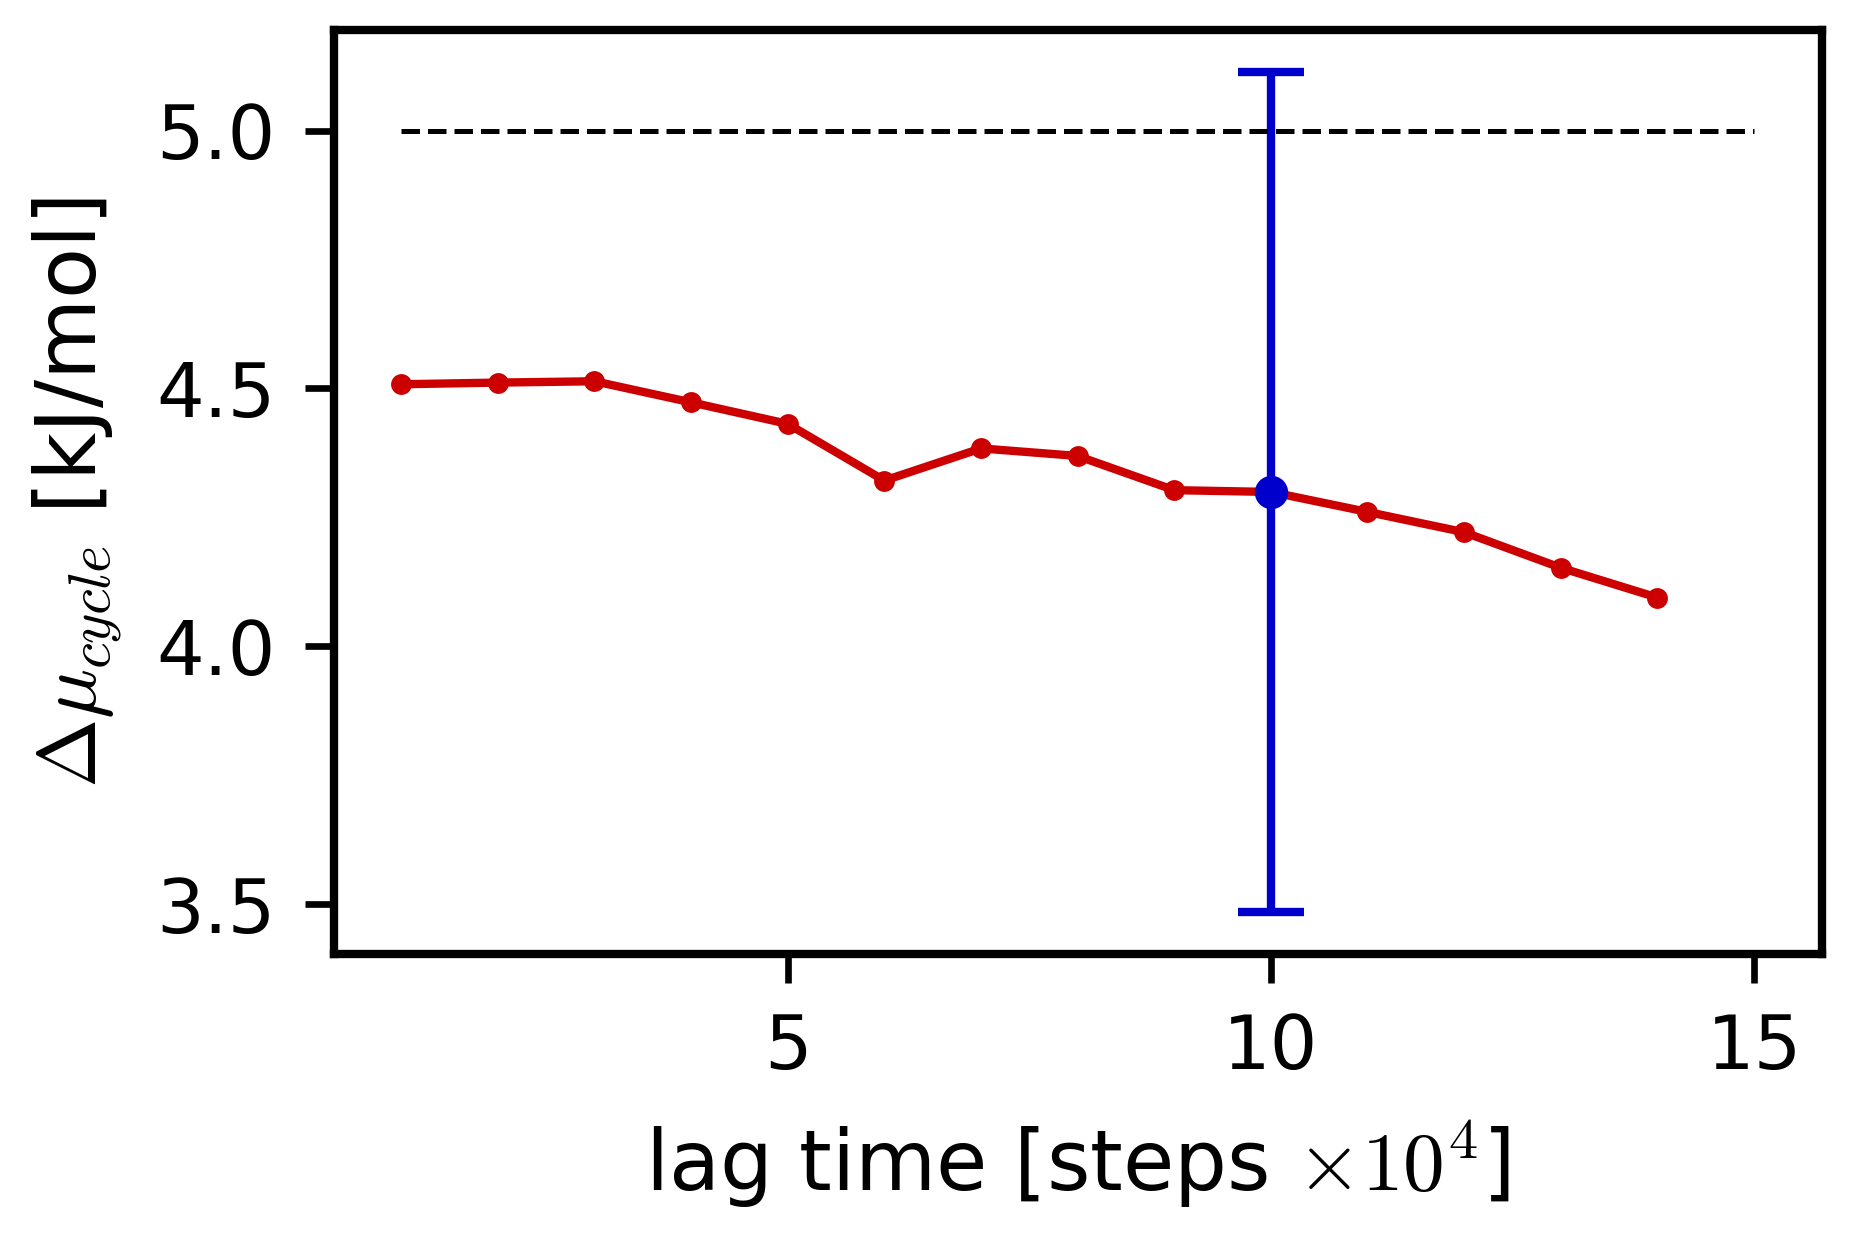

In [269]:
fig, ax = plt.subplots(1, 1, figsize=(3.2,2))

ax.plot(range(1,15), dmus, '.-')
ax.errorbar([10],[dmu_lag],[sigma_dmu], fmt='o', capsize=4)
ax.set_xlabel(r'lag time [steps $\times 10^4$]')
ax.set_ylabel(r'$\Delta \mu_{cycle}$ [kJ/mol]')
ax.plot([1,15],[dmu_p,dmu_p], '--k', lw=0.6)
#ax.set_ylim(15,42)
#plt.savefig(path_simple_an+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/dmu_3states_ser19_dmu-{dmu_p}_1-tdp43-5pser_com-{rigid}ck1d-open_{rdump}k.png', dpi=1200)
plt.savefig(path_simple_an+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/dmu_3states_ser19_dmu-{dmu_p}_1-tdp43-5pser_com-{rigid}ck1d-open_{rdump}k_VAMPnet.png', dpi=1200)

0.00020978198971590033


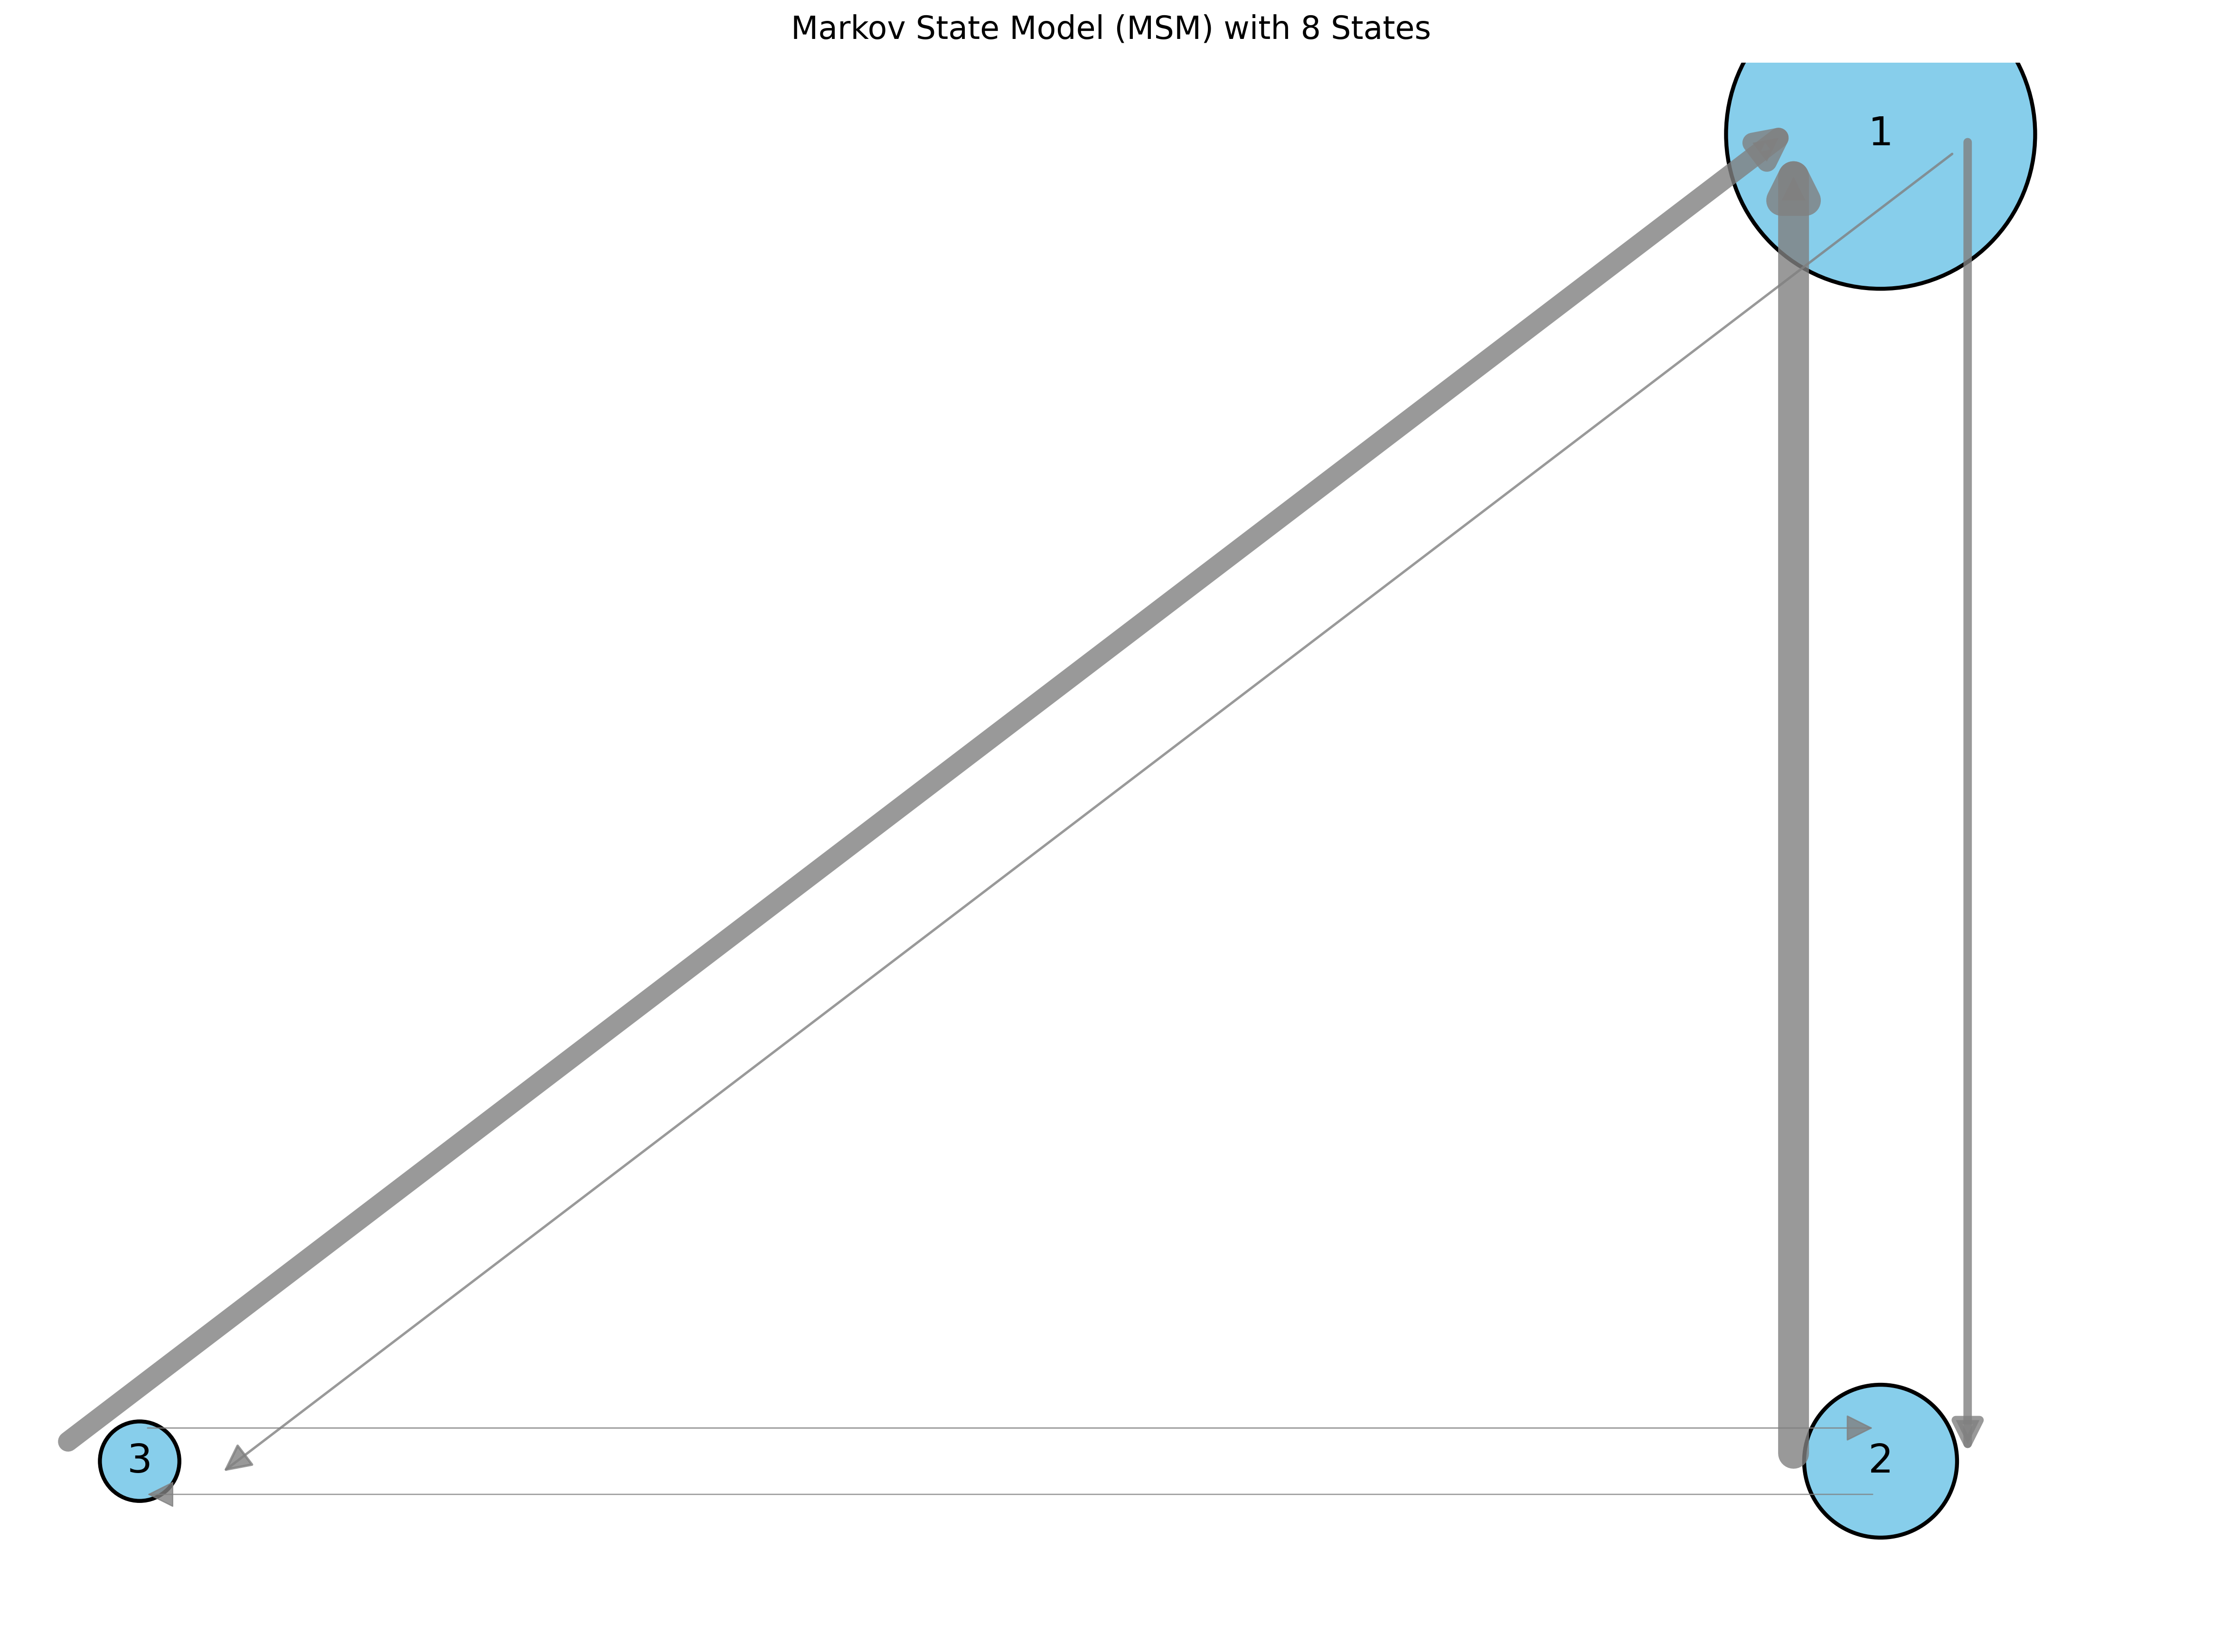

In [270]:
from matplotlib.patches import FancyArrowPatch


# Create a directed graph
G = nx.DiGraph()
st_distr = msm.gather_stats('stationary_distribution').mean

# Add nodes with size proportional to stationary distribution
for i in range(3):
    G.add_node(i, size=st_distr[i])

# Add edges (no self-loops) with weight proportional to transition probabilities
for i in range(3):
    for j in range(3):
        if i != j and tr_mat[i, j] > 1e-4:
            G.add_edge(i, j, weight=tr_mat[i, j])
print(G[1][2]['weight'])
# Start plot
fig, ax = plt.subplots(figsize=(8, 6))

# Position the nodes using spring layout
positions = np.array([(1,1),(1,-1),(0,-1),(0,1)])/100
pos = dict()
label_dict = dict()
for i in range(3):
    pos[i] = positions[i]
    label_dict[i] = f"{i+1}"

# Draw nodes with size scaled
node_sizes = [8000 * G.nodes[i]['size'] for i in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', edgecolors='k')
nx.draw_networkx_labels(G, pos, labels=label_dict , font_size=10, font_color='black')

# Normalize edge weights
weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(weights)

# Track already drawn pairs to offset one of the two directions
drawn_pairs = set()

def draw_straight_offset_edge(ax, src, dst, weight, offset_scale=0.0005, color='gray'):
    p1 = np.array(pos[src])
    p2 = np.array(pos[dst])
    vec = p2 - p1
    # Perpendicular unit vector
    perp = np.array([-vec[1], vec[0]])
    perp /= np.linalg.norm(perp)
    
    offset = offset_scale * perp

    # Offset positions
    p1_off = p1 + offset
    p2_off = p2 + offset

    # Draw straight arrow with offset
    arrow = FancyArrowPatch(
        p1_off, p2_off,
        arrowstyle='-|>',
        mutation_scale=15,
        lw=3 * weight,
        color=color,
        alpha=0.8,
        zorder=2
    )
    ax.add_patch(arrow)
    drawn_pairs.add((src, dst))
    
# Draw edges manually with curvature to avoid overlap
def draw_curved_edge(ax, pos, src, dst, weight, color='gray', rad=0.2, special=False):
    if special:
        # Special styling for edge 4 → 7
        rad = 0.5
        color = 'crimson'
    arrow = FancyArrowPatch(
        pos[src], pos[dst],
        connectionstyle=f"arc3,rad={rad}",
        arrowstyle='-|>',
        mutation_scale=15,
        lw=3 * weight,
        color=color,
        alpha=0.8,
        zorder=2
    )
    ax.add_patch(arrow)

# Draw edges
for u, v in G.edges():
    raw_weight = G[u][v]['weight']
    weight = 0.1 + 2.5 * (raw_weight / max_weight)  # Ensures visibility
#    if {u, v} == {3, 7}:  # Edge between 3 and 7 in either direction
#        rad = 0.3
#        draw_curved_edge(ax, pos, u, v, weight, rad=2.7*rad)
#    elif {u, v} == {1, 2} or {u, v} == {5, 6}:
#        rad = 0.3 
#        draw_curved_edge(ax, pos, u, v, weight, rad=rad)
#    else:
#        draw_straight_offset_edge(ax, u, v, weight)
    draw_straight_offset_edge(ax, u, v, weight)


# Final plot adjustments
plt.title('Markov State Model (MSM) with 8 States')
plt.axis('off')
plt.tight_layout()

#plt.savefig(path_simple_an+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/cycle_3states_ser19_dmu-{dmu_p}_1-tdp43-5pser_com-{rigid}ck1d-open_{rdump}k.png', dpi=1200)
plt.savefig(path_simple_an+f'sim_ser19_dmu-{dmu}_1-tdp43-5pser_1-{rigid}ck1d-open_{rdump}k/cycle_3states_ser19_dmu-{dmu_p}_1-tdp43-5pser_com-{rigid}ck1d-open_{rdump}k_VAMPnet.png', dpi=1200)


## MSM 6 states (fixed CK1d PP3)

In [52]:
states = np.array([], dtype=int)
for s in range(1,6):
    tmp = np.loadtxt(path_an+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/sim{s}_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_states_VAMPnet.txt').astype(int)
    states = np.append(states, tmp)

print(np.max(states), np.min(states))
states

6 1


array([1, 1, 1, ..., 1, 1, 1])

In [53]:
models = []
lagtimes = [1,2,3,5,10,20,35]
for lagtime in lagtimes:
    counts = markov.TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(states-1)
    models.append(markov.msm.BayesianMSM(n_samples=100, n_steps=20).fit_fetch(counts))

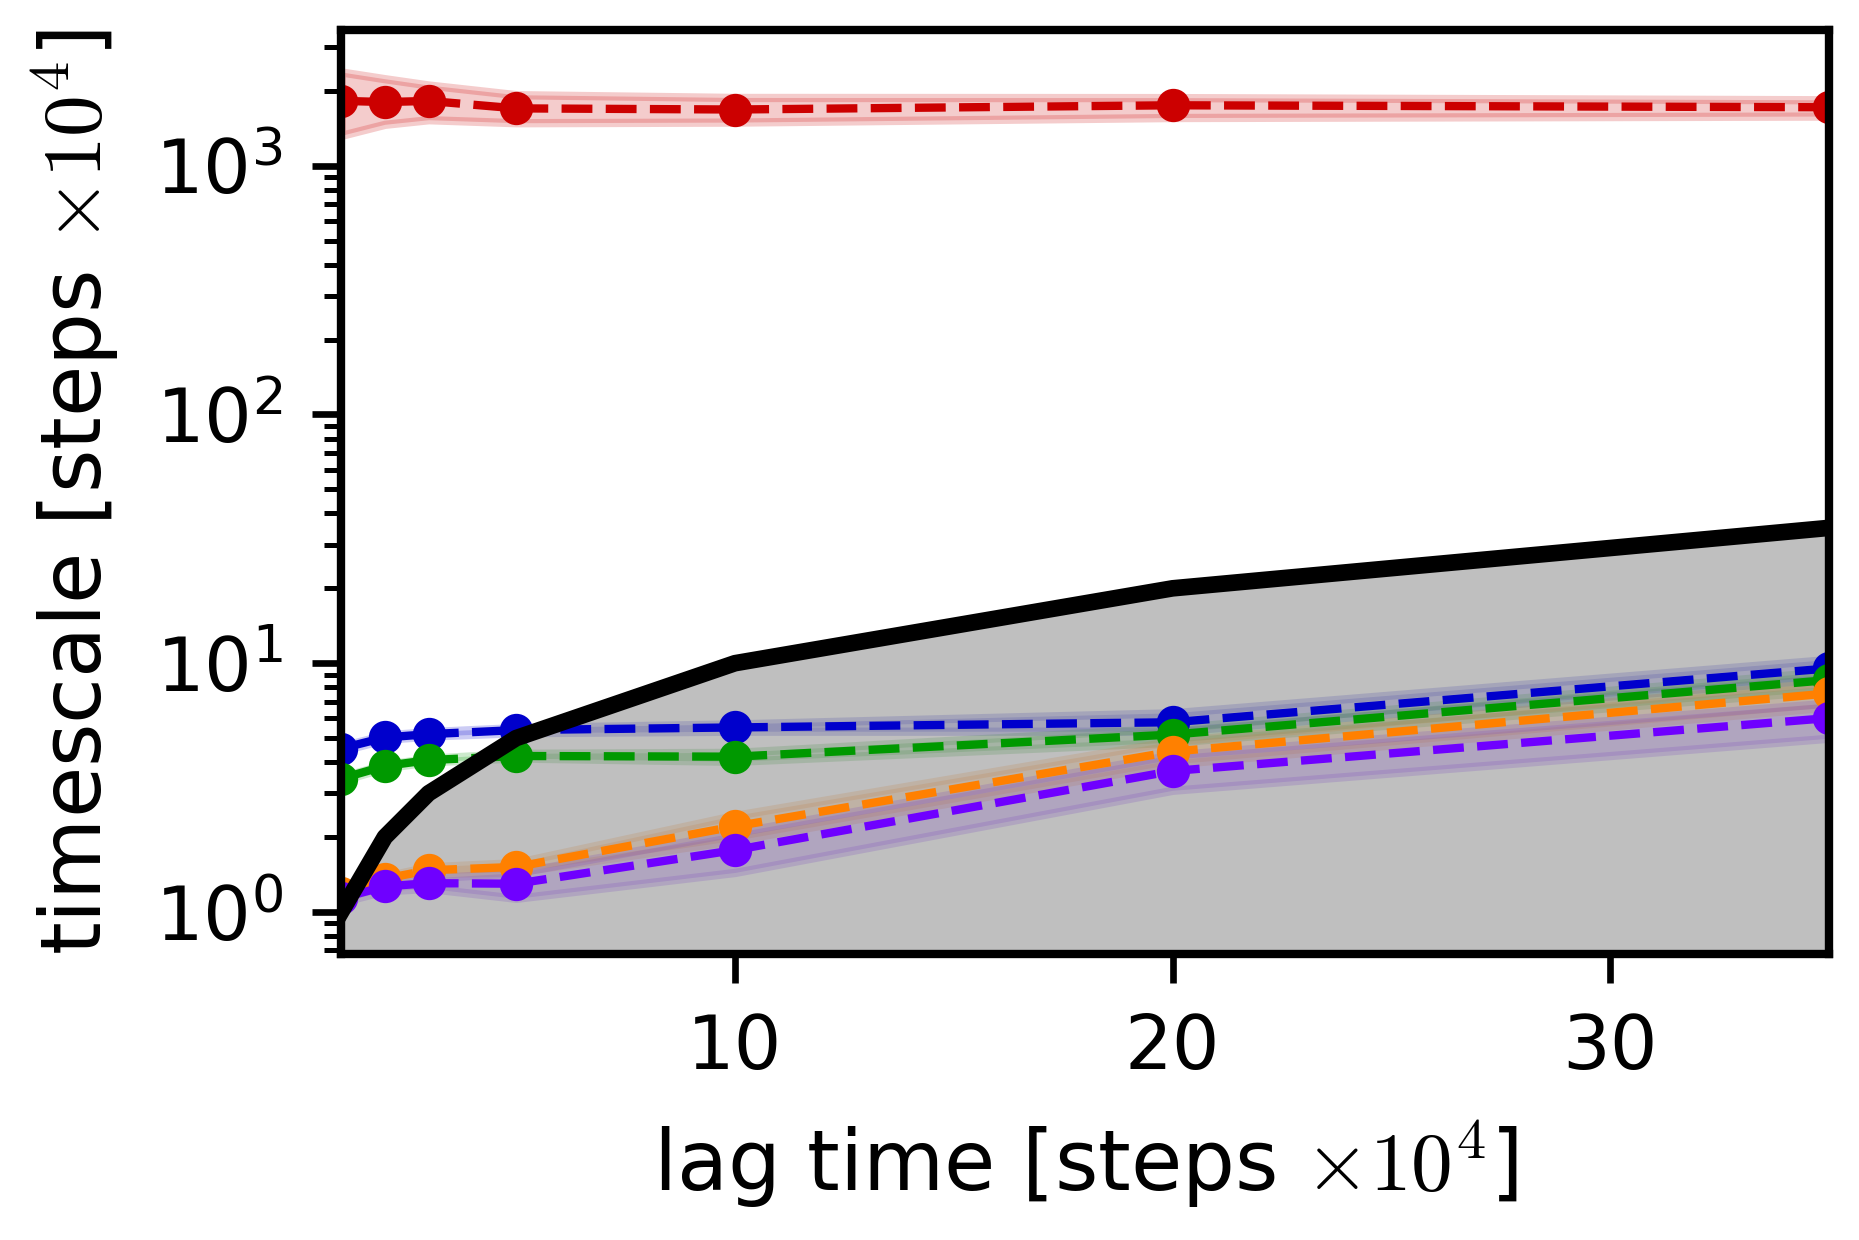

In [54]:
its_data = implied_timescales(models)

fig, ax = plt.subplots(1, 1, figsize=(3.2,2))

plot_implied_timescales(its_data, ax=ax, show_mle=False, sample_confidence=.68)
ax.set_yscale('log')
ax.set_xlabel(r'lag time [steps $\times 10^4$]')
ax.set_ylabel(r'timescale [steps $\times 10^4$]')
ax.set_xlim(1,35)
plt.savefig(path_an+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/its_6states_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_VAMPnet.png', dpi=1200)

### Chapman-Kolmogorov test

In [55]:
# model with lagtime 10
pred_ck, est_ck, est_err_ck = ck_test(states, lagtimes, reversible=False)

In [56]:
counts = markov.TransitionCountEstimator(lagtime=3, count_mode='effective').fit_fetch(states-1)
msm = markov.msm.BayesianMSM(n_samples=100, n_steps=20).fit_fetch(counts)

tr_mat = msm.gather_stats('transition_matrix').mean
tr_mat

array([[7.31295992e-01, 1.70060009e-01, 1.61032570e-05, 4.38312108e-05,
        9.80615290e-05, 9.84860032e-02],
       [3.65287923e-01, 6.17266511e-01, 1.16413973e-03, 2.38584036e-04,
        4.01472429e-05, 1.60026951e-02],
       [4.13893843e-05, 1.45819483e-03, 7.14661827e-01, 2.72133876e-01,
        1.17047127e-02, 0.00000000e+00],
       [7.83615362e-05, 1.96385157e-04, 1.78131750e-01, 7.20246503e-01,
        1.01241848e-01, 1.05152355e-04],
       [1.21869382e-03, 2.40518585e-04, 5.41077676e-02, 7.15011585e-01,
        2.27121410e-01, 2.30002481e-03],
       [6.90249916e-01, 5.22180664e-02, 0.00000000e+00, 4.13482002e-04,
        1.30208575e-03, 2.55816449e-01]])

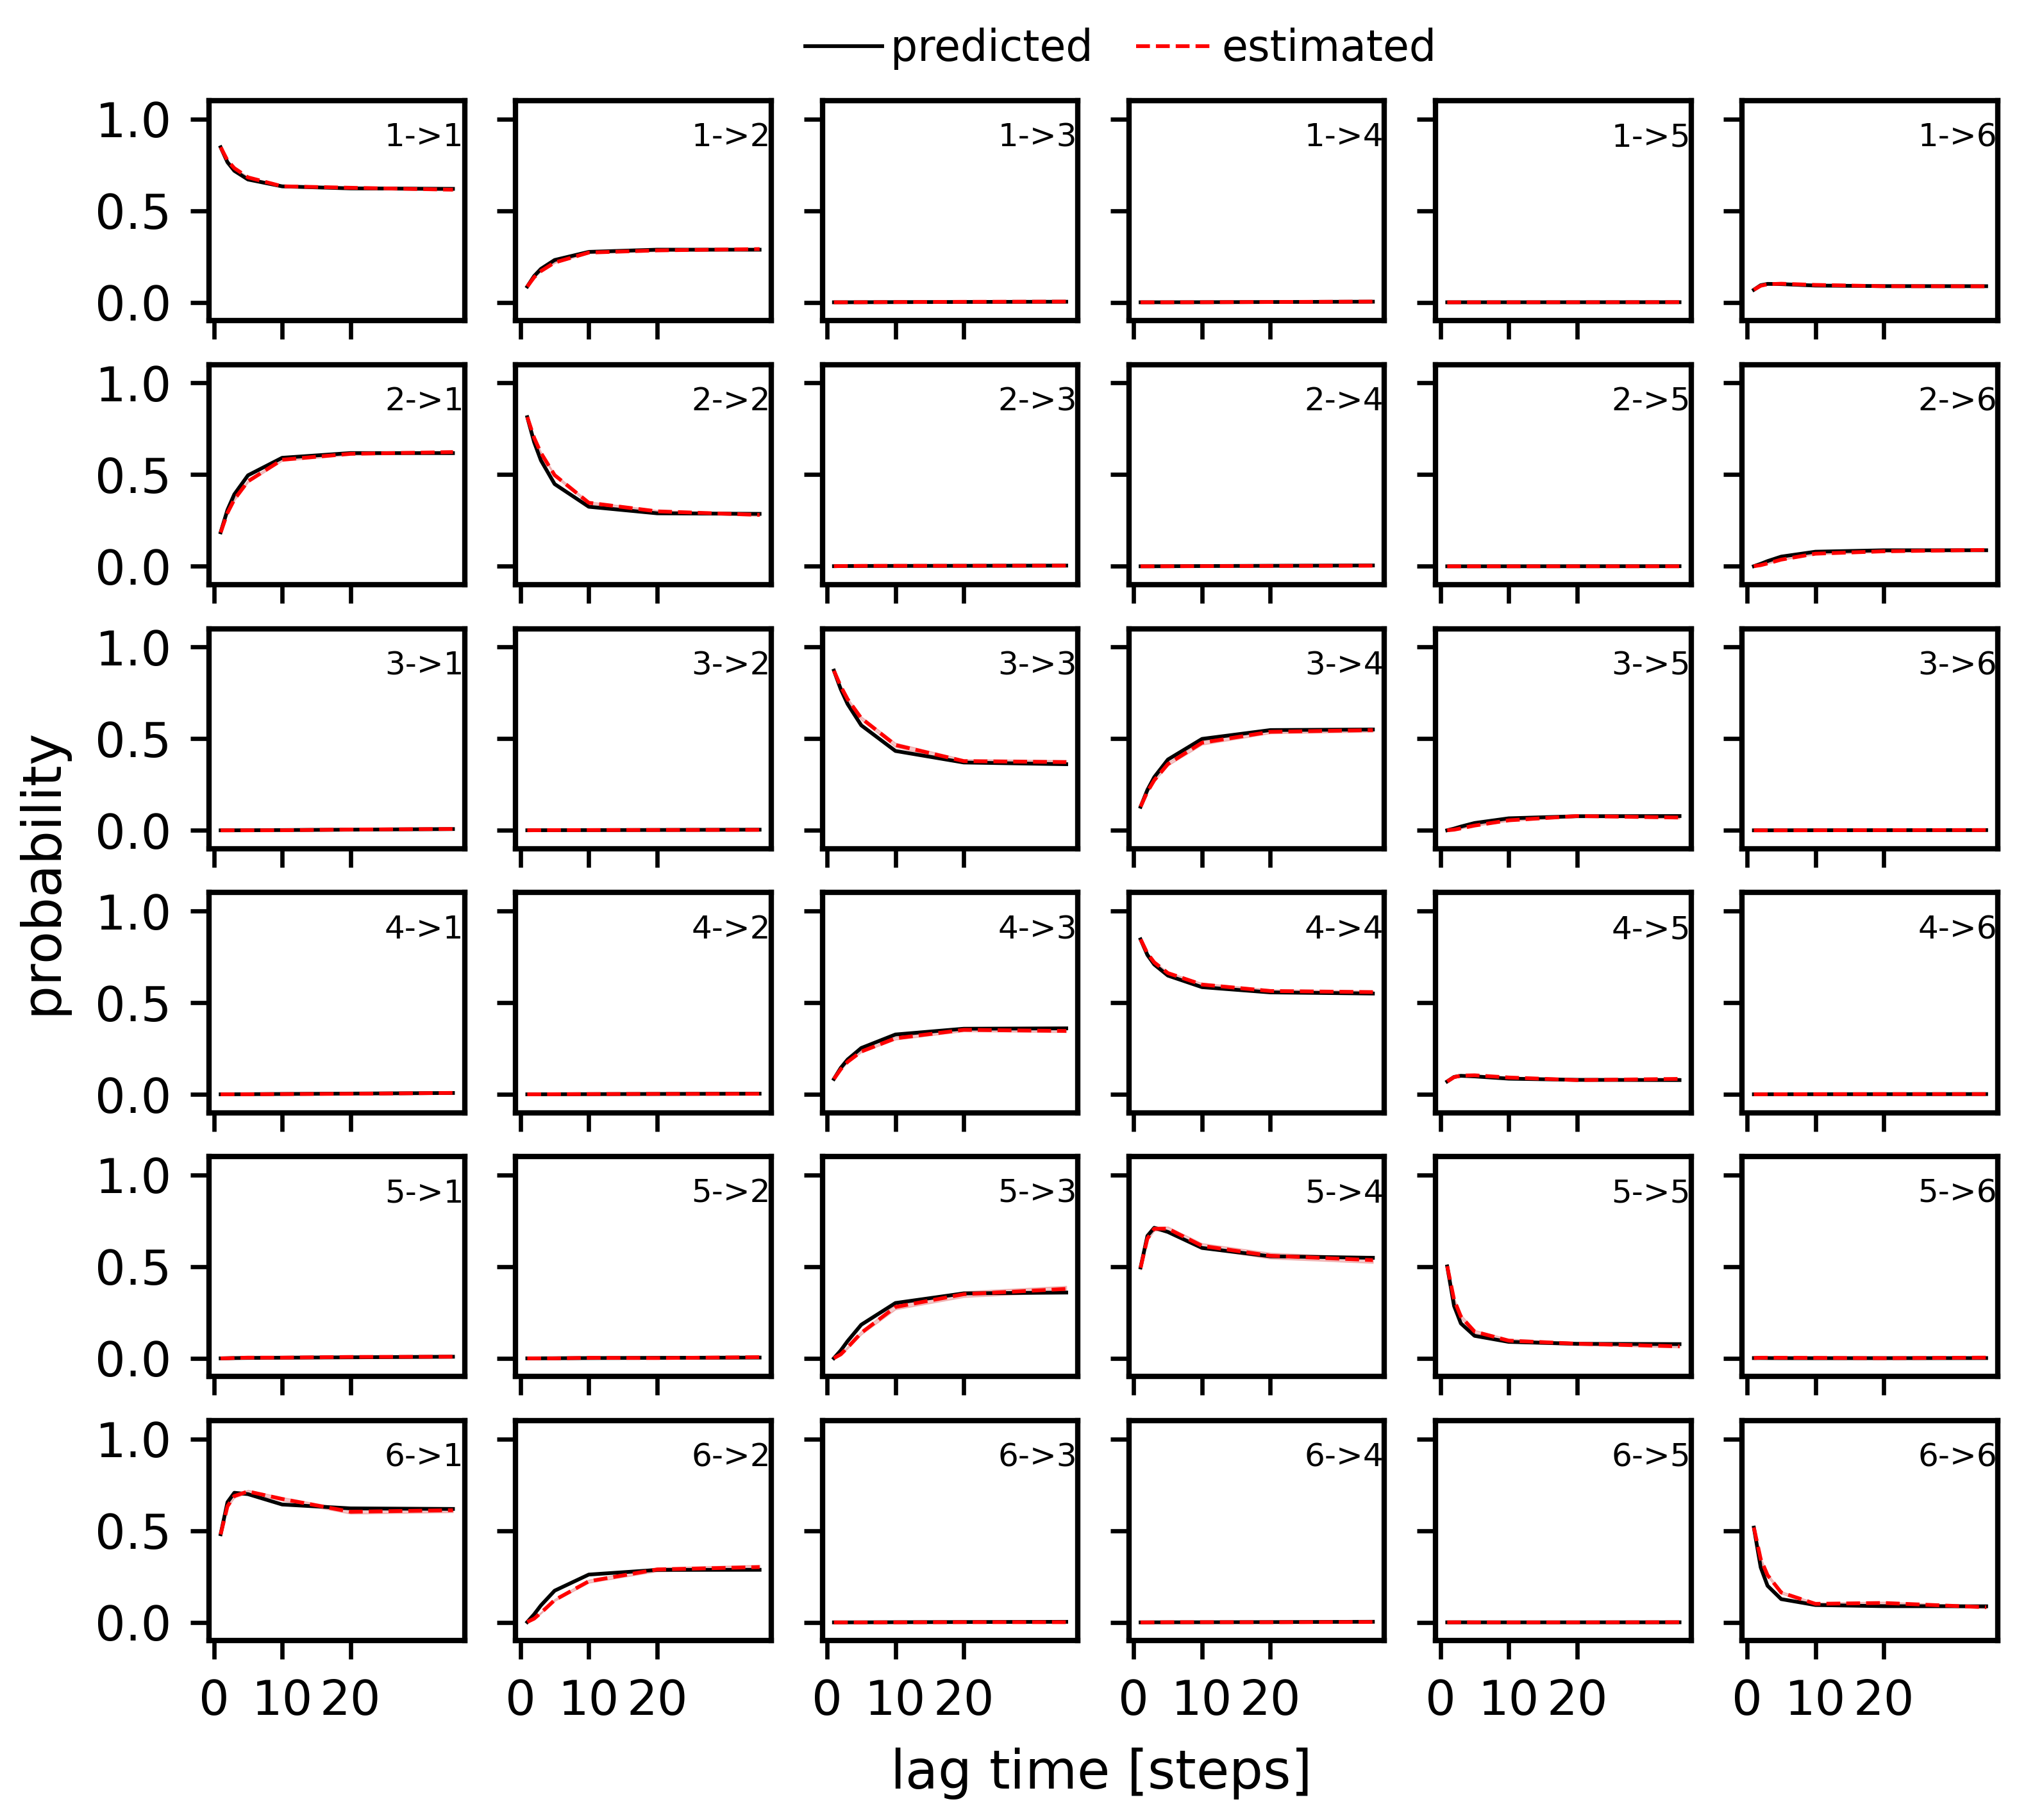

In [417]:
fig, ax = plt.subplots(6,6, figsize=(6,5.2), sharex=True, sharey=True)
type(ax)

plt.yticks([0.0,0.5,1.0],[0.0,0.5,1.0])
plt.xticks([0,10,20],[0,10,20])
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

for i in range(6):
    for j in range(6):
        ax[i,j].plot(lagtimes, pred_ck[:,i,j], 'k', linewidth=0.7, label='predicted')
        ax[i,j].plot(lagtimes, est_ck[:,i,j], '--r', linewidth=0.7, label='estimated')
        ax[i,j].fill_between(lagtimes, est_ck[:,i,j]-est_err_ck[:,i,j], est_ck[:,i,j]+est_err_ck[:,i,j], alpha=0.25, color='tab:red', linewidth=0.2)
        ax[i,j].set_ylim(-0.1,1.1)
        ax[i,j].text(25,0.85, f'{i+1}->{j+1}', fontsize=6)

        if i==5 and j==2:
            ax[i,j].set_xlabel(r'$\qquad \qquad \qquad$ lag time [steps]')
        if i==3 and j==0:
            ax[i,j].set_ylabel(r'$\qquad \qquad \quad$ probability')
            ax[i,j].legend(loc=(2.3,4.7), ncols=2)

plt.savefig(path_an+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/ck-test_6states_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_VAMPnet.png', dpi=1200)

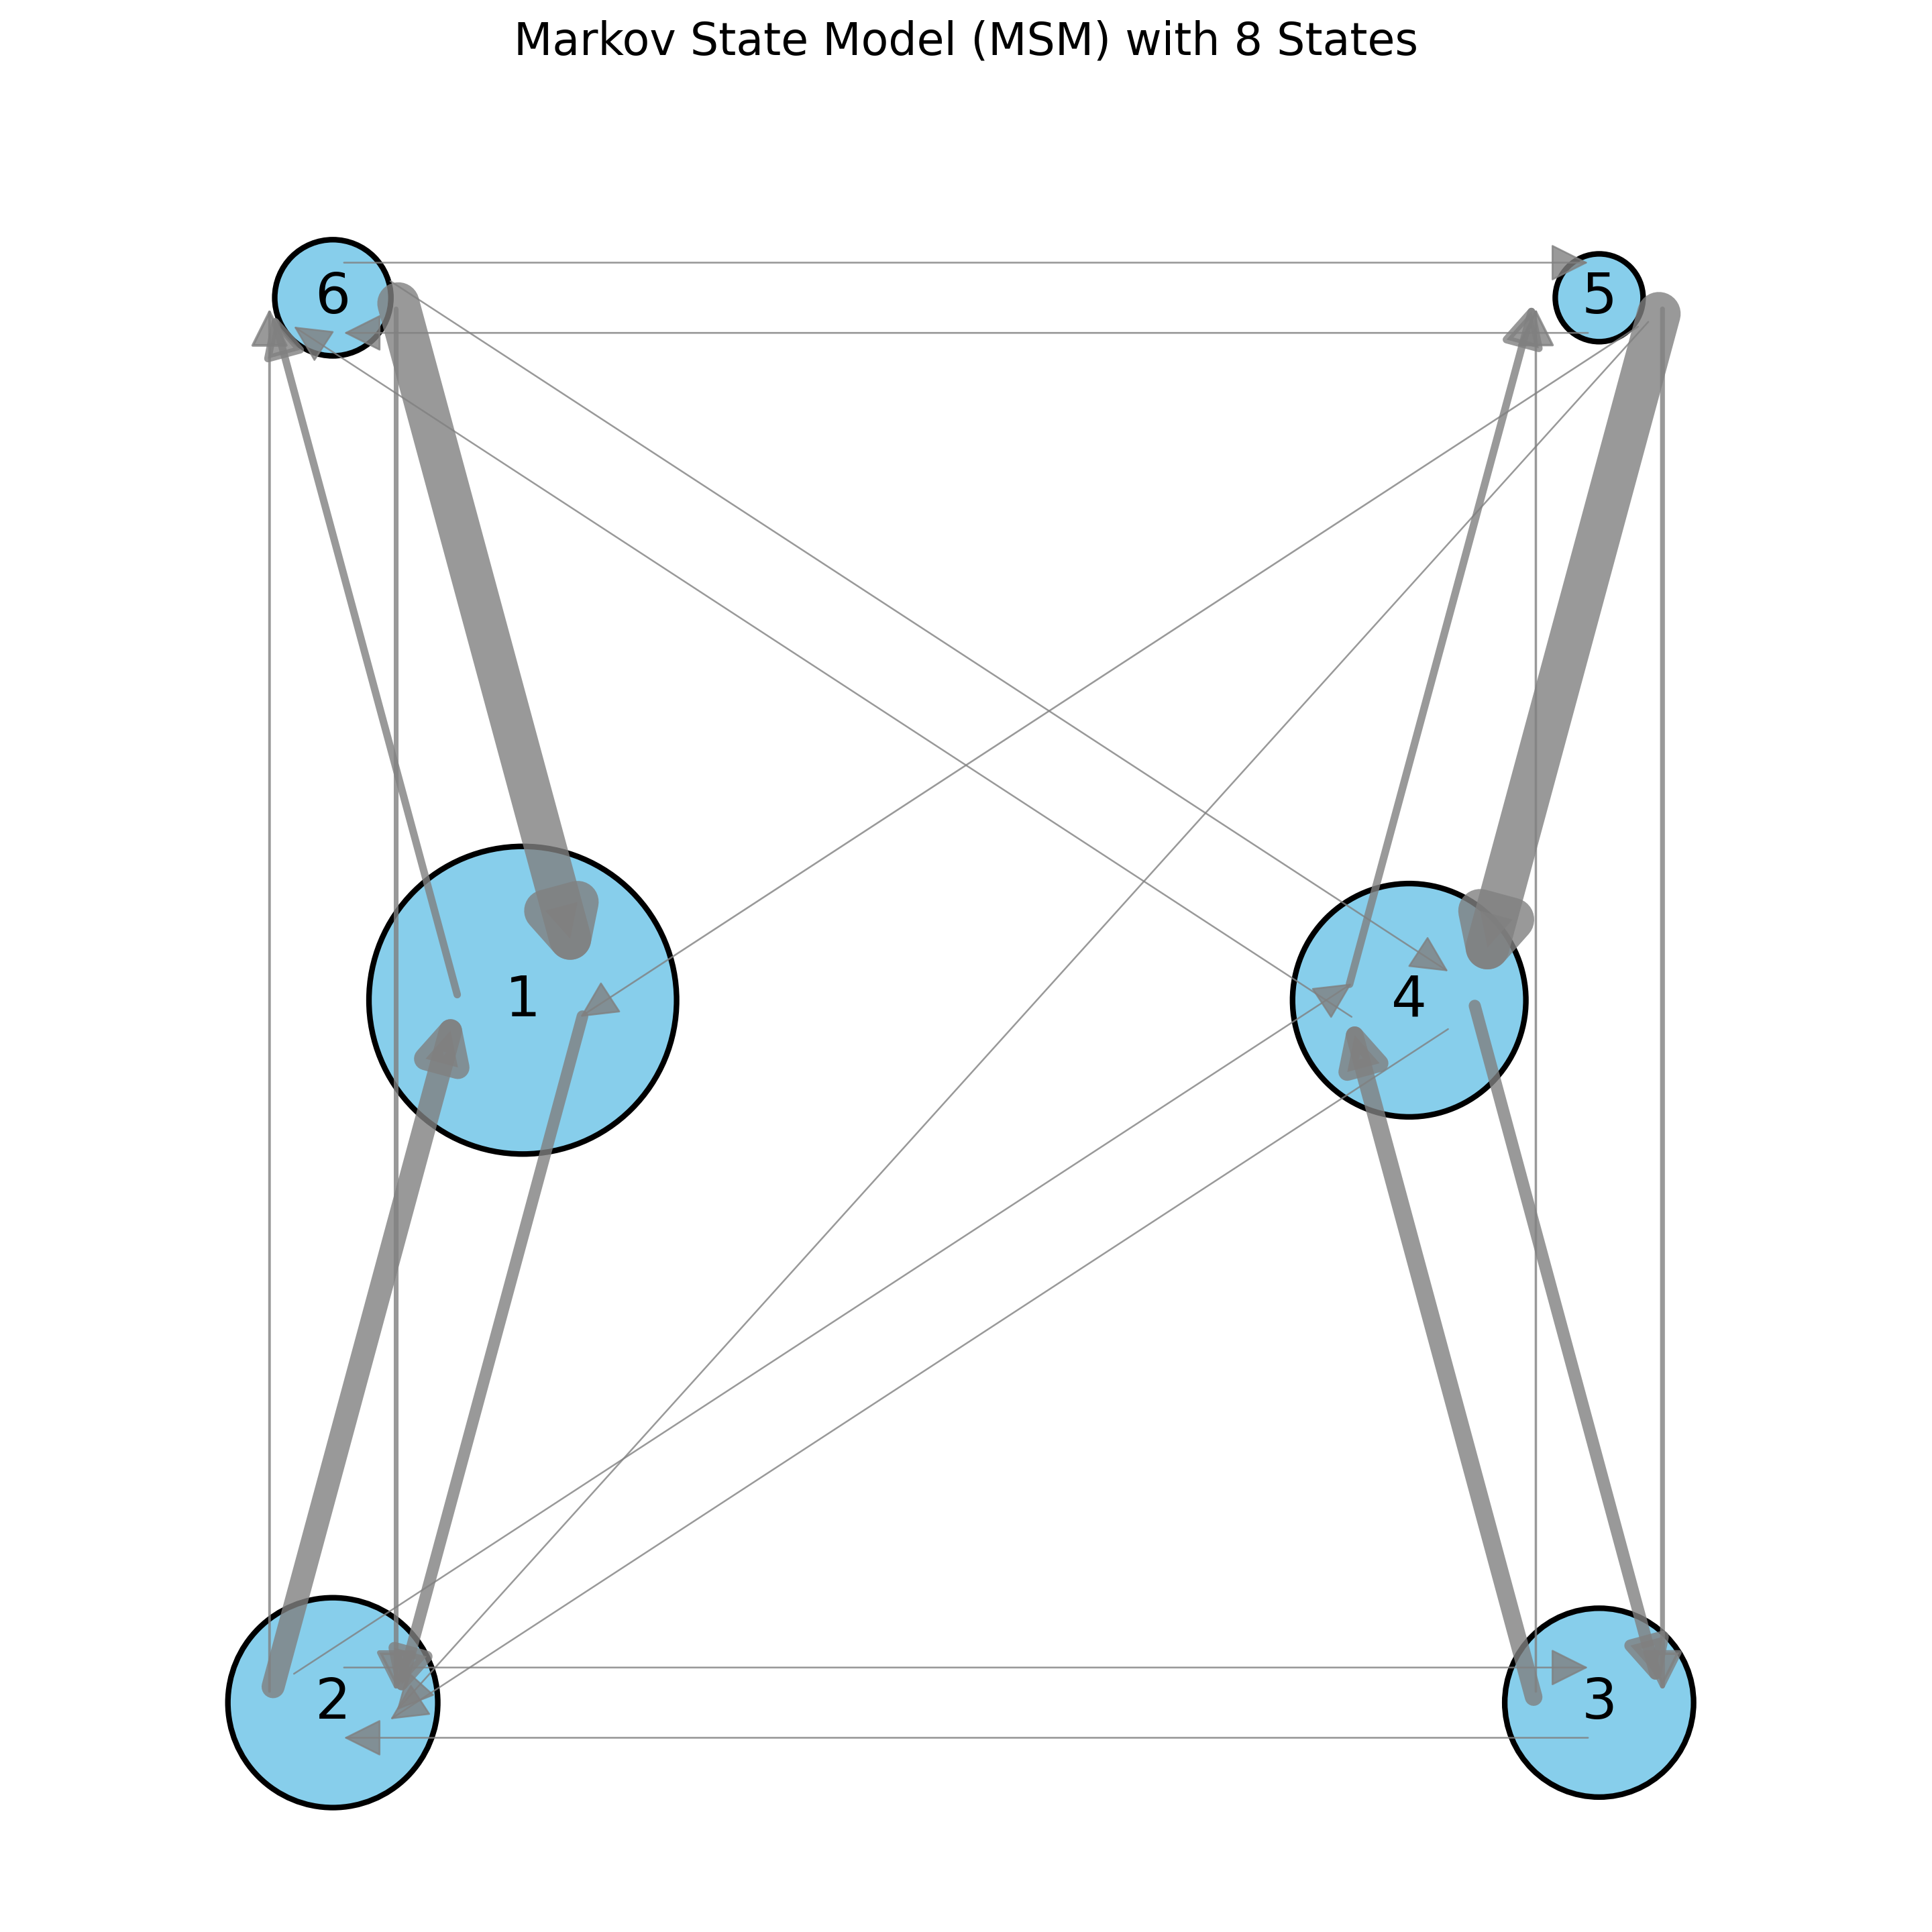

In [61]:
from matplotlib.patches import FancyArrowPatch


# Create a directed graph
G = nx.DiGraph()
st_distr = msm.gather_stats('stationary_distribution').mean

# Add nodes with size proportional to stationary distribution
for i in range(6):
    G.add_node(i, size=st_distr[i])

# Add edges (no self-loops) with weight proportional to transition probabilities
for i in range(6):
    for j in range(6):
        if i != j and tr_mat[i, j] > 1e-4:
            G.add_edge(i, j, weight=tr_mat[i, j])

# Start plot
fig, ax = plt.subplots(figsize=(5,5))

# Position the nodes using spring layout
positions = np.array([(0.15,0),(0,-1),(1,-1),(0.85,0),(1,1),(0,1)])/100
pos = dict()
label_dict = dict()
for i in range(6):
    pos[i] = positions[i]
    label_dict[i] = f"{i+1}"

# Draw nodes with size scaled
node_sizes = [8000 * G.nodes[i]['size'] for i in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', edgecolors='k')
nx.draw_networkx_labels(G, pos, labels=label_dict , font_size=10, font_color='black')

# Normalize edge weights
weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(weights)

# Track already drawn pairs to offset one of the two directions
drawn_pairs = set()

def draw_straight_offset_edge(ax, src, dst, weight, offset_scale=0.0005, color='gray'):
    p1 = np.array(pos[src])
    p2 = np.array(pos[dst])
    vec = p2 - p1
    # Perpendicular unit vector
    perp = np.array([-vec[1], vec[0]])
    perp /= np.linalg.norm(perp)
    
    offset = offset_scale * perp

    # Offset positions
    p1_off = p1 + offset
    p2_off = p2 + offset

    # Draw straight arrow with offset
    arrow = FancyArrowPatch(
        p1_off, p2_off,
        arrowstyle='-|>',
        mutation_scale=15,
        lw=3 * weight,
        color=color,
        alpha=0.8,
        zorder=2
    )
    ax.add_patch(arrow)
    drawn_pairs.add((src, dst))
    
# Draw edges manually with curvature to avoid overlap
def draw_curved_edge(ax, pos, src, dst, weight, color='gray', rad=0.2, special=False):
    if special:
        # Special styling for edge 4 → 7
        rad = 0.5
        color = 'crimson'
    arrow = FancyArrowPatch(
        pos[src], pos[dst],
        connectionstyle=f"arc3,rad={rad}",
        arrowstyle='-|>',
        mutation_scale=15,
        lw=3 * weight,
        color=color,
        alpha=0.8,
        zorder=2
    )
    ax.add_patch(arrow)

# Draw edges
for u, v in G.edges():
    raw_weight = G[u][v]['weight']
    weight = 0.1 + 2.5 * (raw_weight / max_weight)  # Ensures visibility
#    if {u, v} == {3, 7}:  # Edge between 3 and 7 in either direction
#        rad = 0.3
#        draw_curved_edge(ax, pos, u, v, weight, rad=2.7*rad)
#    elif {u, v} == {1, 2} or {u, v} == {5, 6}:
#        rad = 0.3 
#        draw_curved_edge(ax, pos, u, v, weight, rad=rad)
#    else:
#        draw_straight_offset_edge(ax, u, v, weight)
    draw_straight_offset_edge(ax, u, v, weight)


# Final plot adjustments
plt.title('Markov State Model (MSM) with 8 States')
plt.axis('off')
plt.tight_layout()

plt.savefig(path_an+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/cycle_6states_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_VAMPnet.png', dpi=1200)

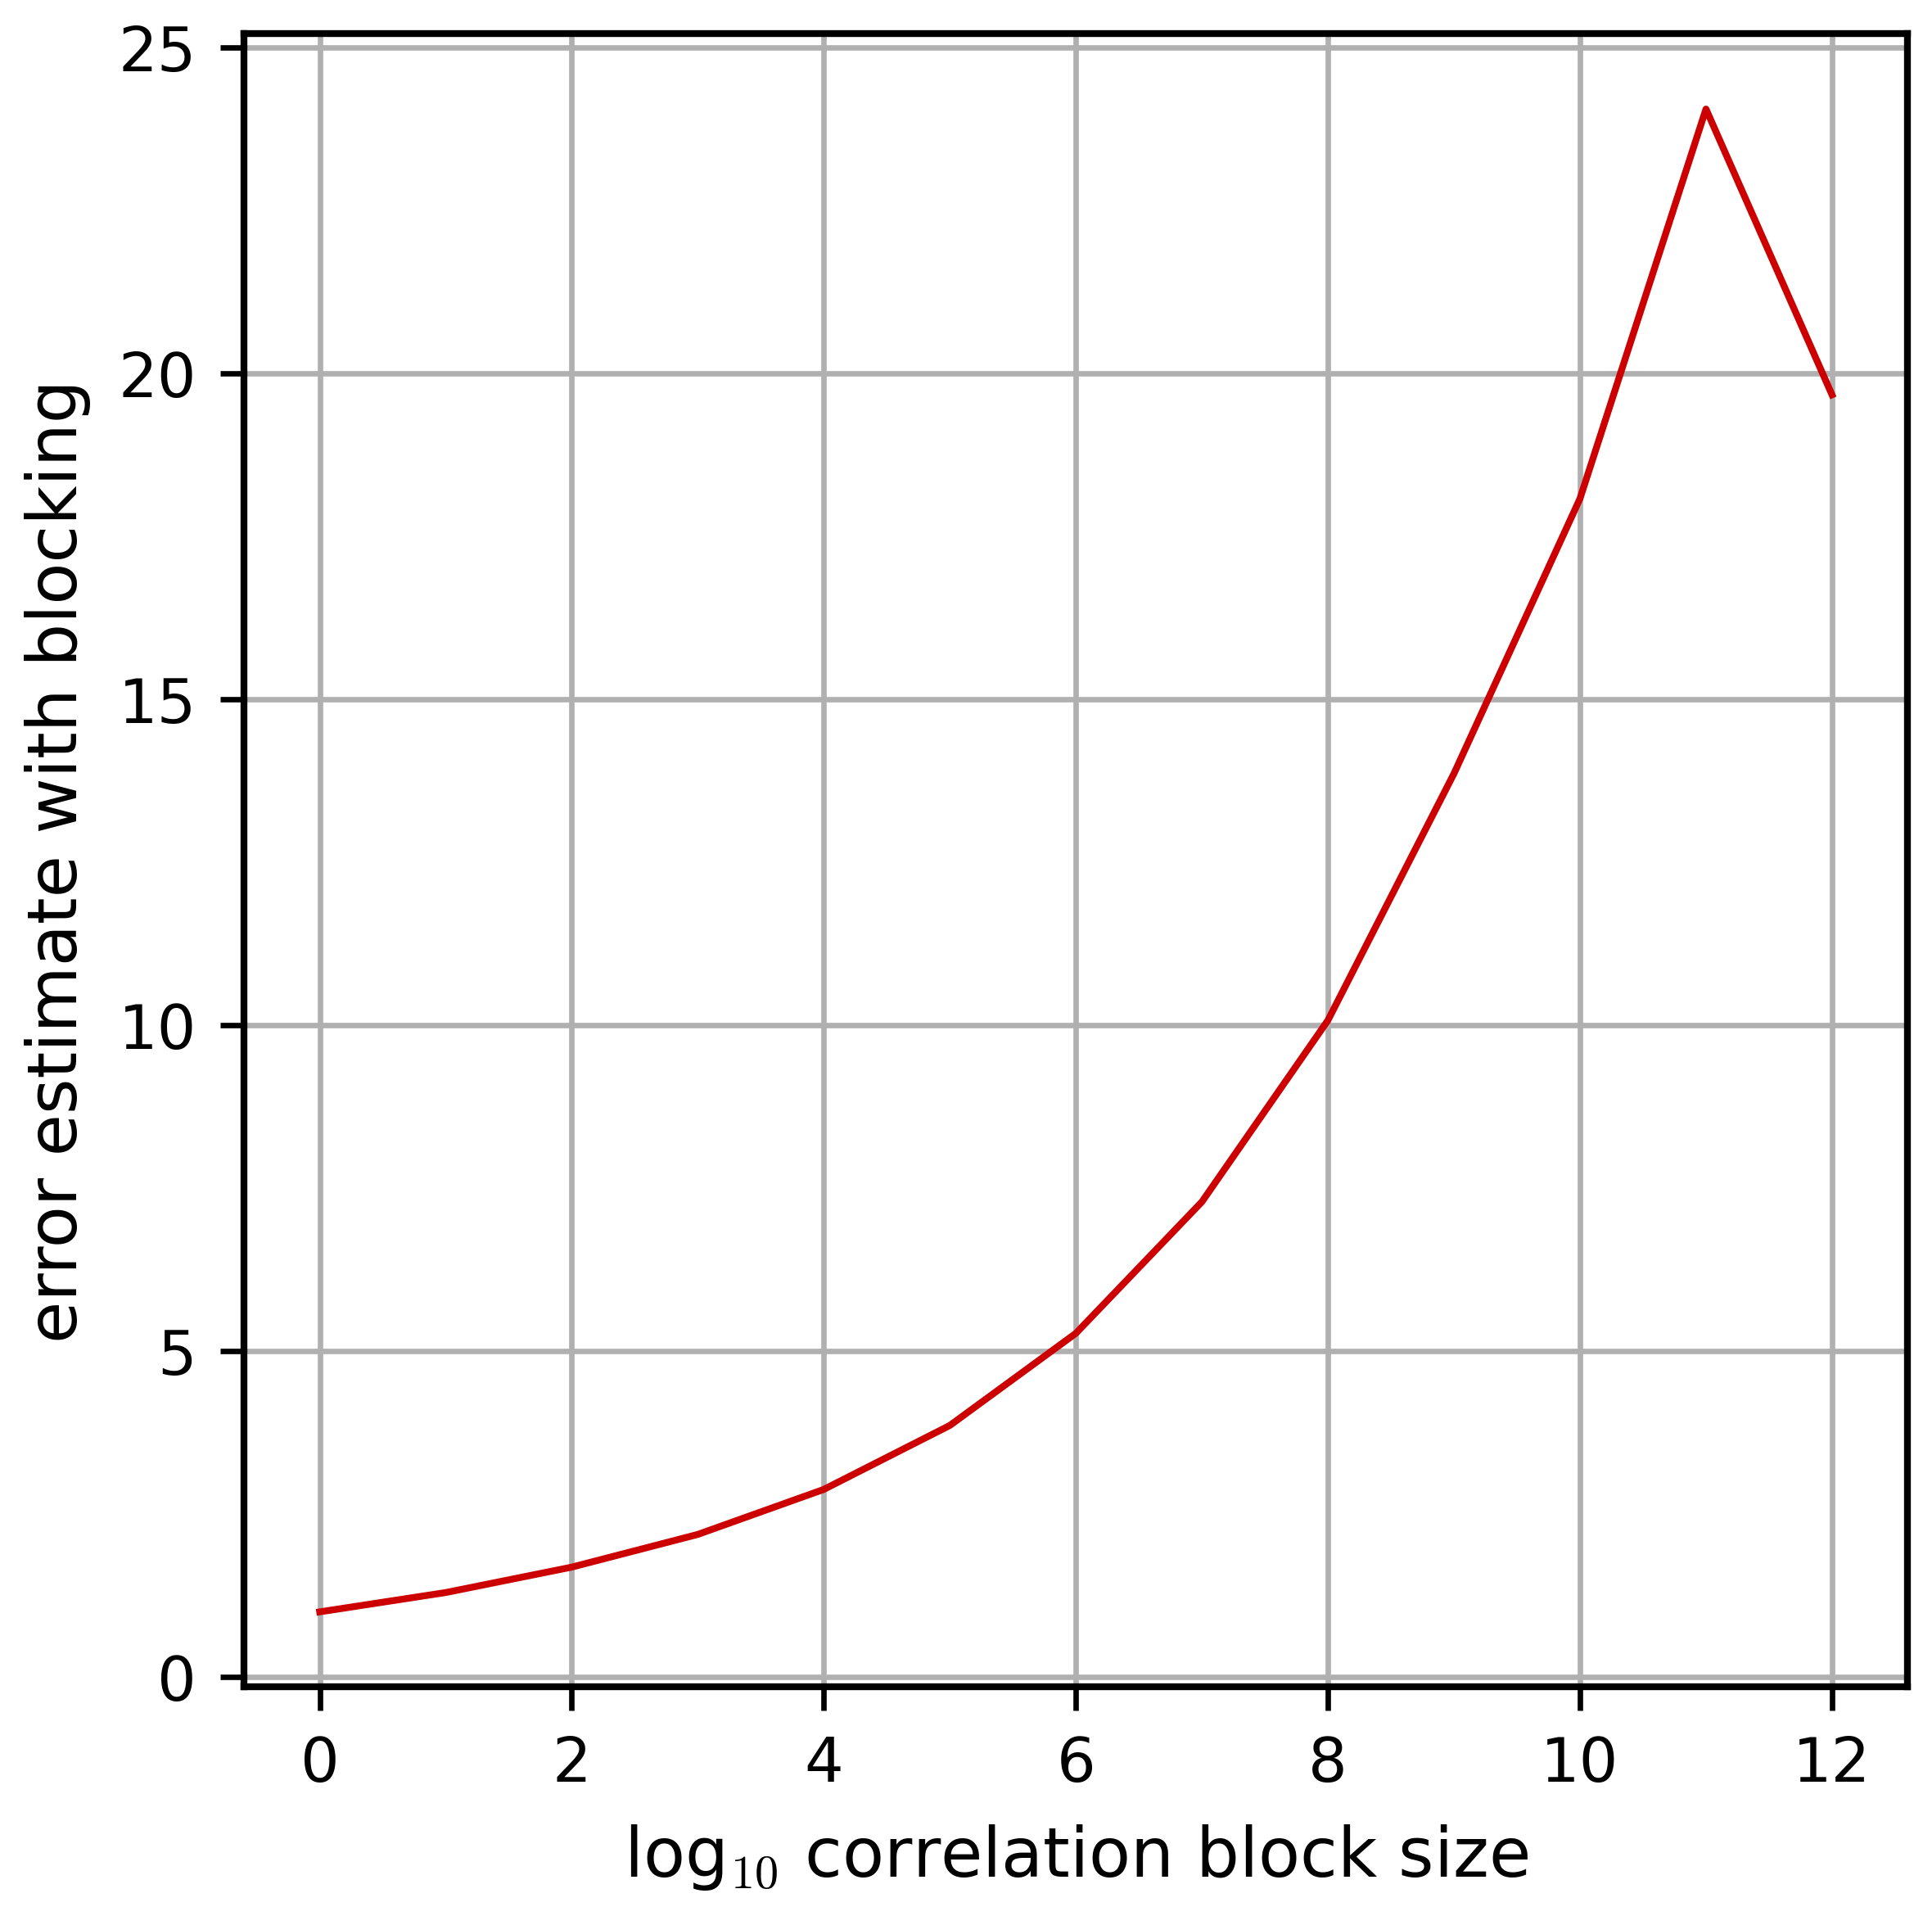

In [419]:
hpa.util.autocorr_bin(states, 13, 1000)


In [439]:
dmus = [hpa.msm.dmu_estimate(states, lag=t, n_term=1000) for t in range(1,6)]
dmus

100%|███████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 7205.47it/s]


[5.889556995302294,
 5.940374470464723,
 5.567003033516075,
 4.945911309350188,
 7.048300141282597]

In [440]:
dmu = hpa.msm.dmu_estimate(states, lag=2, n_term=1000)
sigma_dmu = hpa.msm.bootstrap_dmu_estimate(states, lag=2, pow_bin=4, n_resample=30, n_term=100)

100%|███████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 7185.60it/s]


In [441]:
dmu, sigma_dmu

(5.940374470464723, 1.1282793830087767)

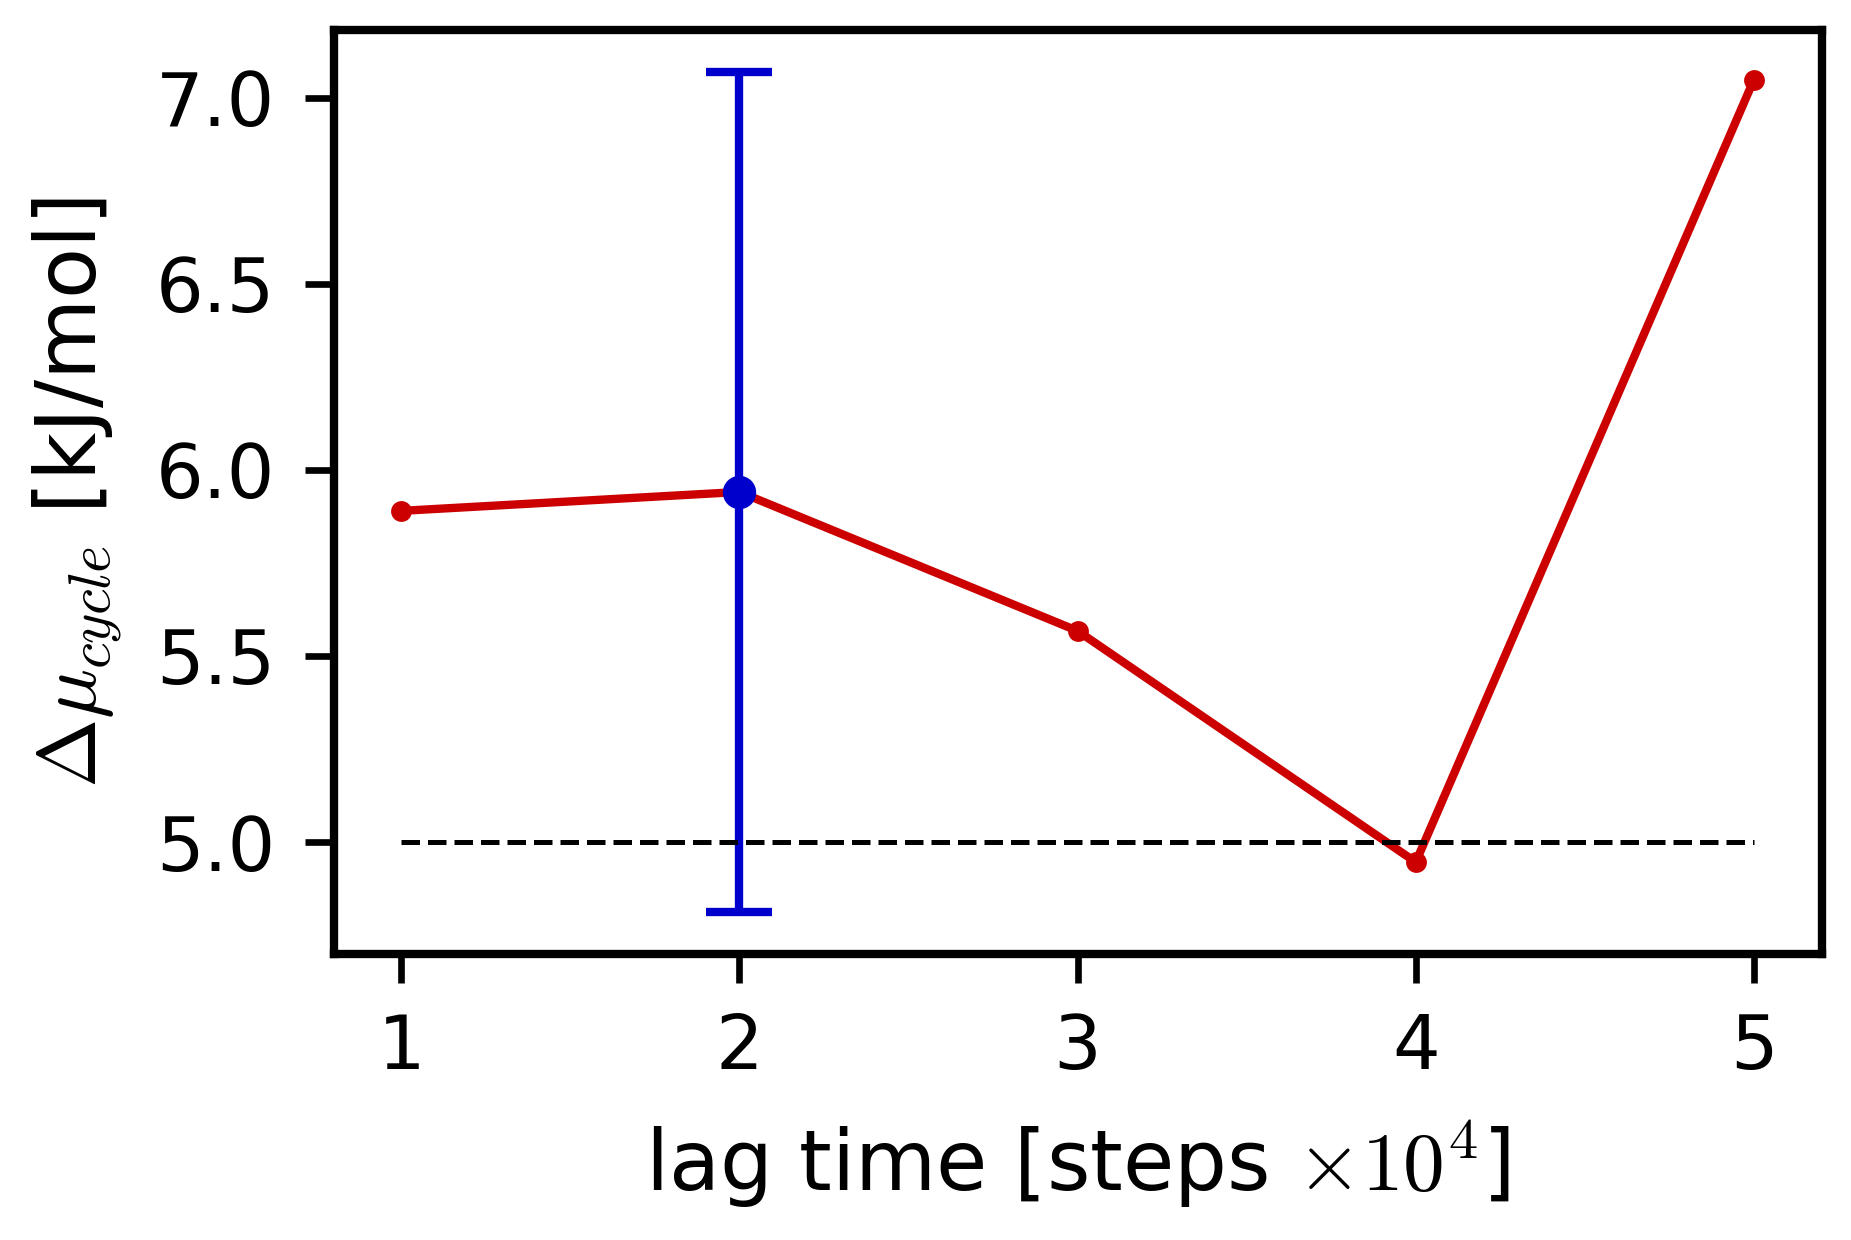

In [442]:
fig, ax = plt.subplots(1, 1, figsize=(3.2,2))

ax.plot(range(1,6), dmus, '.-')
ax.errorbar([2],[dmu],[sigma_dmu], fmt='o', capsize=4)
ax.set_xlabel(r'lag time [steps $\times 10^4$]')
ax.set_ylabel(r'$\Delta \mu_{cycle}$ [kJ/mol]')
ax.plot([1,5],[5,5], '--k', lw=0.6)
#ax.set_ylim(15,42)
plt.savefig(path_an+f'sim_ser19_dmu-5_0_1-tdp43-5pser_1-ck1d-open_1-pp3_fixed/dmu_6states_ser19_dmu-5_0_1-tdp43-5pser_com-ck1d-open_com-pp3_fixed_CAL3_VAMPnet.png', dpi=1200)

## MSM 8 states (with PP3)

In [86]:
states = np.array([], dtype=int)
for s in range(1,6):
    tmp = np.loadtxt(path_an+f'sim_ser19_dmu-5_0_1-tdp43-2pser_1-ck1d-open_1-pp3/sim{s}_ser19_dmu-5_0_1-tdp43-2pser_com-ck1d-open_com-pp3_CAL3_states.txt').astype(int)
    states = np.append(states, tmp)

print(np.max(states), np.min(states))
states

8 1


array([1, 1, 1, ..., 1, 1, 1])

In [87]:
models = []
lagtimes = [1,2,3,5,10,20,35]
for lagtime in lagtimes:
    counts = markov.TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(states-1)
    models.append(markov.msm.BayesianMSM(n_samples=100, n_steps=20).fit_fetch(counts))

(1.0, 35.0)

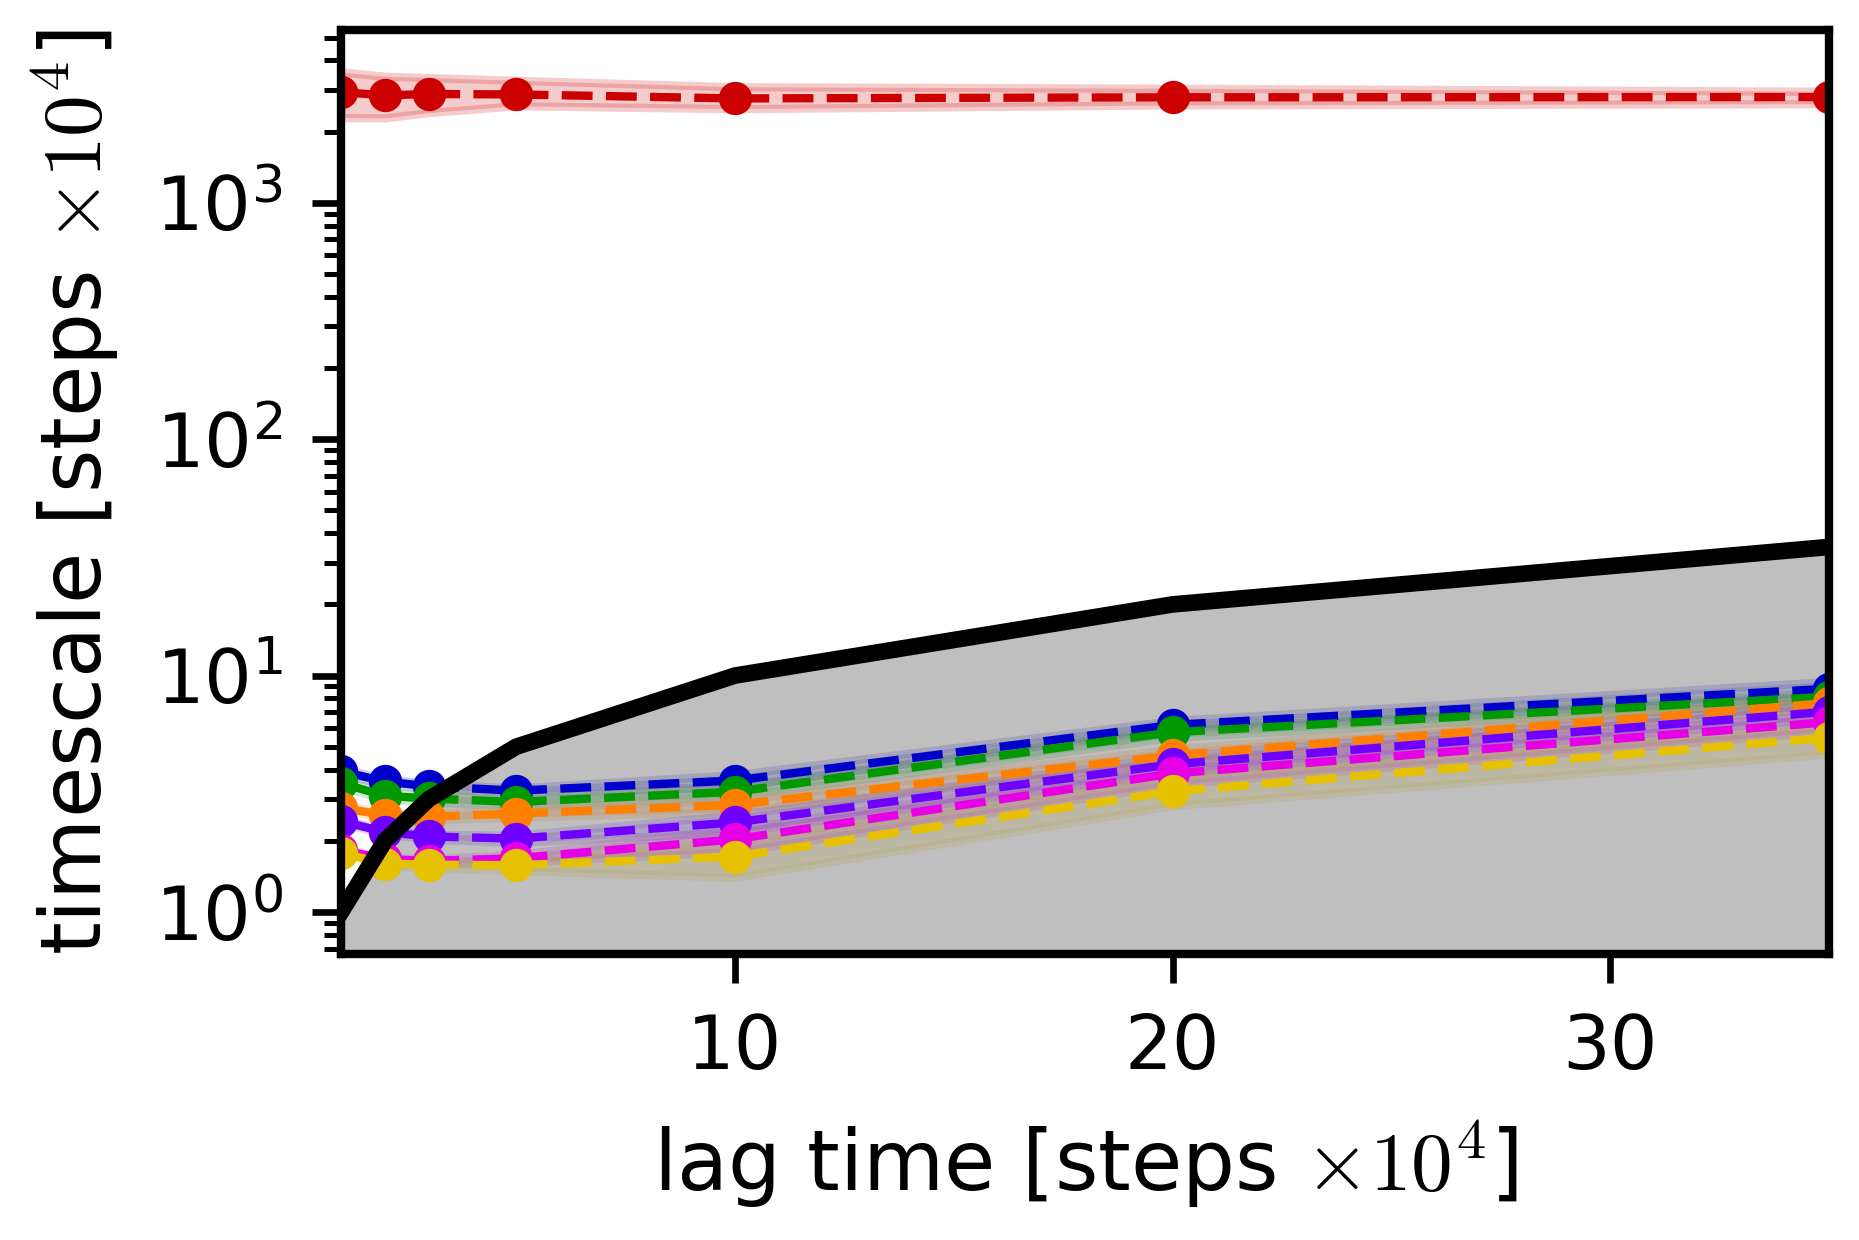

In [88]:
its_data = implied_timescales(models)

fig, ax = plt.subplots(1, 1, figsize=(3.2,2))

plot_implied_timescales(its_data, ax=ax, show_mle=False, sample_confidence=.68)
ax.set_yscale('log')
ax.set_xlabel(r'lag time [steps $\times 10^4$]')
ax.set_ylabel(r'timescale [steps $\times 10^4$]')
ax.set_xlim(1,35)


### Chapman-Kolmogorov test

In [89]:
# model with lagtime 10
pred_ck, est_ck, est_err_ck = ck_test(states, lagtimes, reversible=False)

In [90]:
counts = markov.TransitionCountEstimator(lagtime=3, count_mode='effective').fit_fetch(states-1)
msm = markov.msm.BayesianMSM(n_samples=100, n_steps=20).fit_fetch(counts)

tr_mat = msm.gather_stats('transition_matrix').mean
tr_mat

array([[8.39657171e-01, 8.51982624e-02, 9.61534678e-05, 8.14499651e-05,
        1.00142909e-04, 6.01212562e-02, 1.47455646e-02, 0.00000000e+00],
       [5.79693679e-01, 3.29238468e-01, 2.71405472e-04, 7.06231609e-05,
        1.57456137e-04, 4.50547645e-02, 4.53296308e-02, 1.83972793e-04],
       [4.79545601e-04, 2.06488381e-04, 4.44784534e-01, 4.74462134e-01,
        3.09668471e-02, 7.41682021e-05, 8.01836352e-05, 4.89460988e-02],
       [7.68771203e-05, 9.89759171e-06, 9.01995744e-02, 8.36178693e-01,
        5.67110000e-02, 9.06649492e-05, 2.73082558e-05, 1.67059848e-02],
       [1.12825147e-03, 2.63723080e-04, 6.88398093e-02, 6.63175328e-01,
        2.20564115e-01, 1.88599776e-03, 0.00000000e+00, 4.41427753e-02],
       [6.46986217e-01, 7.12532836e-02, 1.48732087e-04, 1.03448007e-03,
        1.81577860e-03, 2.33548948e-01, 4.52125606e-02, 0.00000000e+00],
       [3.71017705e-01, 1.67636591e-01, 3.74029673e-04, 7.02538913e-04,
        0.00000000e+00, 1.05765051e-01, 3.54184232e-01, 3.

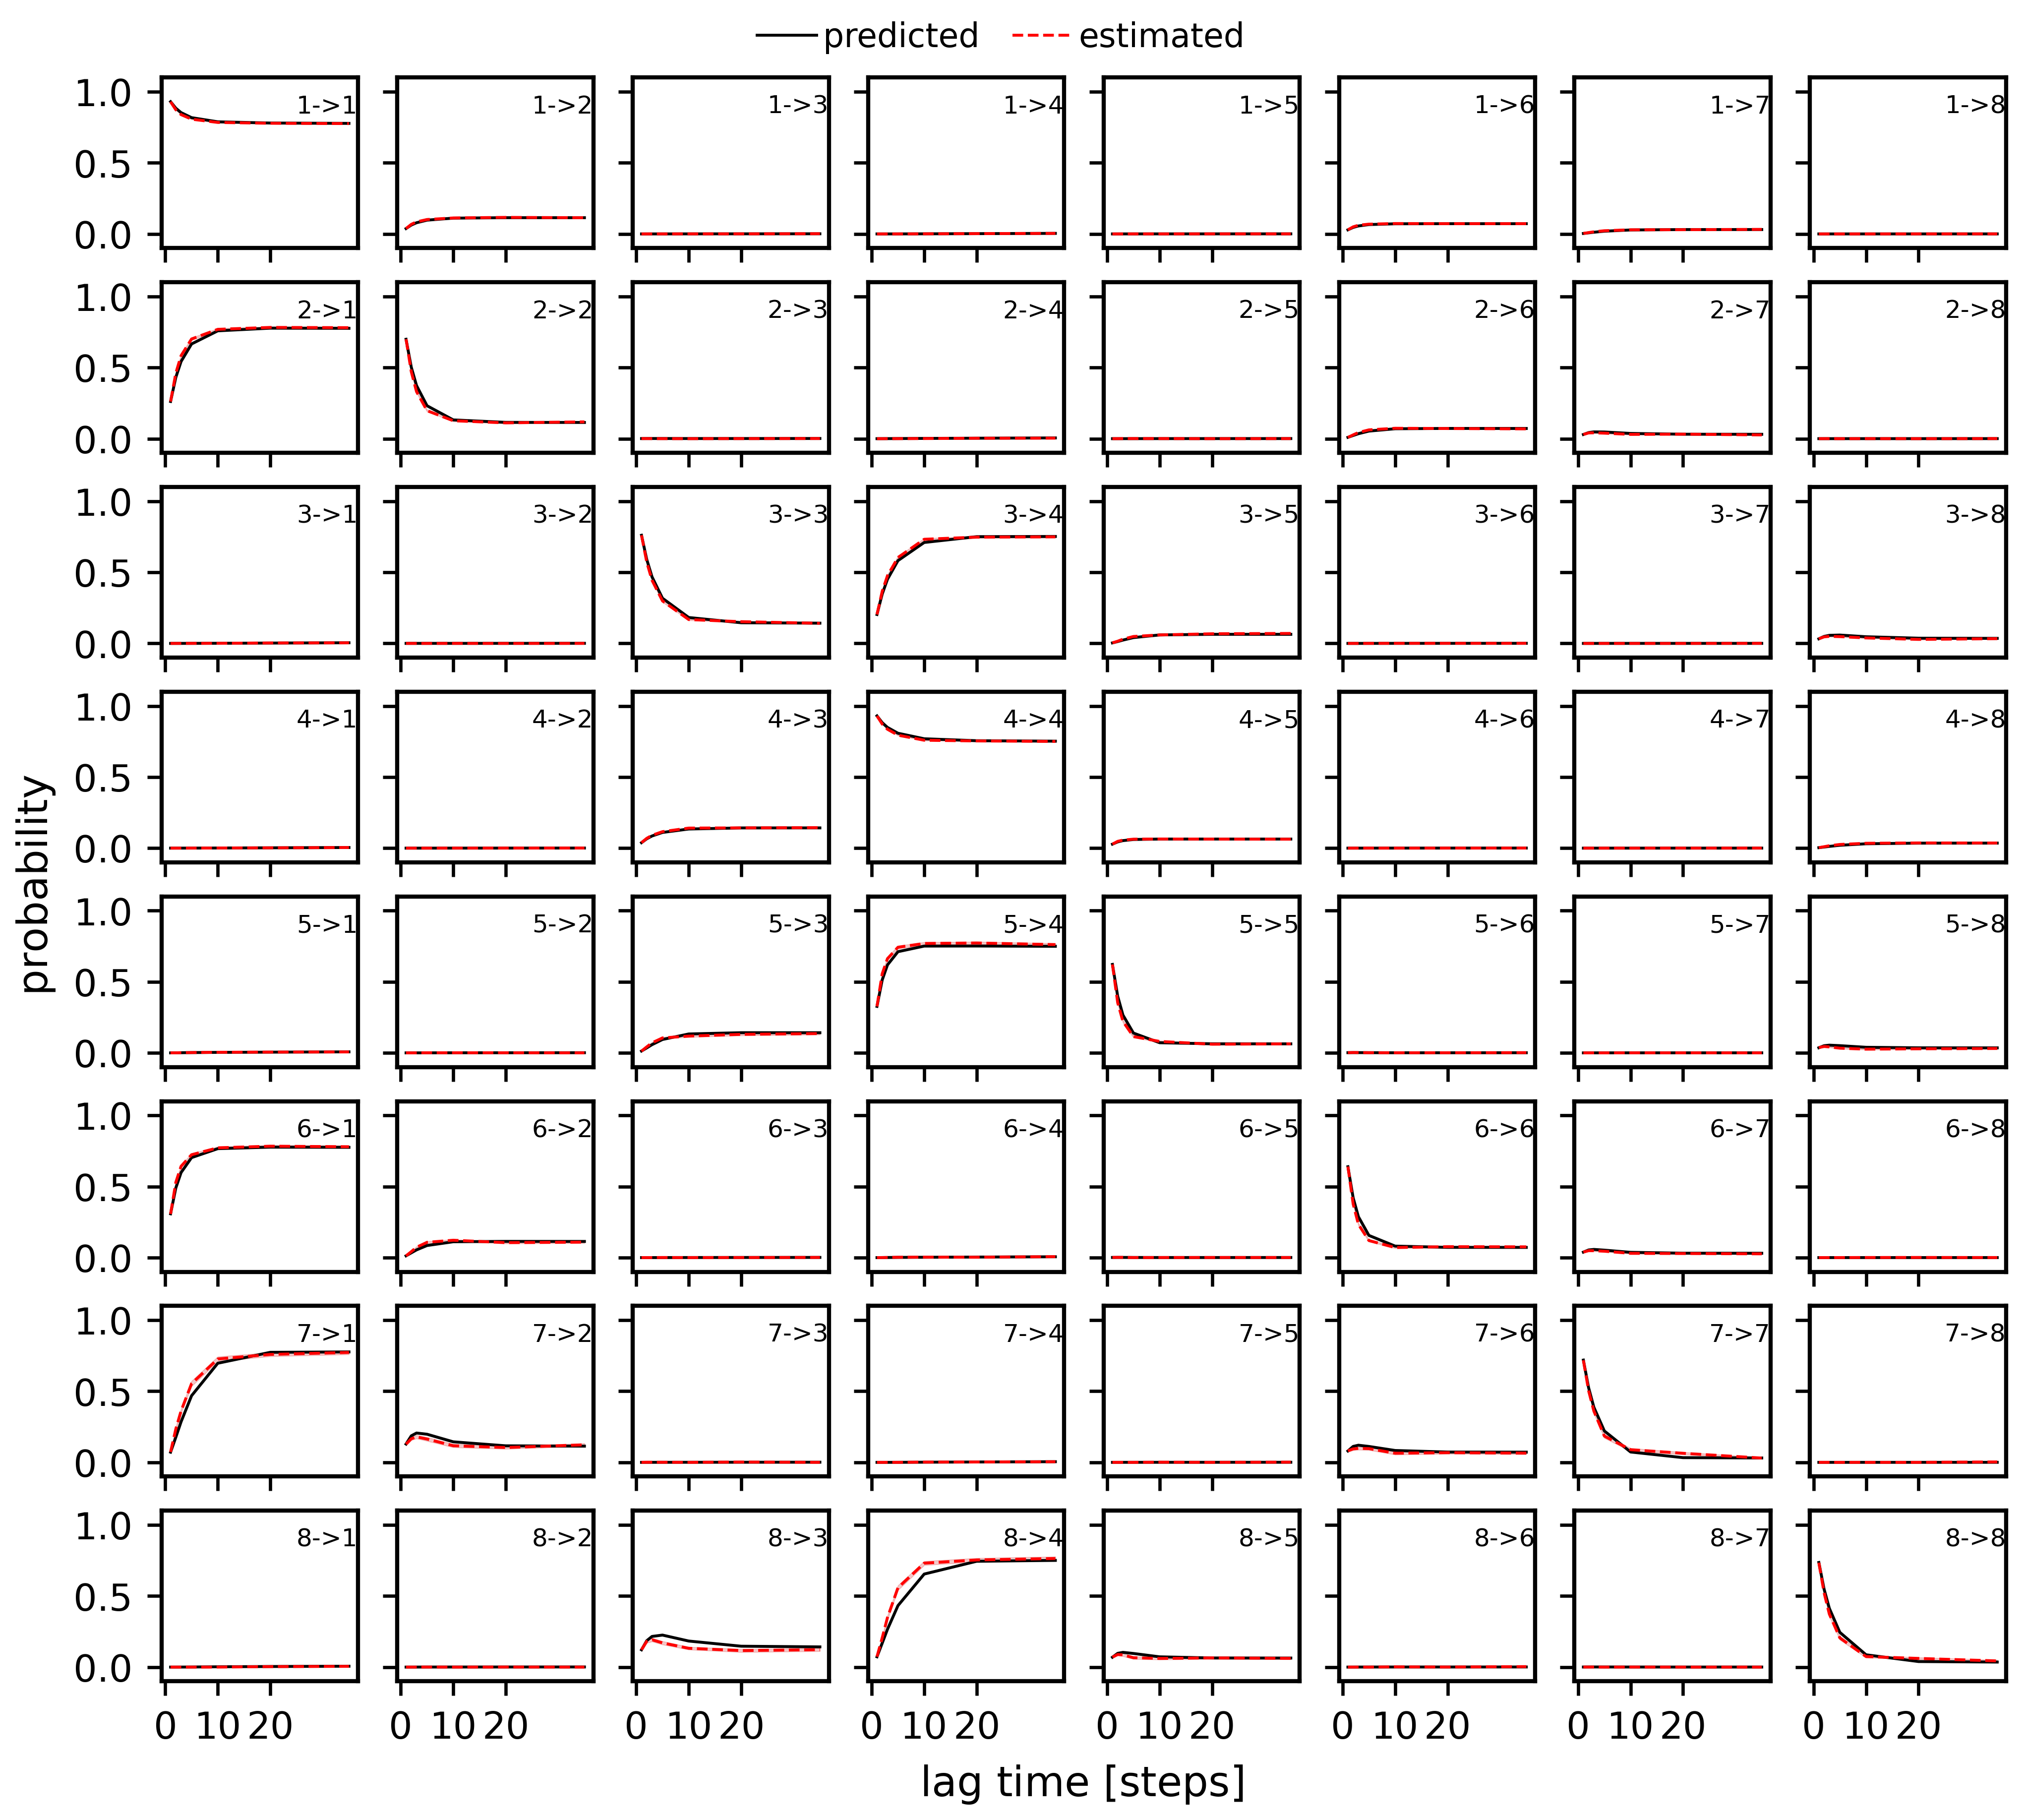

In [96]:
fig, ax = plt.subplots(8,8, figsize=(8,7), sharex=True, sharey=True)
type(ax)

plt.yticks([0.0,0.5,1.0],[0.0,0.5,1.0])
plt.xticks([0,10,20],[0,10,20])
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

for i in range(8):
    for j in range(8):
        ax[i,j].plot(lagtimes, pred_ck[:,i,j], 'k', linewidth=0.7, label='predicted')
        ax[i,j].plot(lagtimes, est_ck[:,i,j], '--r', linewidth=0.7, label='estimated')
        ax[i,j].fill_between(lagtimes, est_ck[:,i,j]-est_err_ck[:,i,j], est_ck[:,i,j]+est_err_ck[:,i,j], alpha=0.25, color='tab:red', linewidth=0.2)
        ax[i,j].set_ylim(-0.1,1.1)
        ax[i,j].text(25,0.85, f'{i+1}->{j+1}', fontsize=6)

        if i==7 and j==3:
            ax[i,j].set_xlabel(r'$\qquad \qquad \qquad$ lag time [steps]')
        if i==4 and j==0:
            ax[i,j].set_ylabel(r'$\qquad \qquad \quad$ probability')
            ax[i,j].legend(loc=(3.,5.9), ncols=2)

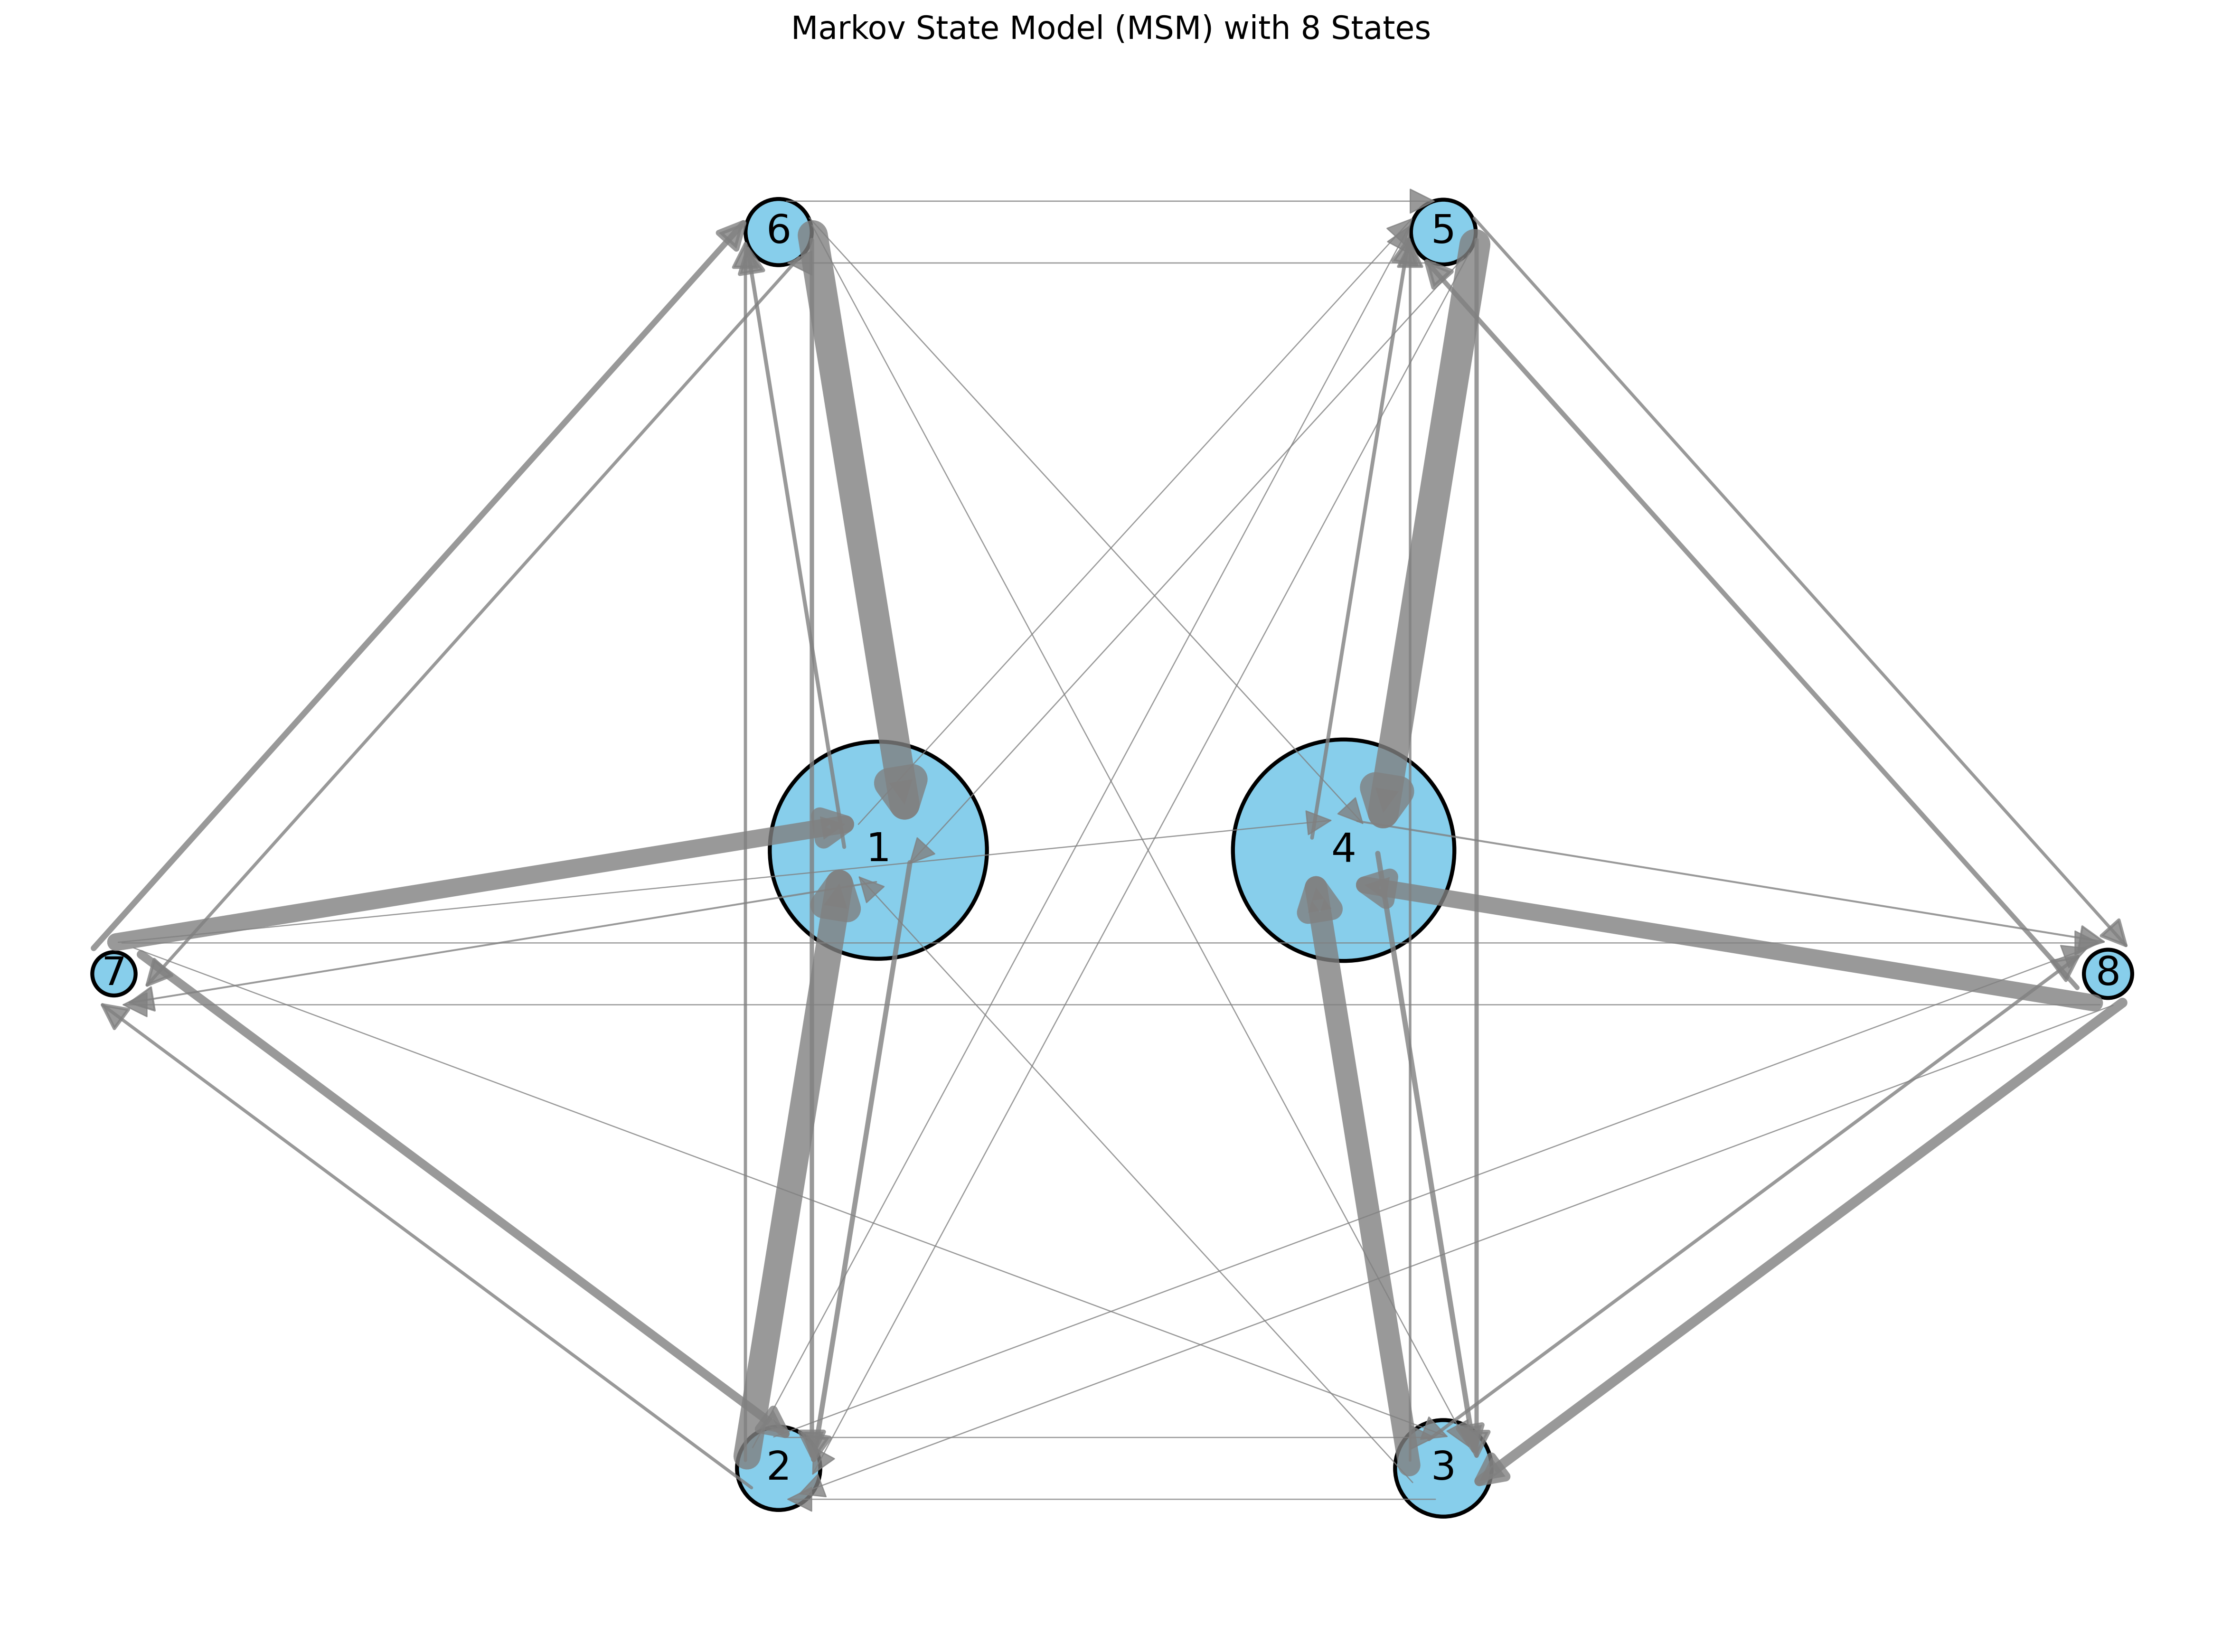

In [102]:
from matplotlib.patches import FancyArrowPatch


# Create a directed graph
G = nx.DiGraph()
st_distr = msm.gather_stats('stationary_distribution').mean

# Add nodes with size proportional to stationary distribution
for i in range(8):
    G.add_node(i, size=st_distr[i])

# Add edges (no self-loops) with weight proportional to transition probabilities
for i in range(8):
    for j in range(8):
        if i != j and tr_mat[i, j] > 1e-4:
            G.add_edge(i, j, weight=tr_mat[i, j])

# Start plot
fig, ax = plt.subplots(figsize=(8, 6))

# Position the nodes using spring layout
positions = np.array([(0.15,0),(0,-1),(1,-1),(0.85,0),(1,1),(0,1),(-1,-0.2),(2,-0.2)])/100
pos = dict()
label_dict = dict()
for i in range(8):
    pos[i] = positions[i]
    label_dict[i] = f"{i+1}"

# Draw nodes with size scaled
node_sizes = [8000 * G.nodes[i]['size'] for i in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', edgecolors='k')
nx.draw_networkx_labels(G, pos, labels=label_dict , font_size=10, font_color='black')

# Normalize edge weights
weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(weights)

# Track already drawn pairs to offset one of the two directions
drawn_pairs = set()

def draw_straight_offset_edge(ax, src, dst, weight, offset_scale=0.0005, color='gray'):
    p1 = np.array(pos[src])
    p2 = np.array(pos[dst])
    vec = p2 - p1
    # Perpendicular unit vector
    perp = np.array([-vec[1], vec[0]])
    perp /= np.linalg.norm(perp)
    
    offset = offset_scale * perp

    # Offset positions
    p1_off = p1 + offset
    p2_off = p2 + offset

    # Draw straight arrow with offset
    arrow = FancyArrowPatch(
        p1_off, p2_off,
        arrowstyle='-|>',
        mutation_scale=15,
        lw=3 * weight,
        color=color,
        alpha=0.8,
        zorder=2
    )
    ax.add_patch(arrow)
    drawn_pairs.add((src, dst))
    
# Draw edges manually with curvature to avoid overlap
def draw_curved_edge(ax, pos, src, dst, weight, color='gray', rad=0.2, special=False):
    if special:
        # Special styling for edge 4 → 7
        rad = 0.5
        color = 'crimson'
    arrow = FancyArrowPatch(
        pos[src], pos[dst],
        connectionstyle=f"arc3,rad={rad}",
        arrowstyle='-|>',
        mutation_scale=15,
        lw=3 * weight,
        color=color,
        alpha=0.8,
        zorder=2
    )
    ax.add_patch(arrow)

# Draw edges
for u, v in G.edges():
    raw_weight = G[u][v]['weight']
    weight = 0.1 + 2.5 * (raw_weight / max_weight)  # Ensures visibility
#    if {u, v} == {3, 7}:  # Edge between 3 and 7 in either direction
#        rad = 0.3
#        draw_curved_edge(ax, pos, u, v, weight, rad=2.7*rad)
#    elif {u, v} == {1, 2} or {u, v} == {5, 6}:
#        rad = 0.3 
#        draw_curved_edge(ax, pos, u, v, weight, rad=rad)
#    else:
#        draw_straight_offset_edge(ax, u, v, weight)
    draw_straight_offset_edge(ax, u, v, weight)


# Final plot adjustments
plt.title('Markov State Model (MSM) with 8 States')
plt.axis('off')
plt.tight_layout()
plt.show()


In [105]:
kT=3*0.831446

In [106]:
cycle1234 = tr_mat[0,1]*tr_mat[1,6]*tr_mat[6,5]*tr_mat[5,0]
anticycle1234 = tr_mat[1,0]*tr_mat[6,1]*tr_mat[5,6]*tr_mat[0,5]
dmu1234 = kT*np.log(cycle1234/anticycle1234)
dmu1234

0.0011233833425405612

In [213]:
cycle5678 = tm[4,5]*tm[5,7]*tm[7,6]*tm[6,4]
anticycle5678 = tm[5,4]*tm[7,5]*tm[6,7]*tm[4,6]
dmu5678 = kT*np.log(cycle5678/anticycle5678)
dmu5678

0.7371204329252999

In [214]:
cycle123567 = tm[0,1]*tm[1,5]*tm[5,4]*tm[4,6]*tm[6,2]*tm[2,0]
anticycle123567 = tm[1,0]*tm[5,1]*tm[4,5]*tm[6,4]*tm[2,6]*tm[0,2]
dmu123567 = kT*np.log(cycle123567/anticycle123567)
dmu123567

/tmp/ipykernel_3204451/4072528606.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  dmu123567 = kT*np.log(cycle123567/anticycle123567)


inf

# Check transition dependence on Dmu

## 4 states MSM

In [530]:
states_5 = np.array([], dtype=int)
for s in range(1,10):
    tmp = np.loadtxt(path_simple_an+f'sim_ser19_dmu-5_1-tdp43-5pser_1-ck1d-open_10k/sim{s}_ser19_dmu-5_1-tdp43-5pser_com-ck1d-open_CAL3_10k_states.txt').astype(int)
    states_5 = np.append(states_5, tmp)

print(np.max(states_5), np.min(states_5))

states_10 = np.array([], dtype=int)
for s in range(1,10):
    tmp = np.loadtxt(path_simple_an+f'sim_ser19_dmu-10_1-tdp43-5pser_1-ck1d-open_10k/sim{s}_ser19_dmu-10_1-tdp43-5pser_com-ck1d-open_CAL3_10k_states.txt').astype(int)
    states_10 = np.append(states_10, tmp)

print(np.max(states_10), np.min(states_10))

4 1
4 1


In [531]:
dmu_split5 = hpa.msm.split_dmu_estimates(states_5, lag=1, n_term=1000)
sigma_dmu_split5 = hpa.msm.bootstrap_split_dmu_estimates(states_5, lag=5, pow_bin=7, n_resample=15, n_term=1000)

dmu_split10 = hpa.msm.split_dmu_estimates(states_10, lag=1, n_term=1000)
sigma_dmu_split10 = hpa.msm.bootstrap_split_dmu_estimates(states_10, lag=5, pow_bin=7, n_resample=15, n_term=1000)

100%|█████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 7754.74it/s]


(3.0, 11.0)

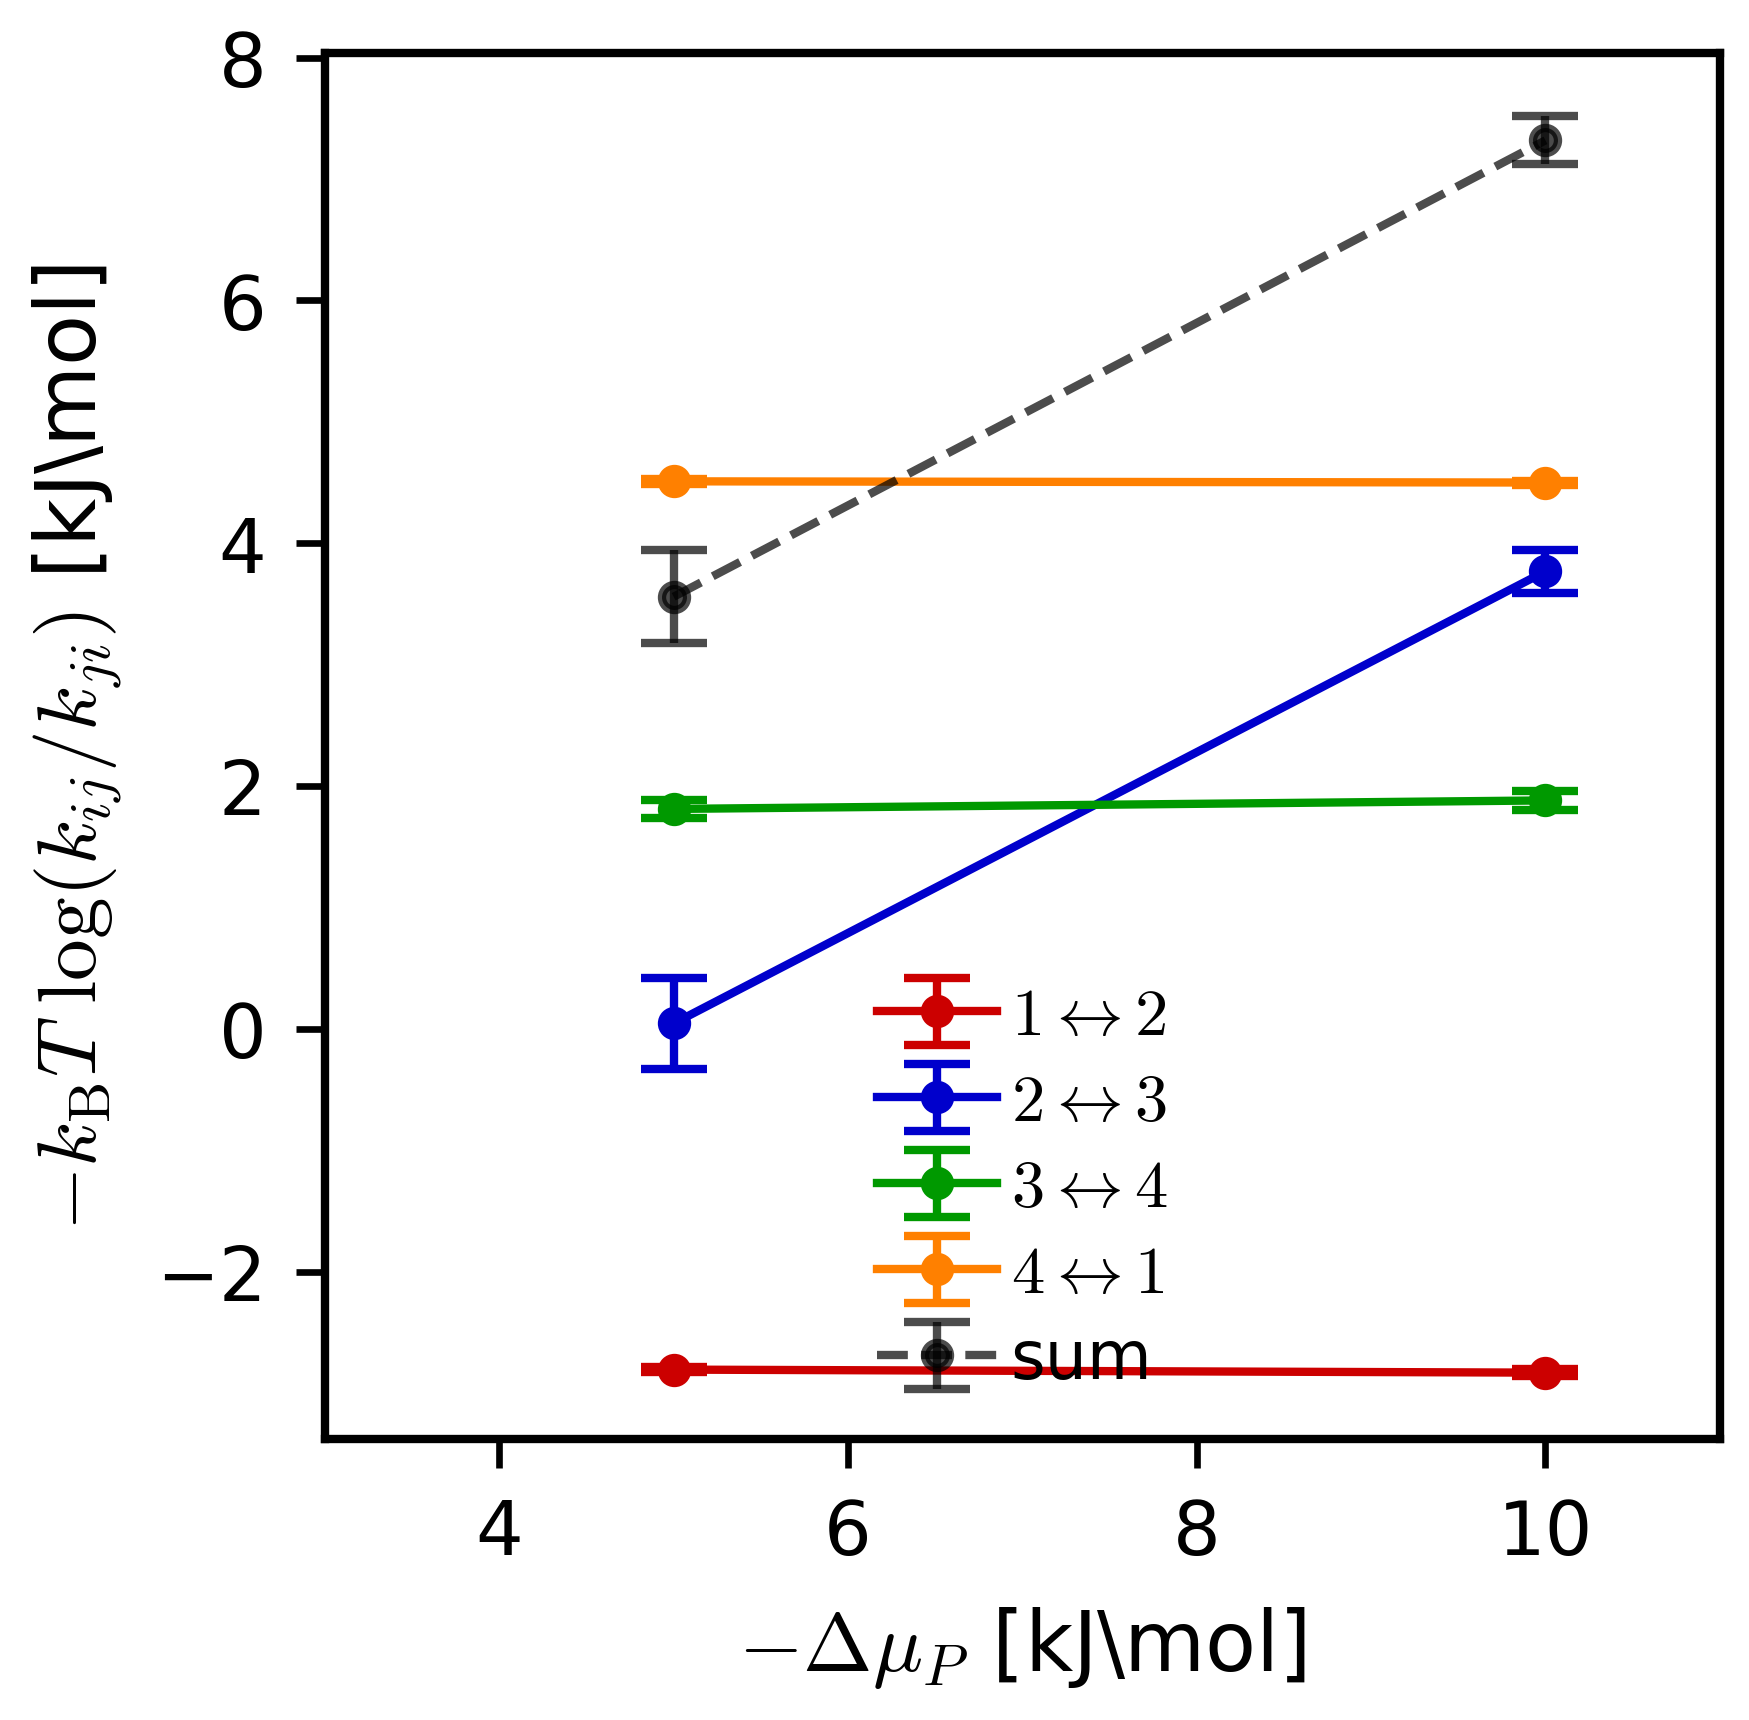

In [532]:
plt.figure(figsize=(3,3))
plt.errorbar([5,10], [dmu_split5[0],dmu_split10[0]], [sigma_dmu_split5[0],sigma_dmu_split10[0]], capsize=4, fmt='o-', label=r'$1 \leftrightarrow 2$')
plt.errorbar([5,10], [dmu_split5[1],dmu_split10[1]], [sigma_dmu_split5[1],sigma_dmu_split10[1]], capsize=4, fmt='o-',label=r'$2 \leftrightarrow 3$')
plt.errorbar([5,10], [dmu_split5[2],dmu_split10[2]], [sigma_dmu_split5[2],sigma_dmu_split10[2]], capsize=4, fmt='o-',label=r'$3 \leftrightarrow 4$')
plt.errorbar([5,10], [dmu_split5[3],dmu_split10[3]], [sigma_dmu_split5[3],sigma_dmu_split10[3]], capsize=4, fmt='o-',label=r'$4 \leftrightarrow 1$')
plt.errorbar([5,10], [np.sum(dmu_split5),np.sum(dmu_split10)], [np.sqrt(np.sum(sigma_dmu_split5**2)), np.sqrt(np.sum(sigma_dmu_split10**2))], capsize=4, fmt='o--k', alpha=0.7, label=r'sum')

#plt.xticks([0,5,10],[0,5,10])
plt.xlabel('$- \Delta \mu_P$ [kJ\mol]')
plt.ylabel('$- k_\mathrm{B } T~ \log(k_{ij}/k_{ji})$ [kJ\mol]')

plt.legend(ncols=1)
plt.xlim(3,11.)
#plt.ylim(3,11.)

# Distribution of energies

In [81]:
lc = []
for s in range(1,11):
    lc.append( len( np.loadtxt(path_simple+f'sim_ser19_dmu-10_1-tdp43-5pser_1-ck1d-open_10k/sim{s}_ser19_dmu-10_1-tdp43-5pser_com-ck1d-open_CAL3_10k_10us_contacts.txt') ))

print(f'average contact rate: {np.mean(lc)/20}+-{np.std(lc)/60} contacts/us')

average contact rate: 4.975+-0.2093972832255047 contacts/us


In [80]:
lc = []
for s in range(1,11):
    lc.append( len( np.where( np.loadtxt(path_simple+f'sim_ser19_dmu-10_1-tdp43-5pser_1-ck1d-open_10k/sim{s}_ser19_dmu-10_1-tdp43-5pser_com-ck1d-open_CAL3_10k_10us_contacts.txt')[:,2]==1 )[0] ))

print(f'average accepted phosphorylation rate: {np.mean(lc)/20}+-{np.std(lc)/60} contacts/us')

average accepted phosphorylation rate: 1.355+-0.07433034373659253 contacts/us


In [243]:
c = np.loadtxt(path_mc+f'sim1_ser19_dmu-5_1-tdp43-5pser_com-ck1d-open_CAL3_10k_MCkin_contacts.txt')
c = np.append( c, np.loadtxt(path_mc+f'sim2_ser19_dmu-5_1-tdp43-5pser_com-ck1d-open_CAL3_10k_MCkin_contacts.txt'), axis=0)
c.shape

(108, 10)

(array([ 8., 15., 14., 12., 10.,  5., 11.,  7.,  6.,  5.,  4.,  1.,  2.,
         4.,  0.,  1.,  0.,  0.,  1.,  2.]),
 array([0.013408  , 0.44916685, 0.8849257 , 1.32068455, 1.7564434 ,
        2.19220225, 2.6279611 , 3.06371995, 3.4994788 , 3.93523765,
        4.3709965 , 4.80675535, 5.2425142 , 5.67827305, 6.1140319 ,
        6.54979075, 6.9855496 , 7.42130845, 7.8570673 , 8.29282615,
        8.728585  ]),
 <BarContainer object of 20 artists>)

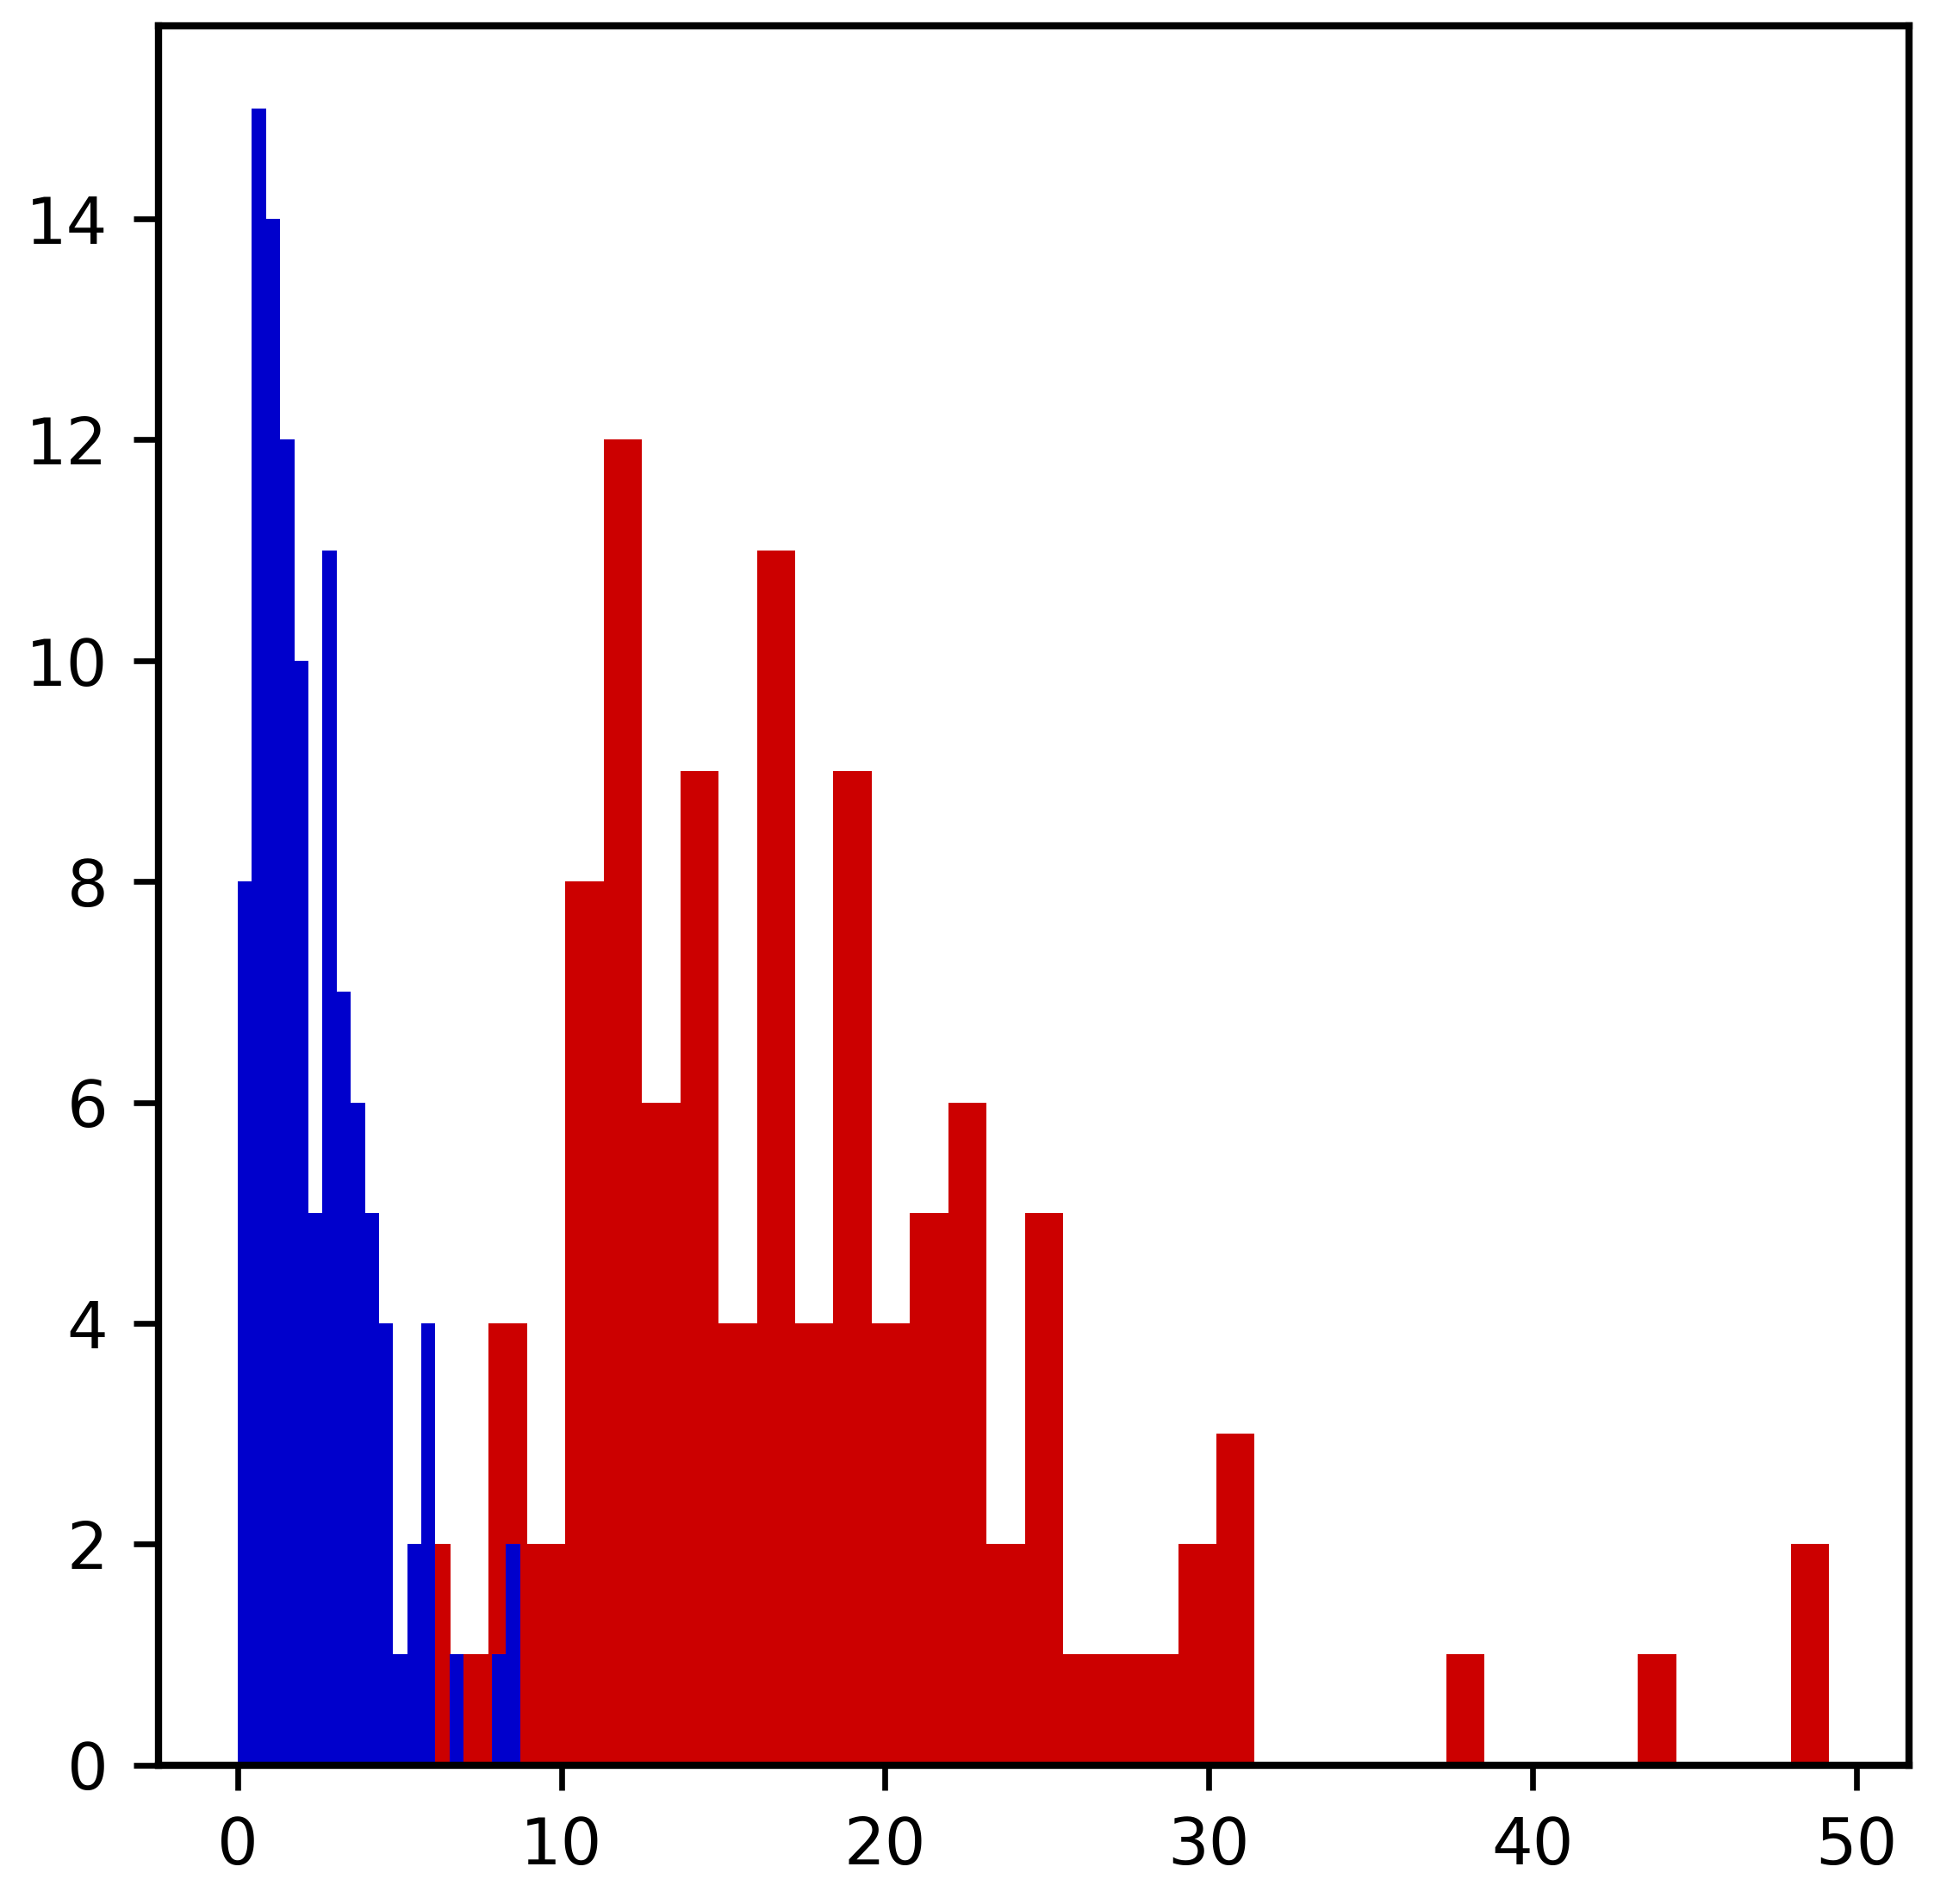

In [249]:
plt.figure()
plt.hist(c[:,4],40)
plt.hist(c[:,5],20)